# Import Libraries

In [4]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, make_scorer, mean_squared_error, mean_absolute_percentage_error
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import randint, uniform

In [5]:
df1 = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/Forecast.csv")
df1.head()

Month-Year  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0     23-Jul               6  600001  KR001      KR   909  868.279179   4.50%   
1     23-Aug               6  600001  KR001      KR   786  867.675973  10.40%   
2     23-Sep               6  600001  KR001      KR   846  906.330589   7.10%   
3     23-Oct               6  600001  KR001      KR   761  907.327425  19.20%   
4     23-Nov               6  600001  KR001      KR   786  868.000000  10.40%   

  MAPE_Impact MAPE_Contribution  Absolute Error  Non Absolute Error  
0       0.00%             0.00%       40.720821          -40.720821  
1       0.01%             0.00%       81.675973           81.675973  
2       0.01%             0.00%       60.330590           60.330590  
3       0.01%             0.10%      146.327425          146.327425  
4       0.01%             0.00%       82.000000           82.000000

In [6]:
df1.shape

(17342, 12)

In [7]:
df2 = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/Stocks.csv")
df2.head()

Product.Family    GMID GMID_Description     Market      Geography  \
0               6  600001     06 2.9MG/5ML      Korea  International   
1               6  600002     06 2.9MG/5ML  Hong Kong  Greater China   
2               6  600003     06 2.9MG/5ML     Canada  North America   
3               6  600004     06 2.9MG/5ML   Malaysia  International   
4               6  600005     06 500IU/5ML  Australia  International   

  Material.Type.GMID    Date  Coverage   Min   Max  
0                 FG  23-Jul      1.82  2.73  4.91  
1                 FG  23-Jul      3.09  2.86  5.68  
2                 FG  23-Jul      3.41  2.73  5.68  
3                 FG  23-Jul      0.91  3.18  9.14  
4                 FG  23-Jul      0.91  2.73  4.59

In [12]:
df2.shape

(24234, 10)

In [14]:
df_geo  = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/Countries_Geo.csv")
df_geo.head()

Country_Key     Country_Desc      Geography
0          AL          Albania            NaN
1          DZ          Algeria  International
2          VI  Amer.Virgin Is.            NaN
3          AR        Argentina  International
4          AU        Australia  International

In [16]:
df_md  = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/MD.csv")
df_md.head()

GMID Market  PRODUCT_FAMILY DOSAGE_STRENGTH MATERIAL_TYPE LSD_STATUS  \
0  150167     CY              15  200 MG/1,14 ML            FG         No   
1  150024     EC              15     300 MG/2 ML            FG         No   
2  150002     CH              15     300 MG/2 ML            FG         No   
3  800009     TW               8          400 IU            FG         No   
4  150098     OM              15     300 MG/2 ML            FG     Global   

  MCO_SEGMENTATION STRATEGY_SEGMENTATION SMART_SEGMENTATION  
0      Regular MCO          Auto Piloted      Supply Growth  
1      Regular MCO          Auto Piloted      Supply Growth  
2          Top MCO              Platinum      Supply Growth  
3      Regular MCO                  Gold             Secure  
4      Regular MCO              Platinum      Supply Growth

# Data Preparation

### Merge Datasets

#### Merge df1 ( sales, forecast, mape, absolute error information) with df_geo to append Market and Geography column

In [21]:
# Merge df1 with country metadata to add Country_Desc and Geography columns
df1_enriched = df1.merge(
    df_geo[['Country_Key', 'Country_Desc', 'Geography']],
    left_on='Country',
    right_on='Country_Key',
    how='left'  # Preserves all rows from df1
)
df1_enriched.drop(columns='Country_Key', inplace=True)
df1_enriched.head()

Month-Year  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0     23-Jul               6  600001  KR001      KR   909  868.279179   4.50%   
1     23-Aug               6  600001  KR001      KR   786  867.675973  10.40%   
2     23-Sep               6  600001  KR001      KR   846  906.330589   7.10%   
3     23-Oct               6  600001  KR001      KR   761  907.327425  19.20%   
4     23-Nov               6  600001  KR001      KR   786  868.000000  10.40%   

  MAPE_Impact MAPE_Contribution  Absolute Error  Non Absolute Error  \
0       0.00%             0.00%       40.720821          -40.720821   
1       0.01%             0.00%       81.675973           81.675973   
2       0.01%             0.00%       60.330590           60.330590   
3       0.01%             0.10%      146.327425          146.327425   
4       0.01%             0.00%       82.000000           82.000000   

  Country_Desc      Geography  
0        Korea  International  
1        Korea  International  
2        Korea  International  
3        Korea  International  
4        Korea  International

In [23]:
# check duplication of rows after merge
print("Before merge:", len(df1))
print("After merge:", len(df1_enriched))

Before merge: 17342
After merge: 17342


In [25]:
# Change column Month-Year to Date in df1 and df2
df1_enriched.rename(columns={'Month-Year': 'Date'}, inplace=True)

# Standardize keys in both dataframes
df1_enriched['Date'] = df1_enriched['Date'].astype(str).str.strip().str.strip("'").str.title()
df1_enriched['Date'] = pd.to_datetime(df1_enriched['Date'], format='%y-%b', errors='coerce')

df2['Date'] = df2['Date'].astype(str).str.strip().str.title()
df2['Date'] = pd.to_datetime(df2['Date'], format='%y-%b', errors='coerce')

#### Identify and resolve duplicate records in df2

In [28]:
#check duplicates
# Check if GMID + Date + Country_Key appear only once
duplicates = df2.duplicated(subset=['GMID', 'Date', 'Market'])
print("Duplicate rows in df2:", duplicates.sum())


Duplicate rows in df2: 495


In [30]:
#Define key columns and priority rows (non-null coverage, min, max)

# Replace NaNs with 0 for comparison
df2['Coverage'] = df2['Coverage'].fillna(0)
df2['Min'] = df2['Min'].fillna(0)
df2['Max'] = df2['Max'].fillna(0)

# Mark rows with valid (non-zero) values
df2['has_data'] = (df2['Coverage'] > 0) | (df2['Min'] > 0) | (df2['Max'] > 0)

#Sort to valid rows come first
df2 = df2.sort_values(by='has_data', ascending=False)

#Drop duplicates by keeping the first one (which now has valid values)
df2 = df2.drop_duplicates(subset=['GMID', 'Date', 'Market'], keep='first')

#Drop helper column
df2.drop(columns='has_data', inplace=True)

In [32]:
# double check duplicated rows
df2.duplicated(subset=['GMID', 'Date', 'Market']).sum()

0

#### Merge df1 (main dataset) with df2 (stock levels information)

In [35]:
# Merge 2 tables
df_merged = df1_enriched.merge(
    df2[['GMID', 'Date', 'Market', 'Coverage', 'Min', 'Max']],
    left_on=['GMID', 'Date', 'Country_Desc'],
    right_on=['GMID', 'Date', 'Market'],
    how='left'
)

df_merged.drop(columns=['MAPE_Impact','MAPE_Contribution', 'Non Absolute Error', 'Market'], inplace=True)
df_merged.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0 2023-07-01               6  600001  KR001      KR   909  868.279179   4.50%   
1 2023-08-01               6  600001  KR001      KR   786  867.675973  10.40%   
2 2023-09-01               6  600001  KR001      KR   846  906.330589   7.10%   
3 2023-10-01               6  600001  KR001      KR   761  907.327425  19.20%   
4 2023-11-01               6  600001  KR001      KR   786  868.000000  10.40%   

   Absolute Error Country_Desc      Geography  Coverage   Min   Max  
0       40.720821        Korea  International      1.82  2.73  4.91  
1       81.675973        Korea  International      4.27  2.73  4.91  
2       60.330590        Korea  International      3.27  2.73  4.91  
3      146.327425        Korea  International      2.27  2.73  4.91  
4       82.000000        Korea  International      3.23  2.73  4.91

In [37]:
#check duplication of rows after merge
print("Before merge:", len(df1_enriched))
print("After merge:", len(df_merged))


Before merge: 17342
After merge: 17342


#### Merge df1 (main dataset) with df_md (market and product segmentation information)

In [40]:
df_smart = df_md[['PRODUCT_FAMILY', 'SMART_SEGMENTATION']].drop_duplicates()

df1_smart = df_merged.merge(
    df_smart,
    on='PRODUCT_FAMILY',
    how='left'
)
df1_smart.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0 2023-07-01               6  600001  KR001      KR   909  868.279179   4.50%   
1 2023-08-01               6  600001  KR001      KR   786  867.675973  10.40%   
2 2023-09-01               6  600001  KR001      KR   846  906.330589   7.10%   
3 2023-10-01               6  600001  KR001      KR   761  907.327425  19.20%   
4 2023-11-01               6  600001  KR001      KR   786  868.000000  10.40%   

   Absolute Error Country_Desc      Geography  Coverage   Min   Max  \
0       40.720821        Korea  International      1.82  2.73  4.91   
1       81.675973        Korea  International      4.27  2.73  4.91   
2       60.330590        Korea  International      3.27  2.73  4.91   
3      146.327425        Korea  International      2.27  2.73  4.91   
4       82.000000        Korea  International      3.23  2.73  4.91   

  SMART_SEGMENTATION  
0             Secure  
1             Secure  
2             Secure  
3             Secure  
4             Secure

In [42]:
#check duplication of rows after merge
print("Before merge:", len(df_merged))
print("After merge:", len(df1_smart))

Before merge: 17342
After merge: 17342


In [44]:
df_mco = df_md[['Market', 'MCO_SEGMENTATION']].drop_duplicates()

df1_mco = df1_smart.merge(
    df_mco,
    left_on='Country',
    right_on='Market',
    how='left'
).drop(columns=['Market'])  # Optional: remove Market after merge
df1_mco.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0 2023-07-01               6  600001  KR001      KR   909  868.279179   4.50%   
1 2023-08-01               6  600001  KR001      KR   786  867.675973  10.40%   
2 2023-09-01               6  600001  KR001      KR   846  906.330589   7.10%   
3 2023-10-01               6  600001  KR001      KR   761  907.327425  19.20%   
4 2023-11-01               6  600001  KR001      KR   786  868.000000  10.40%   

   Absolute Error Country_Desc      Geography  Coverage   Min   Max  \
0       40.720821        Korea  International      1.82  2.73  4.91   
1       81.675973        Korea  International      4.27  2.73  4.91   
2       60.330590        Korea  International      3.27  2.73  4.91   
3      146.327425        Korea  International      2.27  2.73  4.91   
4       82.000000        Korea  International      3.23  2.73  4.91   

  SMART_SEGMENTATION MCO_SEGMENTATION  
0             Secure        Major MCO  
1             Secure        Major MCO  
2             Secure        Major MCO  
3             Secure        Major MCO  
4             Secure        Major MCO

In [46]:
#check duplication of rows after merge
print("Before merge:", len(df_merged))
print("After merge:", len(df1_mco))

Before merge: 17342
After merge: 17342


In [48]:
df_strategy = df_md[['GMID', 'Market', 'STRATEGY_SEGMENTATION']].drop_duplicates()

df_final = df1_mco.merge(
    df_strategy,
    left_on=['GMID', 'Country'],
    right_on=['GMID', 'Market'],
    how='left'
).drop(columns=['Market'])  # Again, drop Market if it’s redundant
df_final.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast    MAPE  \
0 2023-07-01               6  600001  KR001      KR   909  868.279179   4.50%   
1 2023-08-01               6  600001  KR001      KR   786  867.675973  10.40%   
2 2023-09-01               6  600001  KR001      KR   846  906.330589   7.10%   
3 2023-10-01               6  600001  KR001      KR   761  907.327425  19.20%   
4 2023-11-01               6  600001  KR001      KR   786  868.000000  10.40%   

   Absolute Error Country_Desc      Geography  Coverage   Min   Max  \
0       40.720821        Korea  International      1.82  2.73  4.91   
1       81.675973        Korea  International      4.27  2.73  4.91   
2       60.330590        Korea  International      3.27  2.73  4.91   
3      146.327425        Korea  International      2.27  2.73  4.91   
4       82.000000        Korea  International      3.23  2.73  4.91   

  SMART_SEGMENTATION MCO_SEGMENTATION STRATEGY_SEGMENTATION  
0             Secure        Major MCO              Platinum  
1             Secure        Major MCO              Platinum  
2             Secure        Major MCO              Platinum  
3             Secure        Major MCO              Platinum  
4             Secure        Major MCO              Platinum

In [50]:
#check duplication of rows after merge
print("Before merge:", len(df_merged))
print("After merge:", len(df_final))


Before merge: 17342
After merge: 17342


In [52]:
# rename columns name

df_final.rename(columns={'Country_Desc': 'Market'}, inplace=True)
df_final.rename(columns={'SMART_SEGMENTATION': 'pf_segmentation'}, inplace=True)
df_final.rename(columns={'MCO_SEGMENTATION': 'market_segmentation'}, inplace=True)
df_final.rename(columns={'STRATEGY_SEGMENTATION': 'gmid_segmentation'}, inplace=True)
df_final.rename(columns={'Coverage': 'coverage_months'}, inplace=True)
                         
# Define the new order of columns
new_order = ['Date', 'PRODUCT_FAMILY', 'GMID', 'LOC', 'Country','Market', 'Geography', 'Sales','Forecast', 'MAPE',
             'Absolute Error','coverage_months', 'Min', 'Max', 'market_segmentation', 'pf_segmentation',	'gmid_segmentation']

# Apply the new order
df = df_final[new_order]
df.head()

Date  PRODUCT_FAMILY    GMID    LOC Country Market      Geography  \
0 2023-07-01               6  600001  KR001      KR  Korea  International   
1 2023-08-01               6  600001  KR001      KR  Korea  International   
2 2023-09-01               6  600001  KR001      KR  Korea  International   
3 2023-10-01               6  600001  KR001      KR  Korea  International   
4 2023-11-01               6  600001  KR001      KR  Korea  International   

  Sales    Forecast    MAPE  Absolute Error  coverage_months   Min   Max  \
0   909  868.279179   4.50%       40.720821             1.82  2.73  4.91   
1   786  867.675973  10.40%       81.675973             4.27  2.73  4.91   
2   846  906.330589   7.10%       60.330590             3.27  2.73  4.91   
3   761  907.327425  19.20%      146.327425             2.27  2.73  4.91   
4   786  868.000000  10.40%       82.000000             3.23  2.73  4.91   

  market_segmentation pf_segmentation gmid_segmentation  
0           Major MCO          Secure          Platinum  
1           Major MCO          Secure          Platinum  
2           Major MCO          Secure          Platinum  
3           Major MCO          Secure          Platinum  
4           Major MCO          Secure          Platinum

# Data Cleaning & Wrangling

In [55]:
#format the headers
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')


In [57]:
#check data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17342 entries, 0 to 17341
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 17342 non-null  datetime64[ns]
 1   product_family       17342 non-null  int64         
 2   gmid                 17342 non-null  int64         
 3   loc                  17342 non-null  object        
 4   country              17342 non-null  object        
 5   market               17342 non-null  object        
 6   geography            17342 non-null  object        
 7   sales                17342 non-null  object        
 8   forecast             17342 non-null  float64       
 9   mape                 15695 non-null  object        
 10  absolute_error       17342 non-null  float64       
 11  coverage_months      15799 non-null  float64       
 12  min                  15799 non-null  float64       
 13  max                  15799 non-

In [59]:
#change types by column

# Remove commas and convert to integers
df['sales'] = df['sales'].astype(str).str.replace(',', '', regex=False)
df['sales'] = pd.to_numeric(df['sales'], errors='coerce').fillna(0).astype('int64')

df['forecast'] = (
    df['forecast']
    .astype(str)
    .str.replace(',', '', regex=False)
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0)
    .apply(lambda x: int(round(x)))
)


float_cols = ['mape','absolute_error','coverage_months', 'min', 'max']

for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').round(2)

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [61]:
#recalculate MAPE, Absolute error columns

# Absolute errors
df['absolute_error'] = (df['forecast'].astype(float) - df['sales'].astype(float)).abs().round(2)

# Recalculate mape 
df['mape'] = df.apply(
    lambda row: round(abs(row['sales'] - row['forecast']) / row['sales'] * 100, 2)
    if row['sales'] != 0 else 0,
    axis=1
)

In [63]:
df.head()

date  product_family    gmid    loc country market      geography  \
0 2023-07-01               6  600001  KR001      KR  Korea  International   
1 2023-08-01               6  600001  KR001      KR  Korea  International   
2 2023-09-01               6  600001  KR001      KR  Korea  International   
3 2023-10-01               6  600001  KR001      KR  Korea  International   
4 2023-11-01               6  600001  KR001      KR  Korea  International   

   sales  forecast   mape  absolute_error  coverage_months   min   max  \
0    909       868   4.51            41.0             1.82  2.73  4.91   
1    786       868  10.43            82.0             4.27  2.73  4.91   
2    846       906   7.09            60.0             3.27  2.73  4.91   
3    761       907  19.19           146.0             2.27  2.73  4.91   
4    786       868  10.43            82.0             3.23  2.73  4.91   

  market_segmentation pf_segmentation gmid_segmentation  year  month  
0           Major MCO          Secure          Platinum  2023      7  
1           Major MCO          Secure          Platinum  2023      8  
2           Major MCO          Secure          Platinum  2023      9  
3           Major MCO          Secure          Platinum  2023     10  
4           Major MCO          Secure          Platinum  2023     11

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17342 entries, 0 to 17341
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 17342 non-null  datetime64[ns]
 1   product_family       17342 non-null  int64         
 2   gmid                 17342 non-null  int64         
 3   loc                  17342 non-null  object        
 4   country              17342 non-null  object        
 5   market               17342 non-null  object        
 6   geography            17342 non-null  object        
 7   sales                17342 non-null  int64         
 8   forecast             17342 non-null  int64         
 9   mape                 17342 non-null  float64       
 10  absolute_error       17342 non-null  float64       
 11  coverage_months      15799 non-null  float64       
 12  min                  15799 non-null  float64       
 13  max                  15799 non-

In [67]:
df.shape

(17342, 19)

In [69]:
#Count of missing values per column
df.isna().sum()

date                      0
product_family            0
gmid                      0
loc                       0
country                   0
market                    0
geography                 0
sales                     0
forecast                  0
mape                      0
absolute_error            0
coverage_months        1543
min                    1543
max                    1543
market_segmentation       0
pf_segmentation           0
gmid_segmentation         0
year                      0
month                     0
dtype: int64

In [71]:
# replace nan values
df[['coverage_months', 'min', 'max']] = df[['coverage_months', 'min', 'max']].fillna(0).round(2)


In [73]:
df.isna().sum()

date                   0
product_family         0
gmid                   0
loc                    0
country                0
market                 0
geography              0
sales                  0
forecast               0
mape                   0
absolute_error         0
coverage_months        0
min                    0
max                    0
market_segmentation    0
pf_segmentation        0
gmid_segmentation      0
year                   0
month                  0
dtype: int64

In [75]:
#check gmid_key duplicates
df['gmid_key'] = df['gmid'].astype(str) + '_'+ df['year'].astype(str) + df['month'].astype(str) + '_'+ df['country'].astype(str)
duplicate_rows = df['gmid_key'].duplicated().sum()
duplicate_rows


424

In [77]:
df[df['gmid_key'].duplicated()]


date  product_family    gmid    loc country  market    geography  \
573   2023-07-01               3  300004  FR003      FR  France  Key Markets   
574   2023-08-01               3  300004  FR003      FR  France  Key Markets   
575   2023-09-01               3  300004  FR003      FR  France  Key Markets   
576   2023-10-01               3  300004  FR003      FR  France  Key Markets   
577   2023-11-01               3  300004  FR003      FR  France  Key Markets   
...          ...             ...     ...    ...     ...     ...          ...   
17177 2025-03-01              11  110047  FR003      FR  France  Key Markets   
17179 2025-03-01              11  110048  FR003      FR  France  Key Markets   
17200 2025-03-01              12  120017  FR003      FR  France  Key Markets   
17295 2025-03-01              16  160019  FR003      FR  France  Key Markets   
17297 2025-03-01              16  160020  FR003      FR  France  Key Markets   

       sales  forecast    mape  absolute_error  coverage_months   min   max  \
573       32        12   62.50            20.0             8.91  0.00  0.00   
574        0        12    0.00            12.0             7.77  0.00  0.00   
575        0        12    0.00            12.0             5.59  0.00  0.00   
576        0        12    0.00            12.0             4.32  0.00  0.00   
577       35        12   65.71            23.0             8.45  0.00  0.00   
...      ...       ...     ...             ...              ...   ...   ...   
17177      0         6    0.00             6.0             0.23  2.73  4.55   
17179      8         2   75.00             6.0             0.68  2.73  4.55   
17200    120       117    2.50             3.0             0.59  2.73  4.55   
17295     17        48  182.35            31.0             6.64  2.73  6.36   
17297     15        57  280.00            42.0             4.50  2.73  6.36   

      market_segmentation pf_segmentation gmid_segmentation  year  month  \
573               Top MCO          Secure          Platinum  2023      7   
574               Top MCO          Secure          Platinum  2023      8   
575               Top MCO          Secure          Platinum  2023      9   
576               Top MCO          Secure          Platinum  2023     10   
577               Top MCO          Secure          Platinum  2023     11   
...                   ...             ...               ...   ...    ...   
17177             Top MCO          Secure          Platinum  2025      3   
17179             Top MCO          Secure          Platinum  2025      3   
17200             Top MCO   Supply Growth          Platinum  2025      3   
17295             Top MCO   Supply Growth          Platinum  2025      3   
17297             Top MCO   Supply Growth          Platinum  2025      3   

               gmid_key  
573     300004_20237_FR  
574     300004_20238_FR  
575     300004_20239_FR  
576    300004_202310_FR  
577    300004_202311_FR  
...                 ...  
17177   110047_20253_FR  
17179   110048_20253_FR  
17200   120017_20253_FR  
17295   160019_20253_FR  
17297   160020_20253_FR  

[424 rows x 20 columns]

In [79]:
#Handle duplicated gmid_key rows by summing sales and forecast, while keeping the first values for the rest, 
#The difference is in loc and the country is the same (FR001 and FR003; Ae001 and AE002, SG001 and SG002)

agg_dict = {
    'sales': 'sum',
    'forecast': 'sum',
    'date': 'first',
    'gmid': 'first',
    'country': 'first',
    'product_family': 'first',
    'market': 'first',
    'geography': 'first',
    'mape': 'first',
    'absolute_error': 'first',
    'coverage_months': 'first',
    'min': 'first',
    'max': 'first',
    'market_segmentation': 'first', 
    'pf_segmentation': 'first',
    'gmid_segmentation': 'first',
    'year': 'first',
    'month': 'first'
}
df_grouped = df.groupby('gmid_key', as_index=False).agg(agg_dict)


In [81]:
#check duplicates
df_grouped['gmid_key'].duplicated().sum()

0

In [83]:
# Define the new order of columns
new_order = ['gmid_key','date','year', 'month','product_family', 'gmid', 'country','market', 'geography', 'sales','forecast', 'mape',
             'absolute_error','coverage_months', 'min', 'max', 'market_segmentation', 'pf_segmentation', 'gmid_segmentation']

# Apply the new order
df_all = df_grouped[new_order]


In [85]:
#recalculate MAPE and Absolute error columns

# Absolute errors
df_all['absolute_error'] = (df_all['forecast'].astype(float) - df_all['sales'].astype(float)).abs().round(2)

# Recalculate mape 
df_all['mape'] = df_all.apply(
    lambda row: round(abs(row['sales'] - row['forecast']) / row['sales'] * 100, 2)
    if row['sales'] != 0 else 0,
    axis=1
)

In [87]:
df_all.head()

gmid_key       date  year  month  product_family    gmid country  \
0  100001_202310_AU 2023-10-01  2023     10               1  100001      AU   
1  100001_202310_NZ 2023-10-01  2023     10               1  100001      NZ   
2  100001_202311_AU 2023-11-01  2023     11               1  100001      AU   
3  100001_202311_NZ 2023-11-01  2023     11               1  100001      NZ   
4  100001_202312_AU 2023-12-01  2023     12               1  100001      AU   

        market      geography  sales  forecast    mape  absolute_error  \
0    Australia  International     93       108   16.13            15.0   
1  New Zealand  International     26        23   11.54             3.0   
2    Australia  International    158        87   44.94            71.0   
3  New Zealand  International      3        23  666.67            20.0   
4    Australia  International     69        88   27.54            19.0   

   coverage_months   min   max market_segmentation pf_segmentation  \
0            10.68  2.73  5.45         Regular MCO          Secure   
1             3.55  2.73  4.09         Regular MCO          Secure   
2             9.59  2.73  5.45         Regular MCO          Secure   
3             3.36  2.73  4.09         Regular MCO          Secure   
4             8.45  2.73  5.45         Regular MCO          Secure   

  gmid_segmentation  
0      Auto Piloted  
1      Auto Piloted  
2      Auto Piloted  
3      Auto Piloted  
4      Auto Piloted

# Exploratory Data Analysis (EDA)

In [90]:
#count of GMIDs
num_gmids = df_all['gmid'].nunique()
print(f"Total unique GMIDs: {num_gmids}")


Total unique GMIDs: 822


In [92]:
#count of Product Family
num_pf = df_all['product_family'].nunique()
print(f"Total unique Product Family: {num_pf}")

Total unique Product Family: 16


In [94]:
#count of Markets
num_markt = df_all['country'].nunique()
print(f"Total unique Market: {num_markt}")

Total unique Market: 71


In [96]:
#Check statistical summary
num_cols = ['sales', 'forecast', 'mape','absolute_error']

df_all[num_cols].describe()


sales       forecast           mape  absolute_error
count   16918.000000   16918.000000   16918.000000    16918.000000
mean     1622.209067    1653.010758      73.010418      314.032451
std     12099.989664   12191.690454    1453.125076     1947.380221
min         0.000000       0.000000       0.000000        0.000000
25%        28.000000      30.000000       6.332500       11.000000
50%       144.000000     146.000000      20.000000       39.000000
75%       650.000000     657.000000      51.665000      140.000000
max    383242.000000  370680.000000  178150.000000    57901.000000

### Univariate Analysis

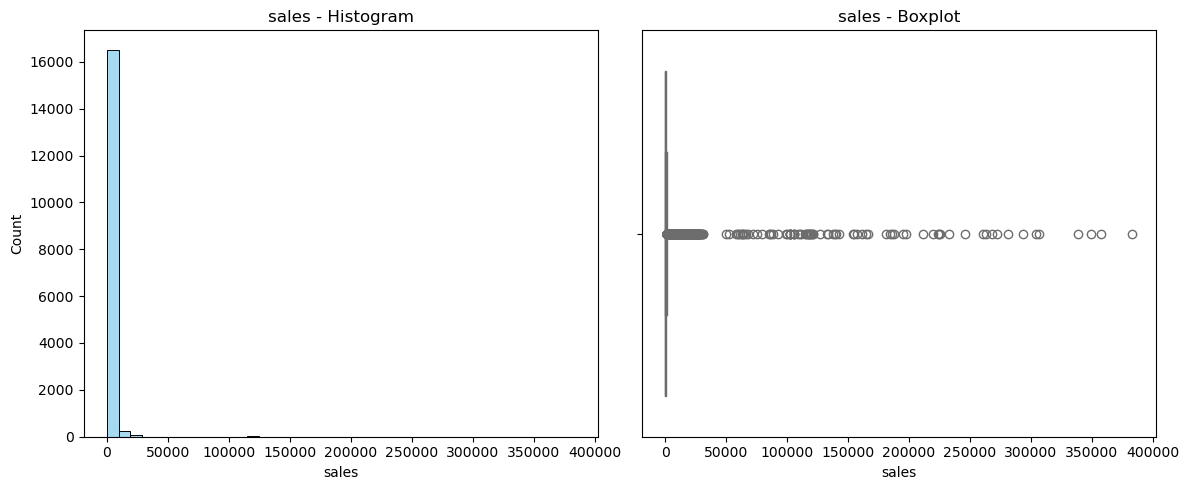

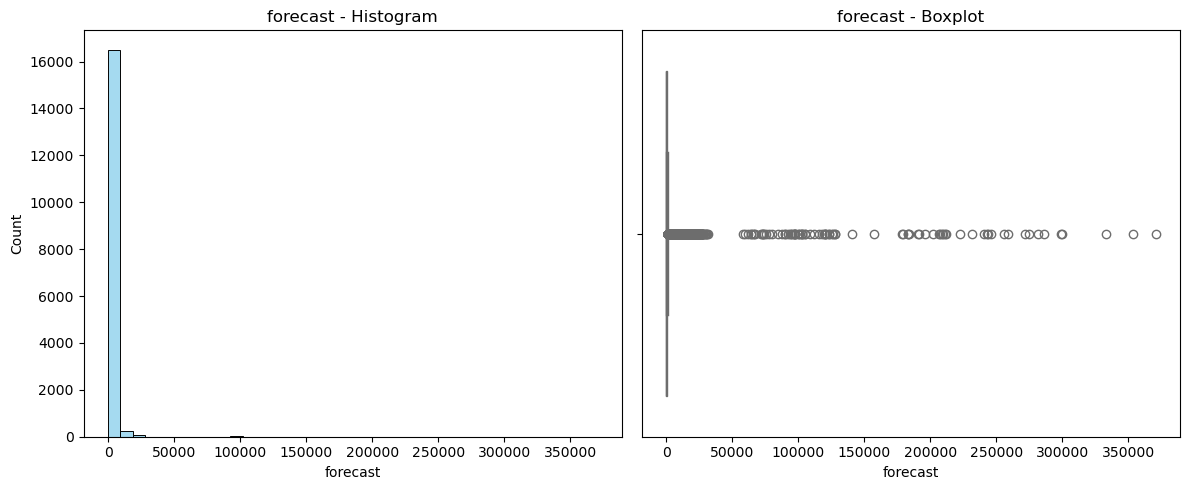

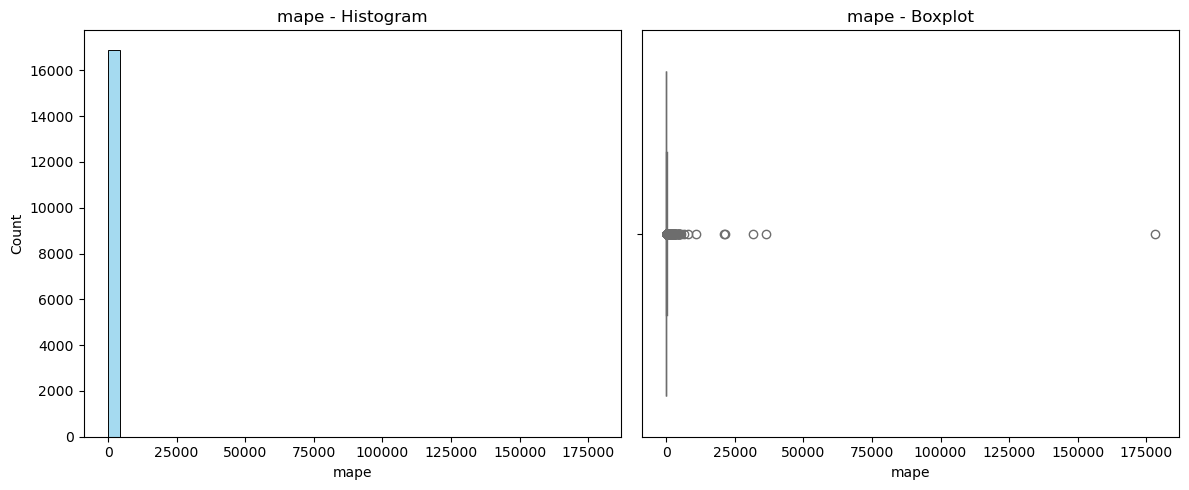

In [99]:
#Check distribution for numerical features
metrics = ['sales', 'forecast', 'mape']

for metric in metrics:
    plt.figure(figsize=(12, 5))
    
    # Histogram 
    plt.subplot(1, 2, 1)
    sns.histplot(df_all[metric], bins=40, color='skyblue')
    plt.title(f'{metric} - Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_all[metric], color='salmon')
    plt.title(f'{metric} - Boxplot')

    plt.tight_layout()
    plt.show()



/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/1395921375.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_counts, x='country', y='count', palette='viridis')


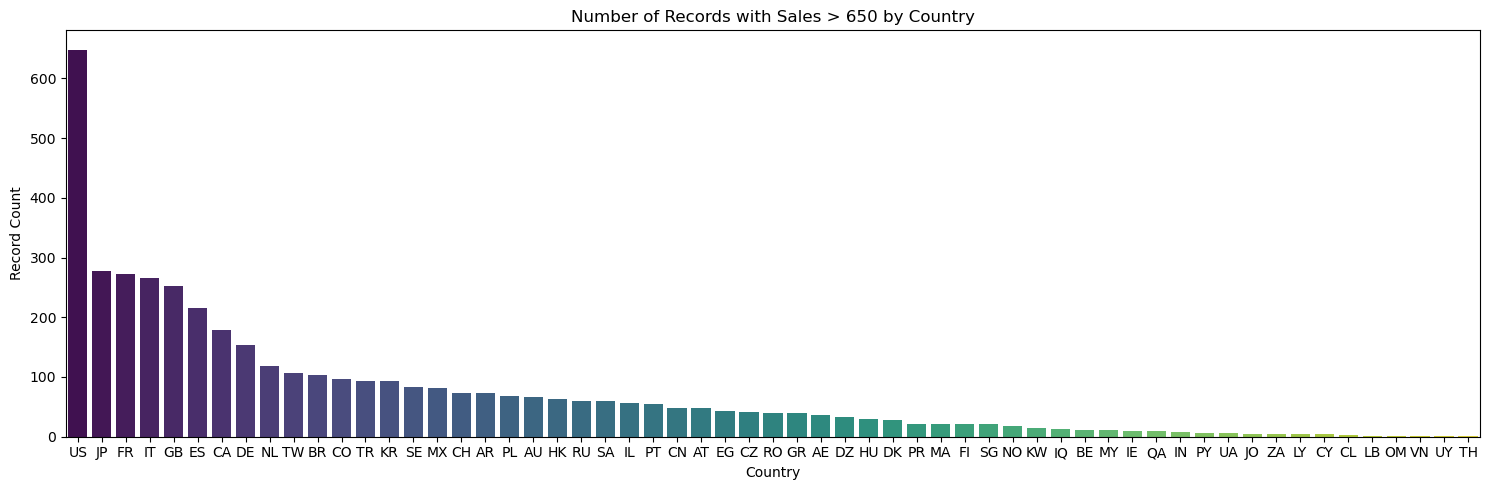

In [101]:
#High Sales by Country
# Filter rows where sales > 75th percentile
filtered_df = df_all[df_all['sales'] > 650]

# Group by country
country_counts = filtered_df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Plot
plt.figure(figsize=(15, 5))
sns.barplot(data=country_counts, x='country', y='count', palette='viridis')
plt.title('Number of Records with Sales > 650 by Country')
plt.xlabel('Country')
plt.ylabel('Record Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/1642206294.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=product_counts, x='product_family', y='count', palette='magma')


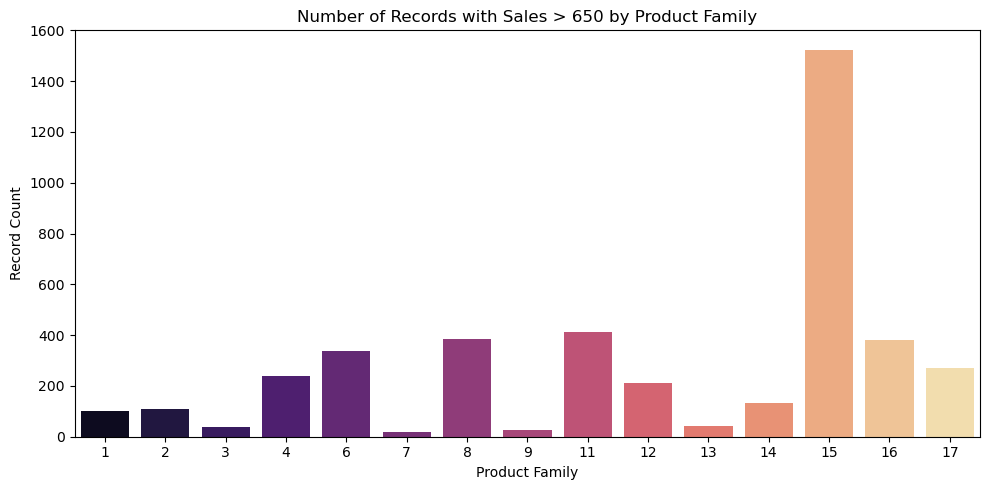

In [103]:
#High Sales by Product Family

# Group by product_family
product_counts = filtered_df['product_family'].value_counts().reset_index()
product_counts.columns = ['product_family', 'count']

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=product_counts, x='product_family', y='count', palette='magma')
plt.title('Number of Records with Sales > 650 by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Record Count')
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/914790075.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_mape_counts, x='country', y='count', palette='rocket')


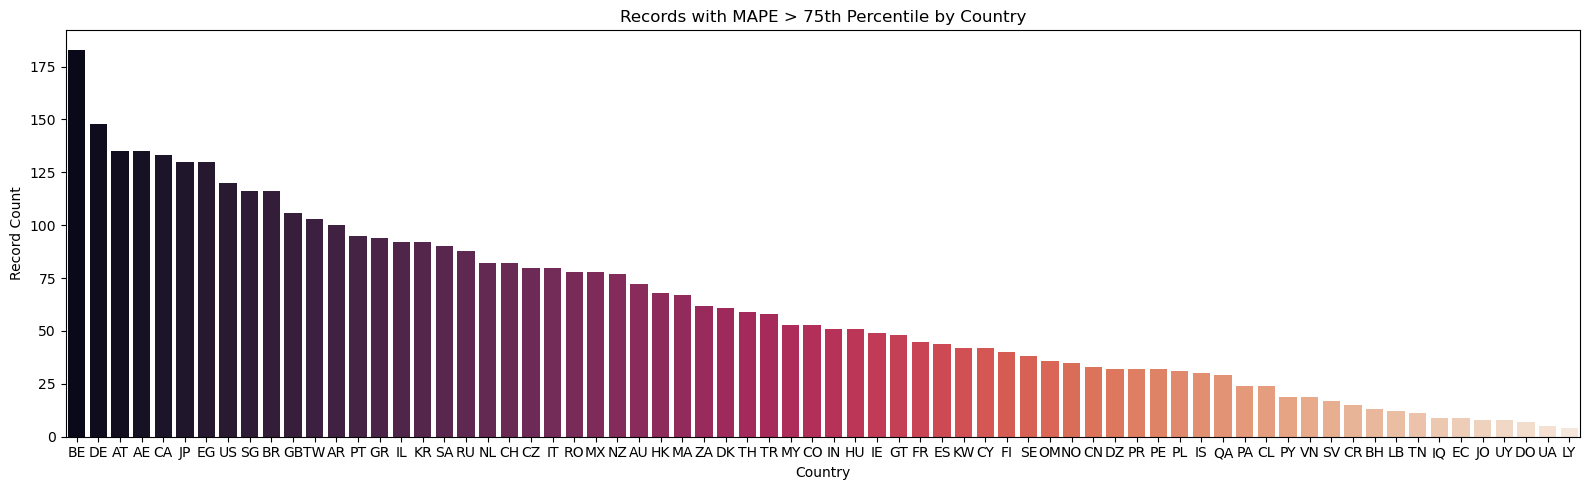

In [105]:
# Filter rows where MAPE > 75th percentile
high_mape_df = df_all[df_all['mape'] > 51.145]

# Count high MAPE records by country
country_mape_counts = high_mape_df['country'].value_counts().reset_index()
country_mape_counts.columns = ['country', 'count']

# Plot
plt.figure(figsize=(16, 5))
sns.barplot(data=country_mape_counts, x='country', y='count', palette='rocket')
plt.title('Records with MAPE > 75th Percentile by Country')
plt.xlabel('Country')
plt.ylabel('Record Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/292676926.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_mape_counts2, x='country', y='count', palette='rocket')


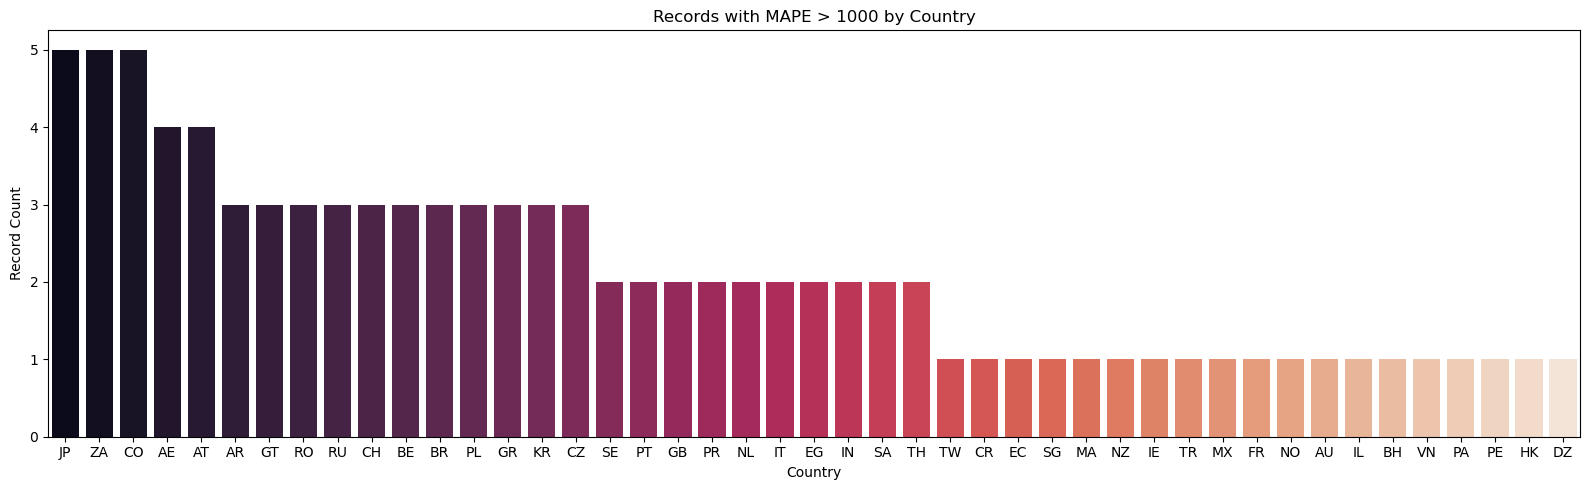

In [107]:
# Filter rows where MAPE > 1000%
high_mape_df2 = df_all[df_all['mape'] > 1000]

# Count high MAPE records by country
country_mape_counts2 = high_mape_df2['country'].value_counts().reset_index()
country_mape_counts2.columns = ['country', 'count']

# Plot
plt.figure(figsize=(16, 5))
sns.barplot(data=country_mape_counts2, x='country', y='count', palette='rocket')
plt.title('Records with MAPE > 1000 by Country')
plt.xlabel('Country')
plt.ylabel('Record Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/849339730.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.index, y=country_counts.values, palette="viridis")


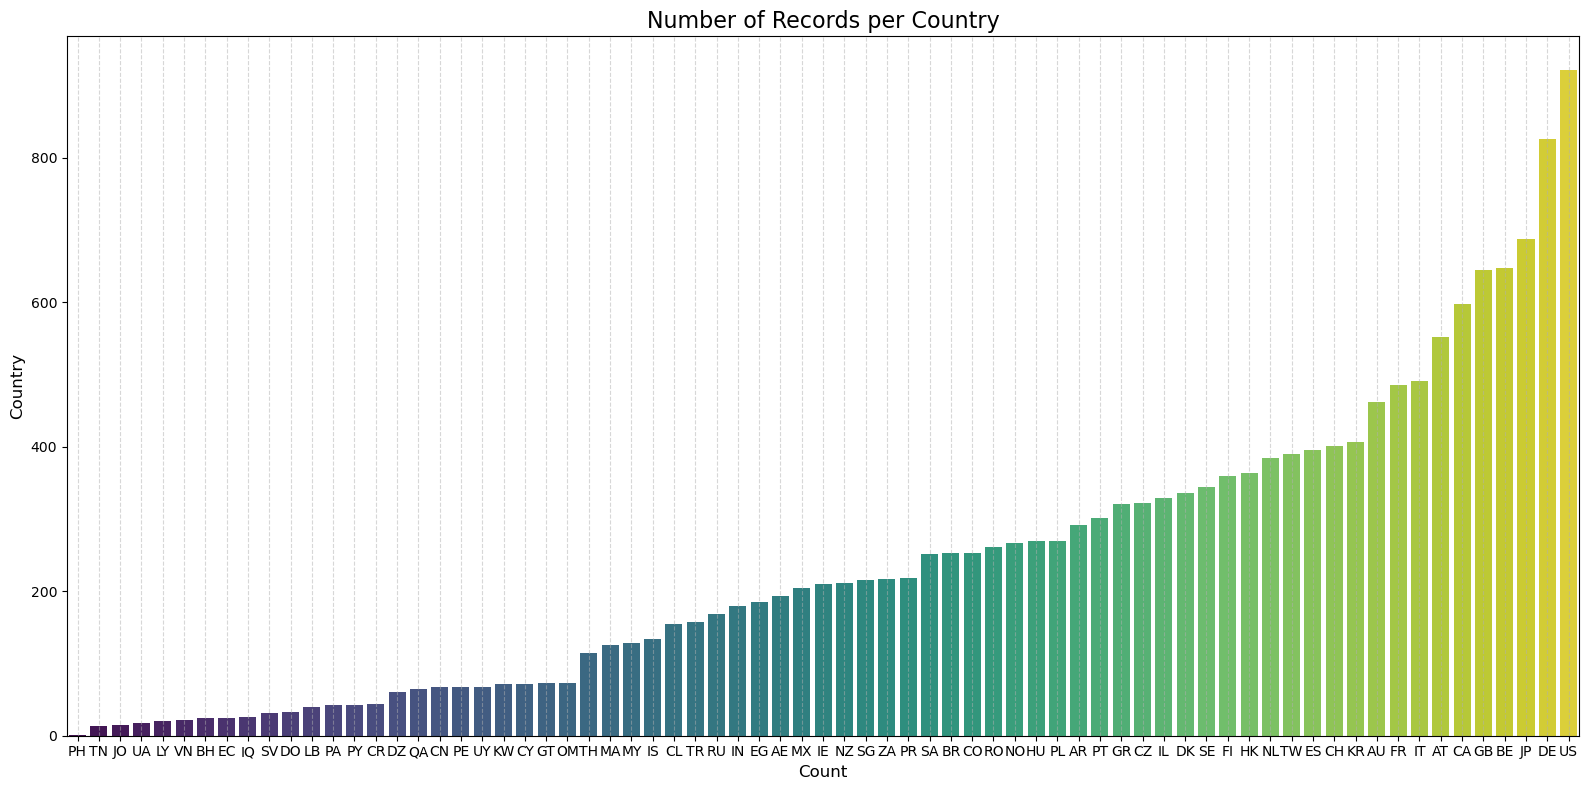

In [109]:
# Count the number of entries per country
country_counts = df_all['country'].value_counts().sort_values(ascending=True)

# Set the figure size for better spacing
plt.figure(figsize=(16, 8))  # Dynamically scale height

# Plot horizontal bar chart
sns.barplot(x=country_counts.index, y=country_counts.values, palette="viridis")

# Beautify the chart
plt.title("Number of Records per Country", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Bivariate Analysis

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/3316875510.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="month", y="sales", data=df_all, ci=None)


<Axes: xlabel='month', ylabel='sales'>

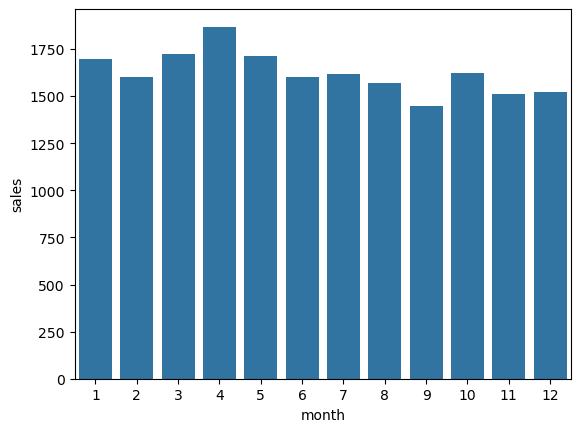

In [112]:
#mean (average) of sales for each month
sns.barplot(x="month", y="sales", data=df_all, ci=None)

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/1792484267.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_all.set_index('date').resample('M')['sales'].sum().plot(title='Monthly Sales Trend')


<Axes: title={'center': 'Monthly Sales Trend'}, xlabel='date'>

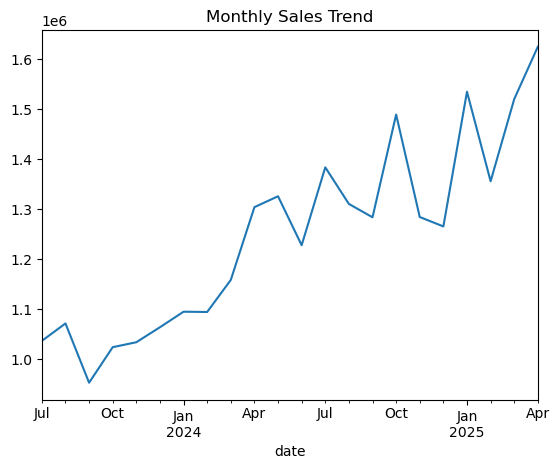

In [114]:
df_all.set_index('date').resample('M')['sales'].sum().plot(title='Monthly Sales Trend')


* Despite the upward trend, there are visible dips along the way, suggesting seasonal effects, market shifts, or temporary challenges.

Text(0.5, 1.0, 'Forecast vs. Sales')

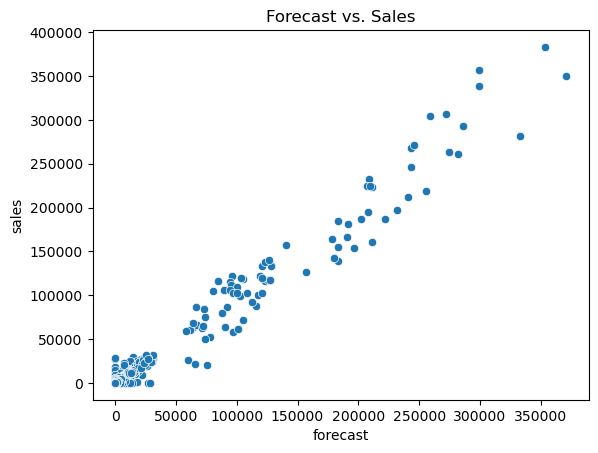

In [117]:
#Sales Vs Forecast
sns.scatterplot(x='forecast', y='sales', data=df_all)
plt.title('Forecast vs. Sales')


Strong Positive Correlation:

* Sales values rise alongside forecast values. This tight clustering along a diagonal suggests a reliable prediction model—when forecasts go up, actual sales usually follow.

Forecast Accuracy:

* The proximity of most data points to the diagonal implies high accuracy in predictions. Few outliers indicate minimal deviation between forecasted and actual results.


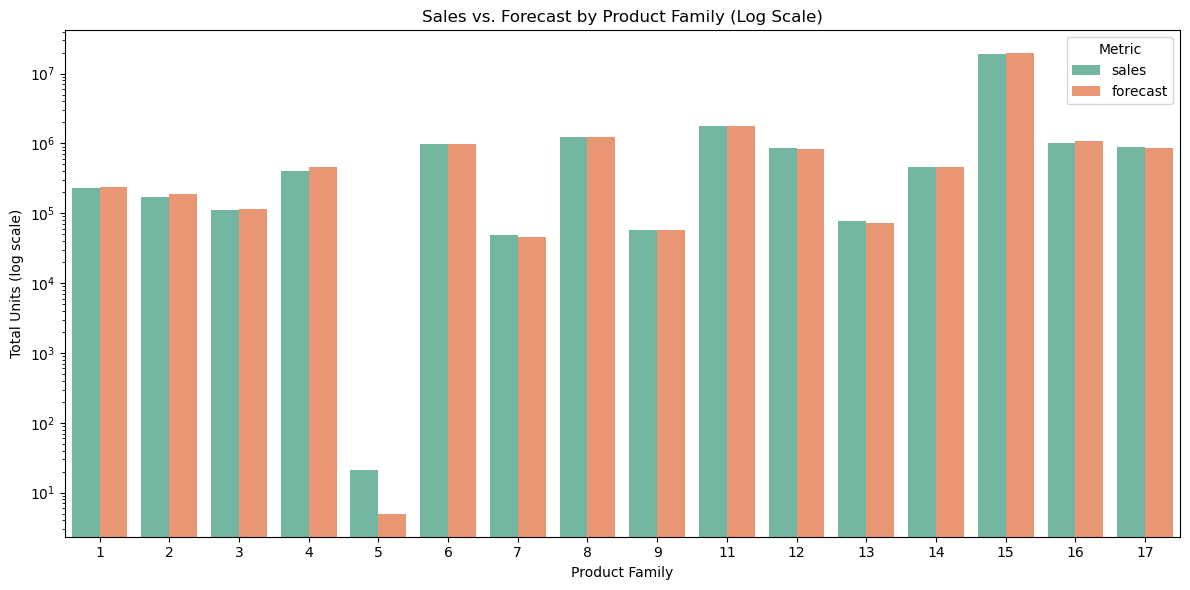

In [120]:
#sales vs. forecast side by side for each product family
# Group and sum sales & forecast by product family
sales_forecast_pf = df_all.groupby('product_family')[['sales', 'forecast']].sum().reset_index()
# Melt data to long format for grouped bars
melted_pf = sales_forecast_pf.melt(
    id_vars='product_family',
    value_vars=['sales', 'forecast'],
    var_name='type',
    value_name='value'
)



plt.figure(figsize=(12, 6))
ax = sns.barplot(data=melted_pf, x='product_family', y='value', hue='type', palette='Set2')

# Use logarithmic scale for y-axis
ax.set_yscale('log')




plt.title('Sales vs. Forecast by Product Family (Log Scale)')
plt.xlabel('Product Family')
plt.ylabel('Total Units (log scale)')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()



/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/3138713924.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=mape_by_pf, x='product_family', y='mape', palette='Blues_r')


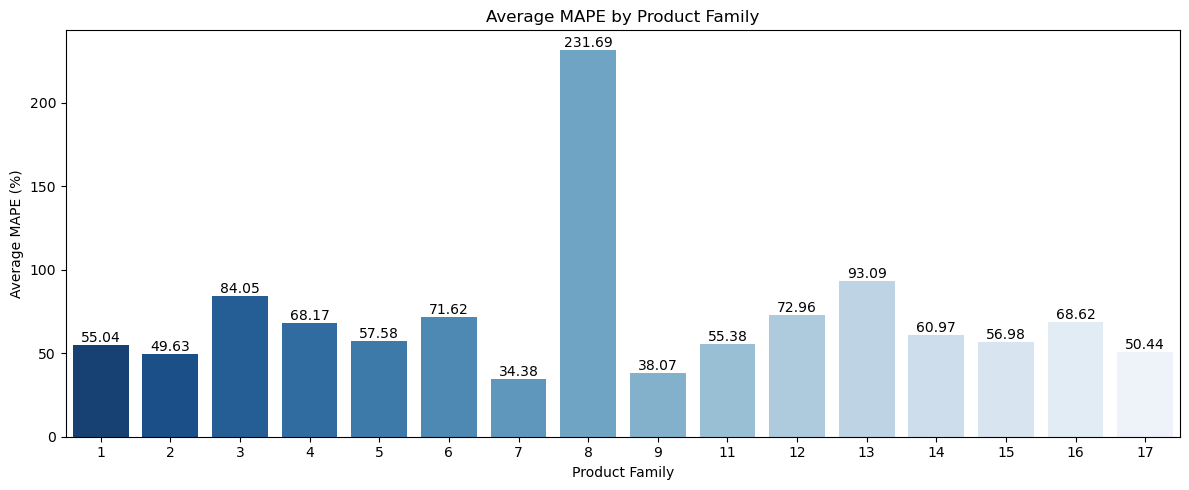

In [122]:
# Group and calculate average MAPE by product family
mape_by_pf = df_all.groupby('product_family')['mape'].mean().reset_index()

# Sort by MAPE if needed (optional)
mape_by_pf = mape_by_pf.sort_values(by='mape', ascending=False)

# Plot
plt.figure(figsize=(12, 5))
ax = sns.barplot(data=mape_by_pf, x='product_family', y='mape', palette='Blues_r')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

plt.title('Average MAPE by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Average MAPE (%)')
plt.tight_layout()
plt.show()



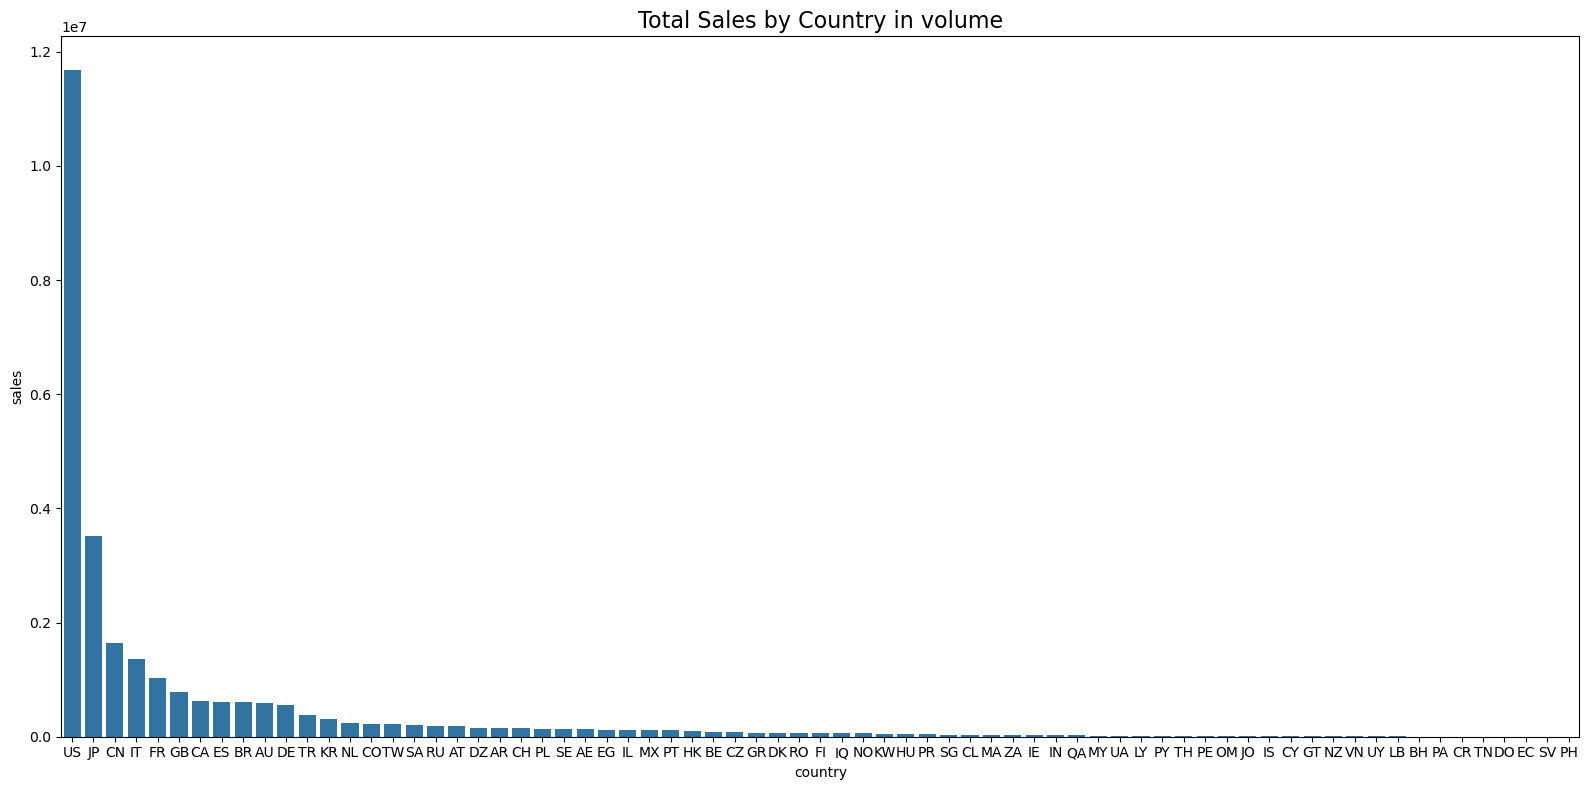

In [124]:
# Sum total sales per country
sales_by_country = df_all.groupby("country", as_index=False)["sales"].sum()
sales_by_country = sales_by_country.sort_values(by="sales", ascending=False)

# Plot total sales
plt.figure(figsize=(16, 8))
sns.barplot(x="country", y="sales", data=sales_by_country)
plt.title("Total Sales by Country in volume", fontsize=16)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


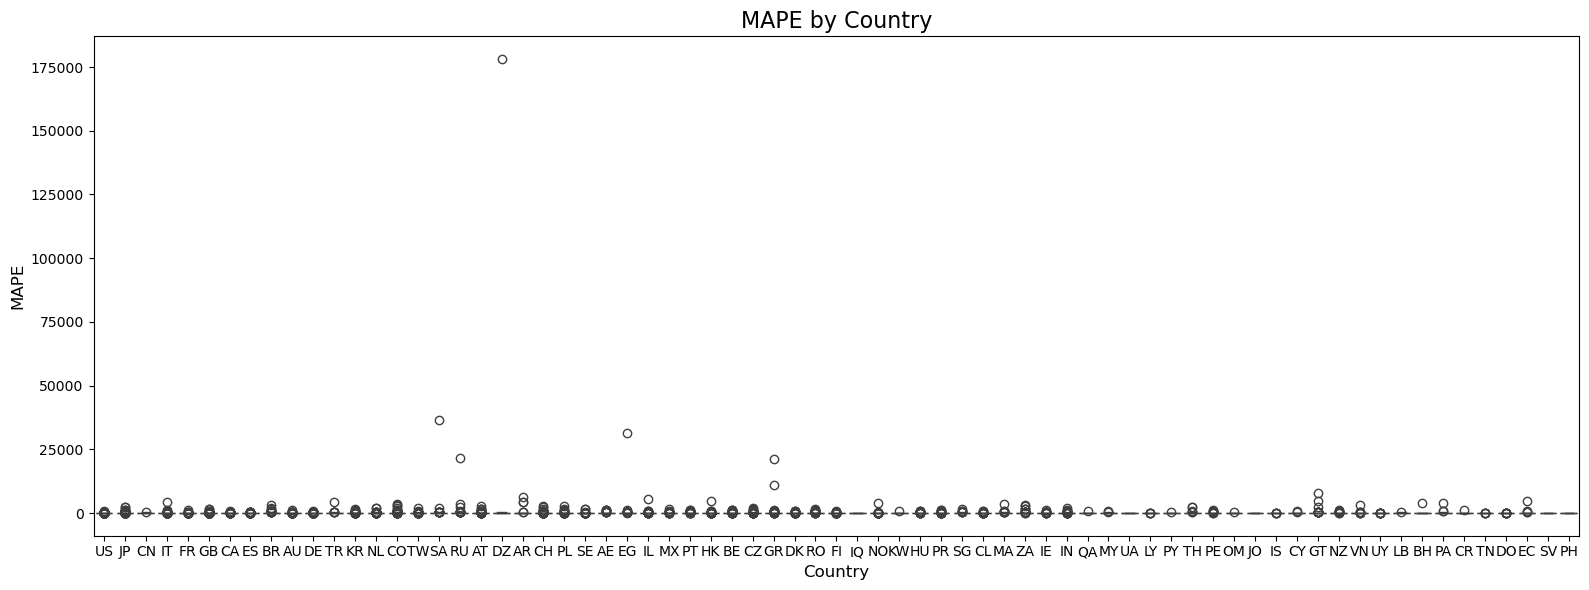

In [126]:
#mape across Countries

# First, extract the sorted country order based on total sales
country_order = sales_by_country['country']

# Now use that order in your MAPE boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(x='country', y='mape', data=df_all, order=country_order)
plt.title("MAPE by Country", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("MAPE", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


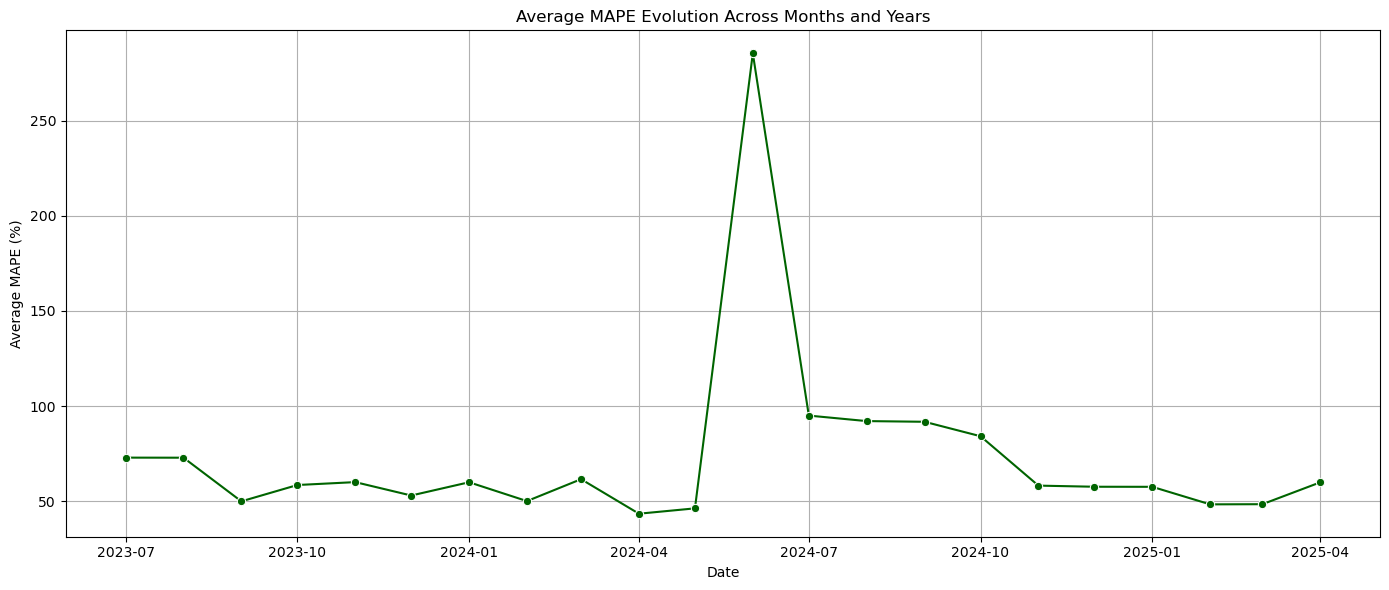

In [128]:
# Group by year and month to calculate average MAPE
mape_monthly_yearly = (
    df_all.groupby(['year', 'month'])['mape']
    .mean()
    .reset_index()
)

# Optional: create a datetime column for plotting
mape_monthly_yearly['date'] = pd.to_datetime(
    mape_monthly_yearly[['year', 'month']].assign(day=1)
)


plt.figure(figsize=(14, 6))
sns.lineplot(data=mape_monthly_yearly, x='date', y='mape', marker='o', color='darkgreen')

plt.title('Average MAPE Evolution Across Months and Years')
plt.xlabel('Date')
plt.ylabel('Average MAPE (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Diagnose the June 2024 Spike

In [131]:
spike_df = df_all[(df_all['year'] == 2024) & (df_all['month'] == 6)]
spike_summary = spike_df.groupby(['country', 'product_family'])['mape'].mean().reset_index().sort_values(by='mape', ascending=False)

spike_summary

country  product_family        mape
129      DZ               8  178150.000
241      IT              13    2261.455
188      GT               8    2249.400
136      EG              13    1076.470
132      EC              17     600.000
..      ...             ...         ...
386      TR              11       0.000
387      TR              15       0.000
92       CY               3       0.000
275      MA              11       0.000
98       CZ               7       0.000

[426 rows x 3 columns]

In [133]:
geo_mape = df_all.groupby(['geography', 'year', 'month'])['mape'].mean().reset_index()

geo_mape

geography  year  month       mape
0   Greater China  2023      7  90.121842
1   Greater China  2023      8  32.867222
2   Greater China  2023      9  41.278649
3   Greater China  2023     10  34.737368
4   Greater China  2023     11  27.195263
..            ...   ...    ...        ...
83  North America  2024     12  31.477831
84  North America  2025      1  21.976463
85  North America  2025      2  31.008072
86  North America  2025      3  26.544000
87  North America  2025      4  26.443494

[88 rows x 4 columns]

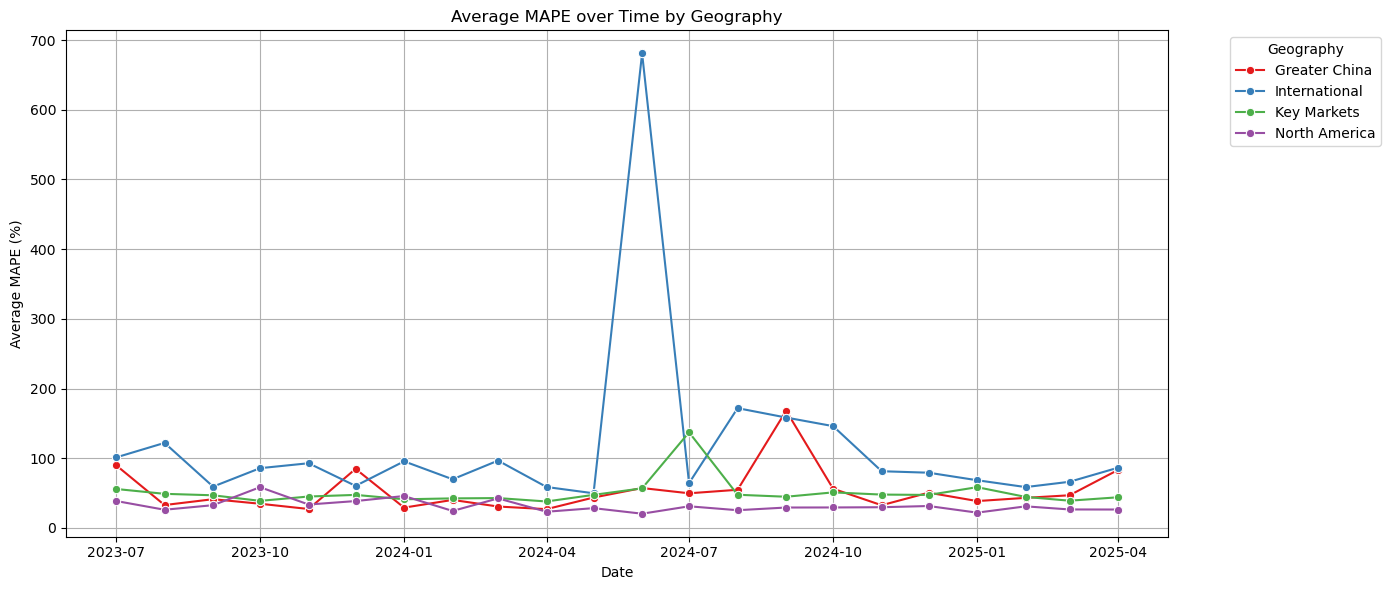

In [135]:
# Create a datetime column for proper x-axis formatting
geo_mape['date'] = pd.to_datetime(geo_mape[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 6))
sns.lineplot(data=geo_mape, x='date', y='mape', hue='geography', marker='o', palette='Set1')

plt.title('Average MAPE over Time by Geography')
plt.xlabel('Date')
plt.ylabel('Average MAPE (%)')
plt.legend(title='Geography', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


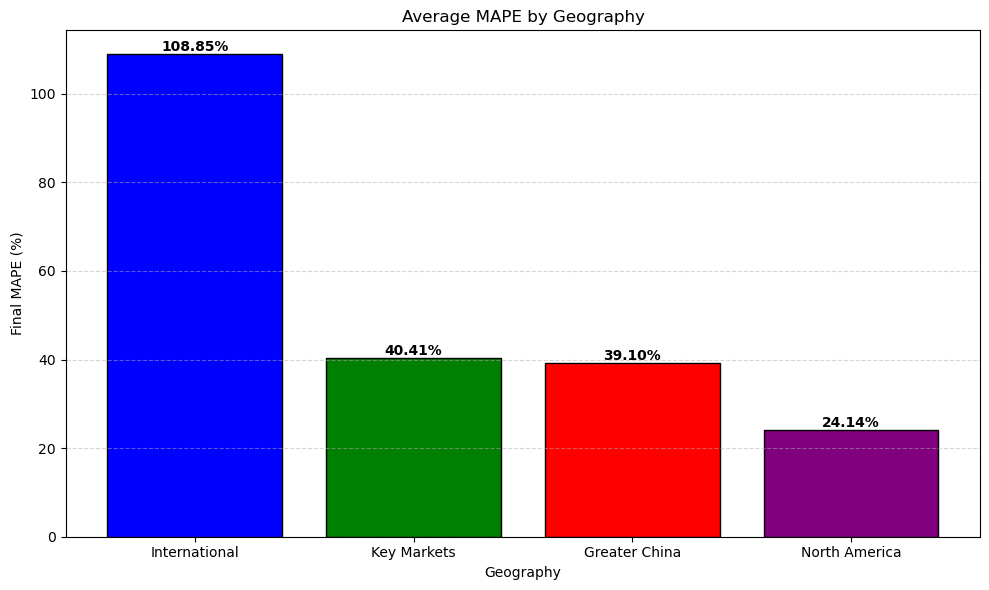

In [553]:

# Group by geography and calculate average final MAPE
avg_mape_geo = df_all.groupby('geography')['mape'].mean().sort_values(ascending=False)

# Define custom colors for key regions
geo_colors = {
    'Greater China': 'red',
    'International': 'blue',
    'Key Markets': 'green',
    'North America': 'purple'
}
bar_colors = [geo_colors.get(geo, 'gray') for geo in avg_mape_geo.index]

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(avg_mape_geo.index, avg_mape_geo.values, color=bar_colors, edgecolor='black')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0,
        f'{height:.2f}%',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Final touches
plt.title('Average MAPE by Geography')
plt.xlabel('Geography')
plt.ylabel('Final MAPE (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [137]:
df_all[['mape', 'coverage_months', 'sales', 'absolute_error']].corr()


mape  coverage_months     sales  absolute_error
mape             1.000000        -0.005211 -0.005109        0.018291
coverage_months -0.005211         1.000000 -0.047036       -0.051929
sales           -0.005109        -0.047036  1.000000        0.718663
absolute_error   0.018291        -0.051929  0.718663        1.000000

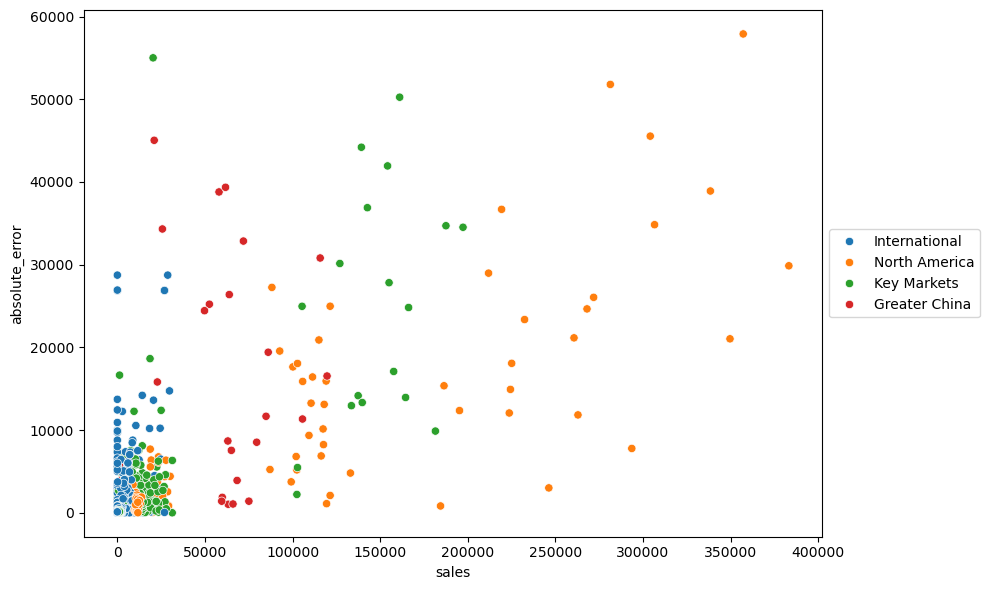

In [139]:
# Set a larger figure size
plt.figure(figsize=(10, 6))  # Adjust width and height as needed

# Create the scatterplot
sns.scatterplot(data=df_all, x='sales', y='absolute_error', hue='geography')

# Move the legend to the right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Apply tight layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()


Key Observations

Sales vs. Error Relationship 
* There's a weak positive trend—higher sales don’t necessarily correspond to lower absolute errors. 
* Some high-sales regions still show notable prediction errors.

Regional Patterns
* North America (orange) shows a wide spread in absolute error, indicating inconsistency in model performance.
* Greater China (red) tends to cluster toward lower sales and lower errors—potentially a more stable segment.
* International (blue) and Key Markets (green) span a wide range, but International seems to show less error at lower sales levels.

In [142]:
# Group by year and month to calculate average MAPE
monthly_mape = (
    df_all.groupby(['year', 'month'])['mape']
    .mean()
    .reset_index()
    .sort_values(by='mape', ascending=False)
)

# Display top months
top_mape_months = monthly_mape.head(10)
print(top_mape_months)


    year  month        mape
11  2024      6  285.479086
12  2024      7   94.973997
13  2024      8   92.077920
14  2024      9   91.715490
15  2024     10   84.113439
0   2023      7   72.862072
1   2023      8   72.823581
8   2024      3   61.528190
4   2023     11   59.984067
6   2024      1   59.914148


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/1210487264.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_top, x='label', y='mape', palette='Reds_r')


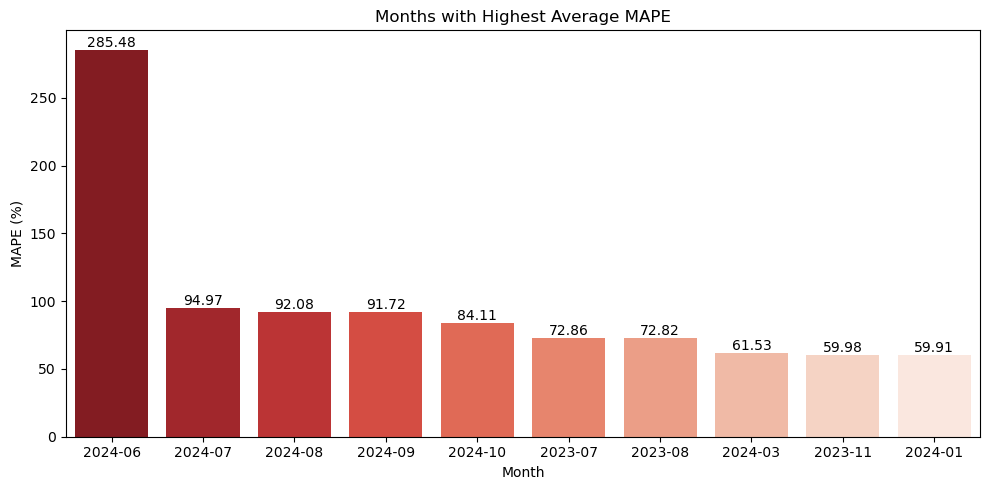

In [144]:
# Top 10 months by average MAPE
plt.figure(figsize=(10, 5))
monthly_top = top_mape_months.copy()
monthly_top['label'] = monthly_top['year'].astype(str) + '-' + monthly_top['month'].astype(str).str.zfill(2)

sns.barplot(data=monthly_top, x='label', y='mape', palette='Reds_r')
plt.title('Months with Highest Average MAPE')
plt.xlabel('Month')
plt.ylabel('MAPE (%)')
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [146]:
# Group by country and calculate average MAPE
country_mape = (
    df_all.groupby('country')['mape']
    .mean()
    .reset_index()
    .sort_values(by='mape', ascending=False)
)

# Display top 5 countries
top_5_countries = country_mape.head(5)
print(top_5_countries)


   country         mape
18      DZ  3024.991833
26      GT   296.457808
20      EG   268.025189
69      VN   267.916818
19      EC   265.963600


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/1946291472.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_countries, x='country', y='mape', palette='Oranges_r')


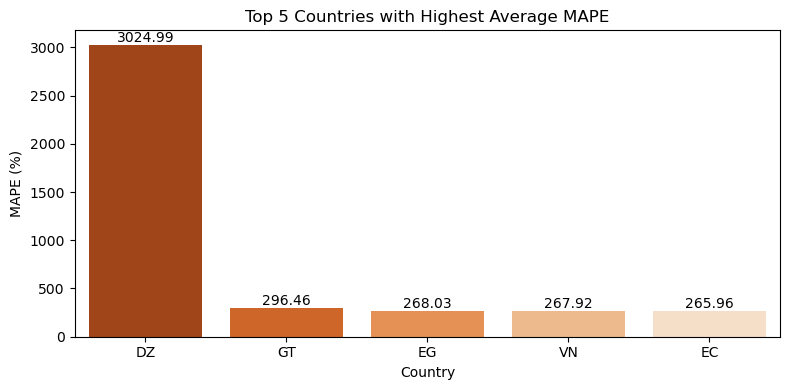

In [148]:
plt.figure(figsize=(8, 4))
sns.barplot(data=top_5_countries, x='country', y='mape', palette='Oranges_r')
plt.title('Top 5 Countries with Highest Average MAPE')
plt.xlabel('Country')
plt.ylabel('MAPE (%)')
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f')
plt.tight_layout()
plt.show()


In [150]:
# Group by product family and calculate MAPE standard deviation
pf_erratic = (
    df_all.groupby('product_family')['mape']
    .std()
    .reset_index()
    .rename(columns={'mape': 'mape_std'})
    .sort_values(by='mape_std', ascending=False)
)

# Display top erratic product families
top_erratic_pf = pf_erratic.head(10)
print(top_erratic_pf)


    product_family     mape_std
7                8  5253.322809
5                6  1114.649852
10              12   794.561047
13              15   391.582635
14              16   318.652624
11              13   308.215771
12              14   277.704613
15              17   256.162643
0                1   196.417134
2                3   177.657865


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/852693064.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_erratic_pf, x='product_family', y='mape_std', palette='Purples')


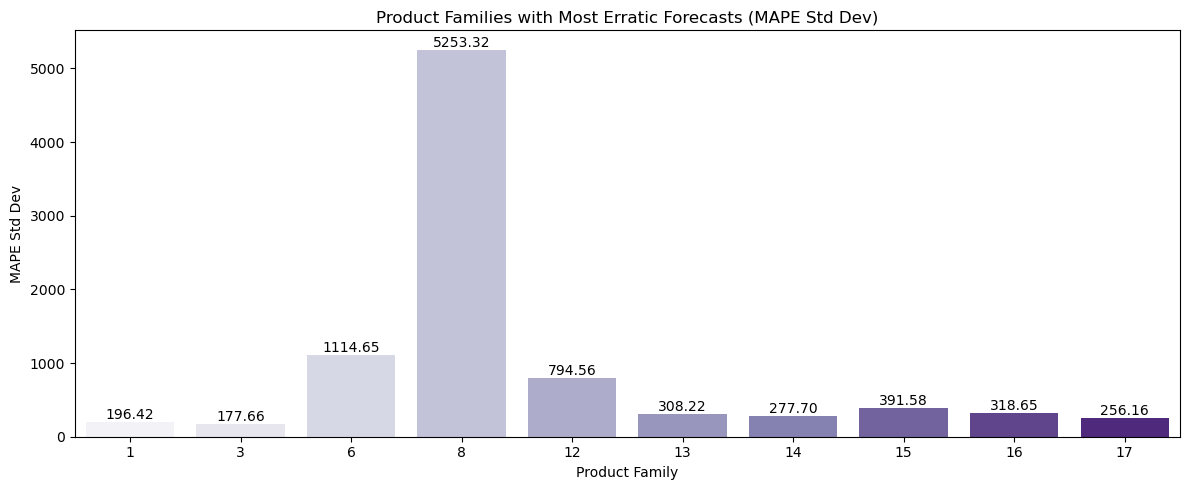

In [152]:
plt.figure(figsize=(12, 5))
sns.barplot(data=top_erratic_pf, x='product_family', y='mape_std', palette='Purples')
plt.title('Product Families with Most Erratic Forecasts (MAPE Std Dev)')
plt.xlabel('Product Family')
plt.ylabel('MAPE Std Dev')
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f')
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/2813710565.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data, x='country', y='mape', palette='viridis')


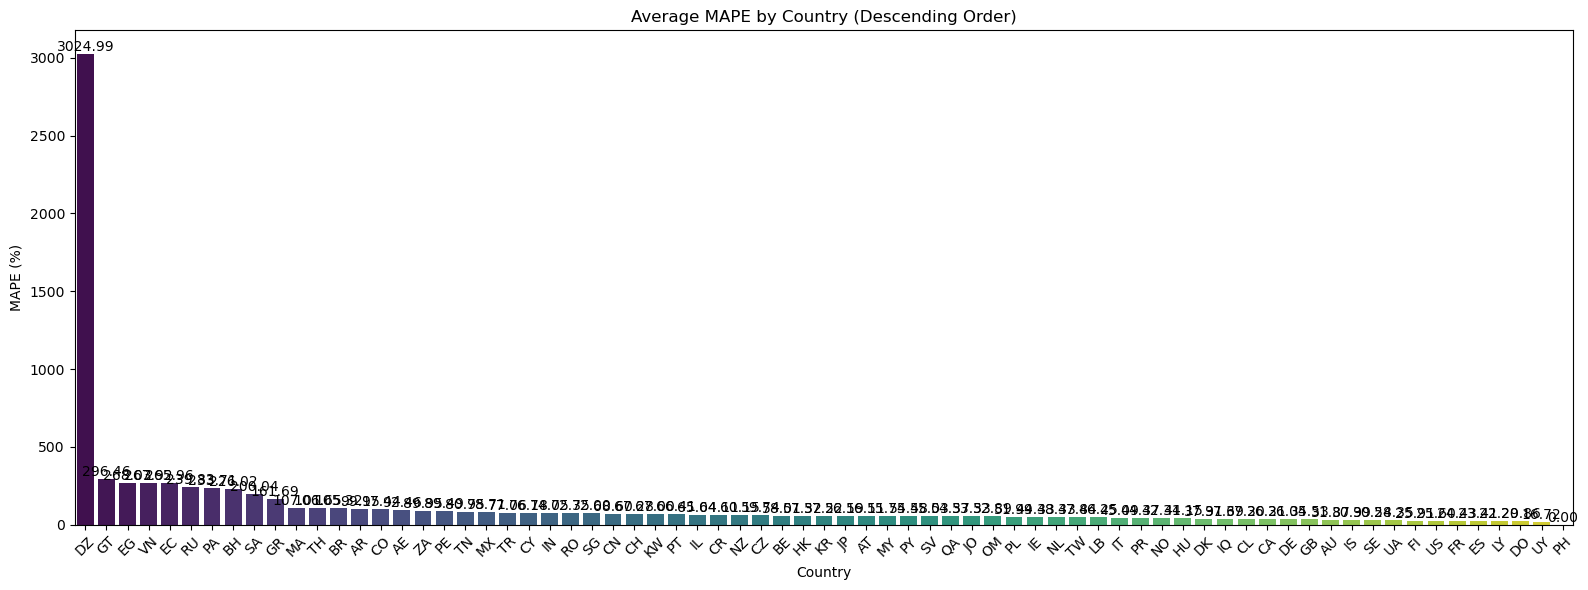

In [154]:
# Calculate average MAPE by country and sort descending
data = (
    df_all.groupby('country')['mape']
    .mean()
    .reset_index()
    .sort_values(by='mape', ascending=False)
)

# Plot bar chart
plt.figure(figsize=(16, 6))
ax = sns.barplot(data=data, x='country', y='mape', palette='viridis')

# Add value labels to bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

plt.title('Average MAPE by Country (Descending Order)')
plt.xlabel('Country')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



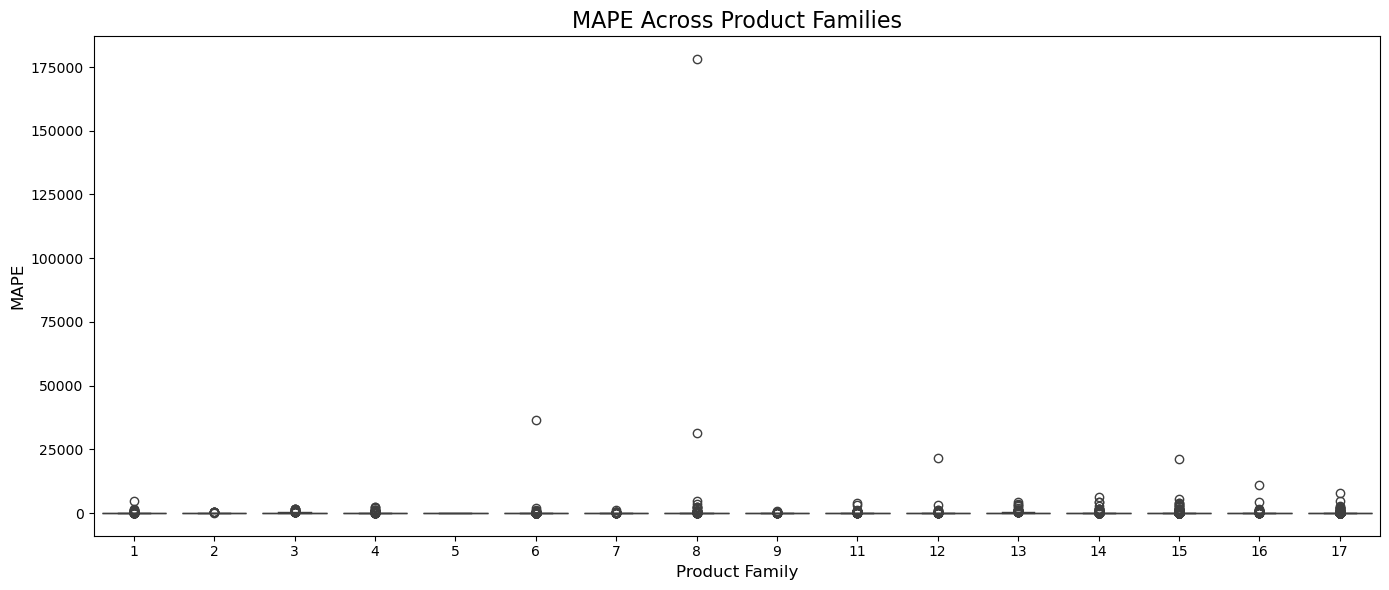

In [156]:
#mape across Product Families

plt.figure(figsize=(14, 6))  # You can adjust width and height as needed
sns.boxplot(x='product_family', y='mape', data=df_all)
plt.title("MAPE Across Product Families", fontsize=16)
plt.xlabel("Product Family", fontsize=12)
plt.ylabel("MAPE", fontsize=12)
plt.xticks(rotation=0)  # Rotating labels often helps with wider plots
plt.tight_layout()
plt.show()



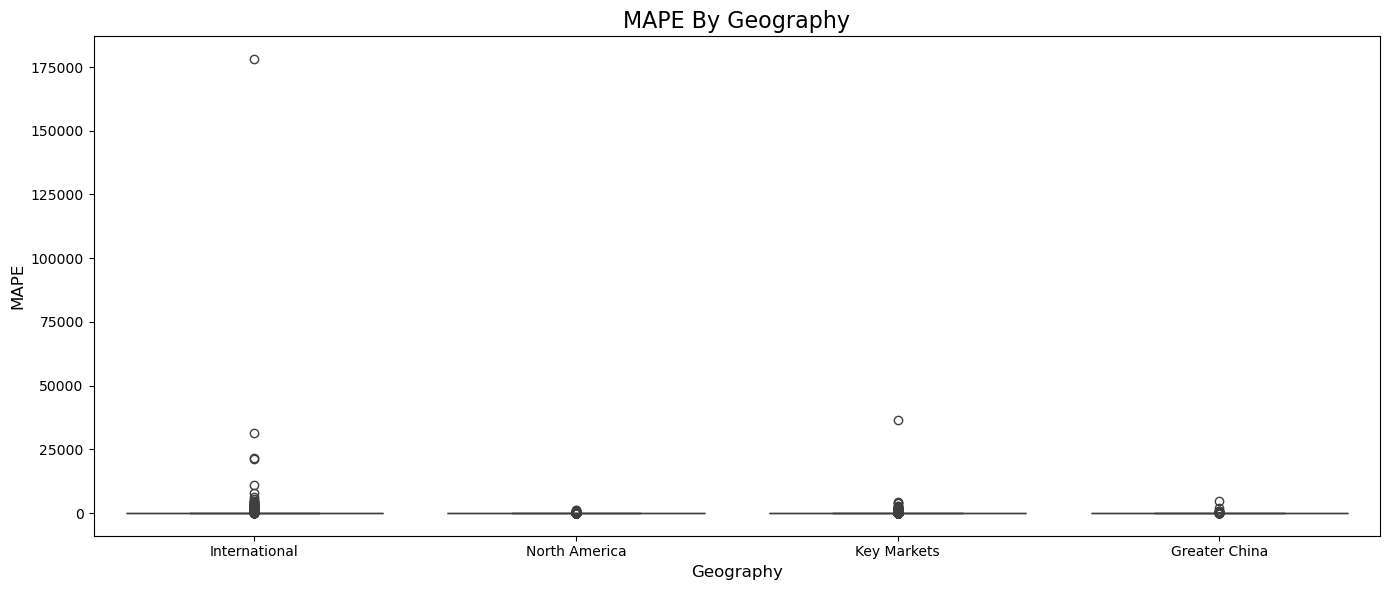

In [158]:
#mape by Geography

plt.figure(figsize=(14, 6))  # You can adjust width and height as needed
sns.boxplot(x='geography', y='mape', data=df_all)
plt.title("MAPE By Geography", fontsize=16)
plt.xlabel("Geography", fontsize=12)
plt.ylabel("MAPE", fontsize=12)
plt.xticks(rotation=0)  # Rotating labels often helps with wider plots
plt.tight_layout()
plt.show()

<Axes: >

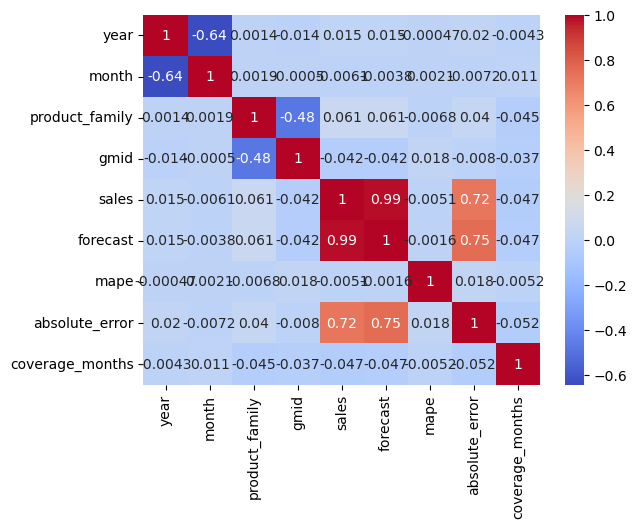

In [160]:
#Correlation Heatmap
correlation = df_all[['year','month','product_family','gmid','sales', 'forecast', 'mape', 'absolute_error','coverage_months']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')


In [162]:
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((series < lower) | (series > upper)).sum()

# Columns to analyze
cols_to_check = ['sales', 'forecast', 'mape']
outlier_counts = {col: count_outliers_iqr(df_all[col].dropna()) for col in cols_to_check}

# Display
pd.Series(outlier_counts, name='Outlier Count')


sales       2097
forecast    2114
mape        1050
Name: Outlier Count, dtype: int64

* sales - around 12% - Moderate; could cap or transform.  
* forecast - around 12% - Similar to sales; likely due to erratic predictions.
* mape - around 6% - Many MAPE outliers reflect high error (often from small sales).

### Log transformation and segmentation

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/829418658.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='log_segment', data=df_active, palette='summer')


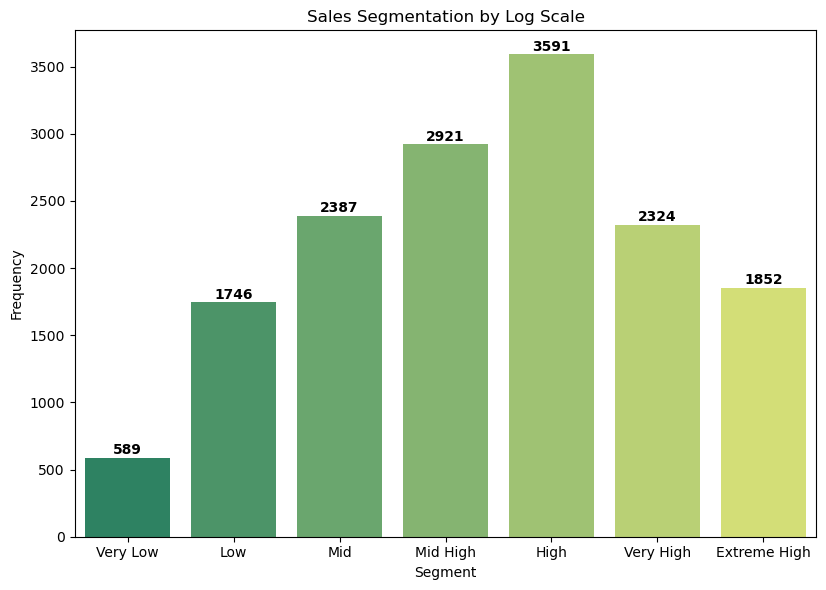

In [166]:
#consider only sales >0

df_active = df_all[df_all['sales'] > 0].copy()


# Log transformation and segmentation
df_active['log_sales'] = np.log1p(df_active['sales']) 
df_active['log_segment'] = pd.cut(df_active['log_sales'], 
                                bins=[-np.inf, 1.8, 3.2, 4.2, 5.2, 6.5, 7.5, np.inf],
                                labels=[
                                    'Very Low',     # ~0–6 sales
                                    'Low',          # ~6–23
                                    'Mid',           # ~23–66
                                    'Mid High',      # ~66–178
                                    'High',          # ~179–665
                                    'Very High',     # ~666–1800
                                    'Extreme High'   # >1800
                                ])

# Plotting both segmentation strategies side-by-side

plt.figure(figsize=(16, 6))

# Create the countplot
plt.subplot(1, 2, 2)
ax = sns.countplot(x='log_segment', data=df_active, palette='summer')

# Title and labels
plt.title('Sales Segmentation by Log Scale')
plt.xlabel('Segment')
plt.ylabel('Frequency')

# Add value labels on top of each bar
for bar in ax.patches:
    count = int(bar.get_height())
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y + 5, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


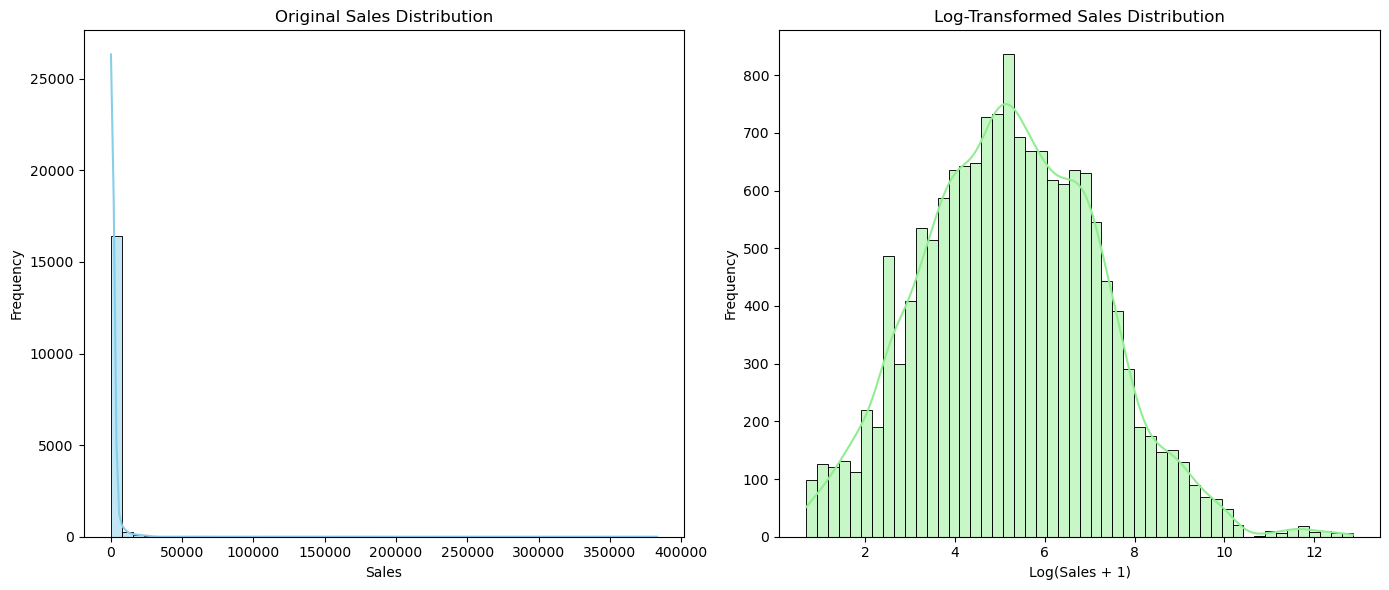

In [168]:
# Plot original vs log-transformed sales
plt.figure(figsize=(14, 6))

# Original sales distribution
plt.subplot(1, 2, 1)
sns.histplot(df_all['sales'], bins=50, kde=True, color='skyblue')
plt.title('Original Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Log-transformed sales distribution
plt.subplot(1, 2, 2)
sns.histplot(df_active['log_sales'], bins=50, kde=True, color='lightgreen')
plt.title('Log-Transformed Sales Distribution')
plt.xlabel('Log(Sales + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/208892852.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_segment = df_active.groupby('log_segment')['mape'].mean().reindex(segment_order)
/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/208892852.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_active, x='log_segment', order=segment_order, palette='viridis')


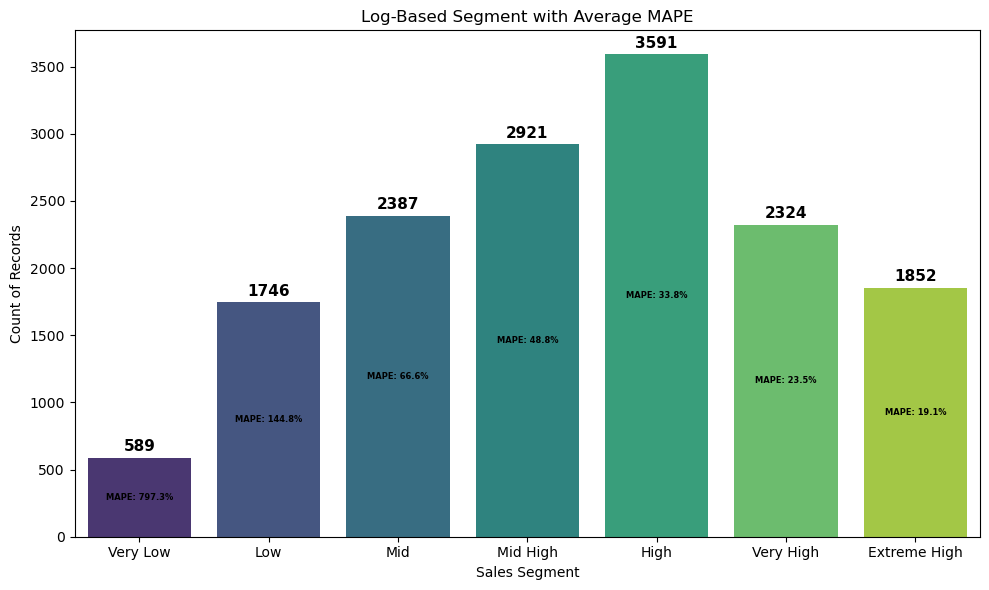

In [569]:

# Ensure 'log_segment' exists and is correctly ordered
segment_order = ['Very Low', 'Low', 'Mid', 'Mid High', 'High', 'Very High', 'Extreme High']

# Calculate average MAPE by log segment (using df_active)
mape_by_segment = df_active.groupby('log_segment')['mape'].mean().reindex(segment_order)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_active, x='log_segment', order=segment_order, palette='viridis')

# Annotate each bar with count and MAPE
for p, segment_name in zip(ax.patches, segment_order):
    height = p.get_height()
    xpos = p.get_x() + p.get_width() / 2.

    # Add count label above the bar
    ax.text(xpos, height + 50, f'{int(height)}', ha='center', fontsize=11, fontweight='bold')

    # Add MAPE label inside the bar
    mape_val = mape_by_segment.get(segment_name, np.nan)
    ax.text(xpos, height / 2, f'MAPE: {mape_val:.1f}%', ha='center', va='center',
            fontsize=6, color='black', fontweight='bold')

# Formatting
plt.title("Log-Based Segment with Average MAPE")
plt.xlabel("Sales Segment")
plt.ylabel("Count of Records")
plt.tight_layout()
plt.show()



* High volume products have the lowest average MAPE —  forecasts are relatively more accurate.
* Low volume products have a higher MAPE — forecasts are less accurate.

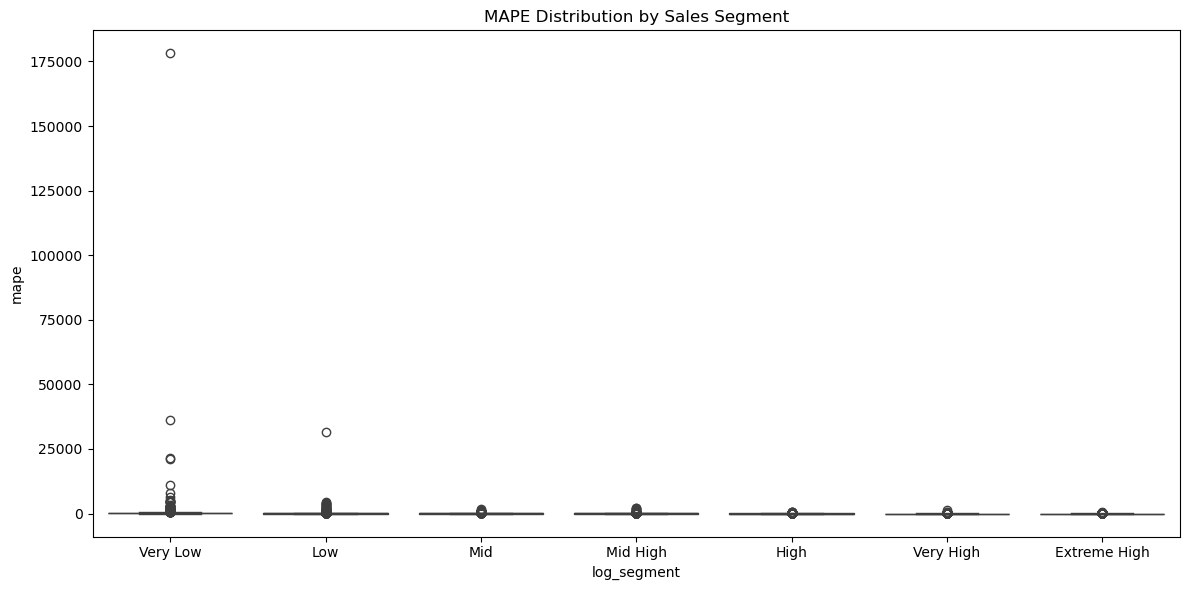

In [173]:

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_active, x='log_segment', y='mape')
plt.title('MAPE Distribution by Sales Segment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/4150017118.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_active, x='pf_segmentation', y='mape', palette='Set3')


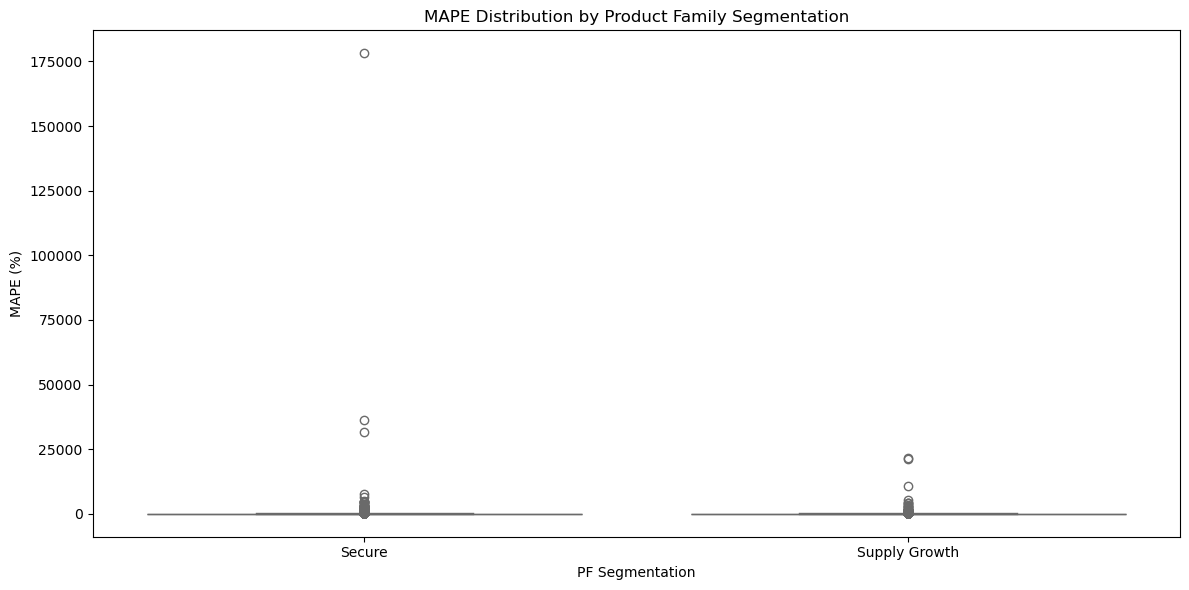

In [175]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_active, x='pf_segmentation', y='mape', palette='Set3')
plt.title('MAPE Distribution by Product Family Segmentation')
plt.xlabel('PF Segmentation')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/759368735.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_active, x='market_segmentation', y='mape', palette='Pastel1')


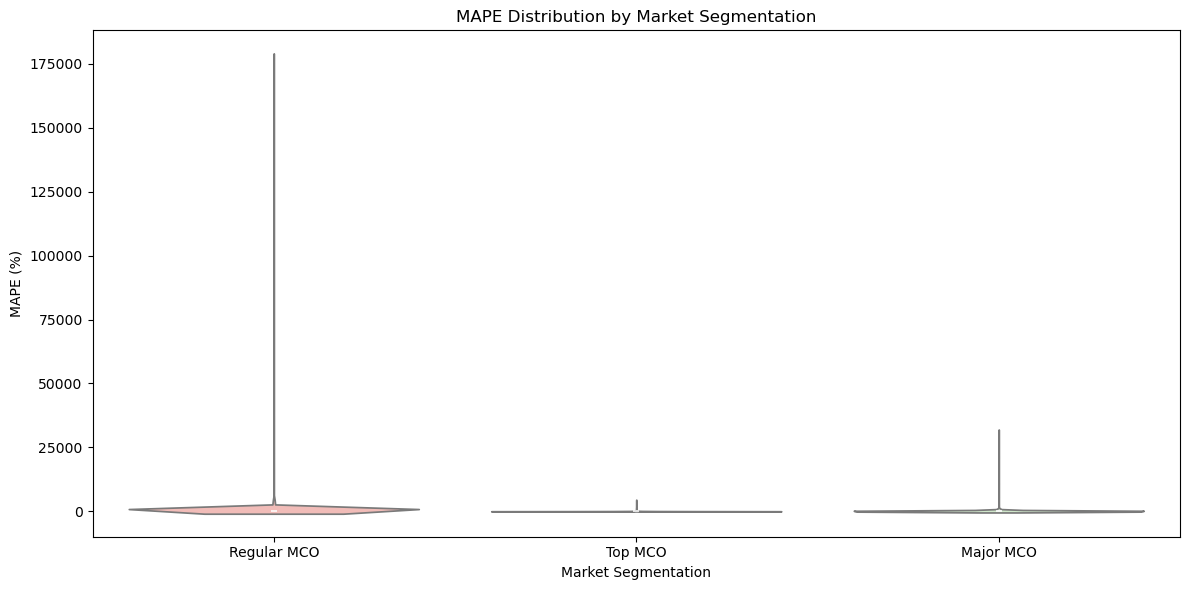

In [177]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_active, x='market_segmentation', y='mape', palette='Pastel1')
plt.title('MAPE Distribution by Market Segmentation')
plt.xlabel('Market Segmentation')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Distribution Patterns

* Regular MCO:
Extremely wide MAPE spread, which suggests high variability in model performance.

* Top MCO & Major MCO:
Both show tighter distributions and much lower MAPE values, indicating more reliable and stable forecasting performance.

In [180]:
# Encode segmentation columns
encoded_df = df_active.copy()
segmentation_cols = ['market_segmentation', 'pf_segmentation', 'gmid_segmentation', 'log_segment']
encoded_df[segmentation_cols] = encoded_df[segmentation_cols].astype('category').apply(lambda x: x.cat.codes)

correlation_matrix = encoded_df[['mape'] + segmentation_cols].corr()
correlation_matrix['mape']

mape                   1.000000
market_segmentation   -0.022248
pf_segmentation       -0.006624
gmid_segmentation     -0.005900
log_segment           -0.057726
Name: mape, dtype: float64

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/3238903823.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_active.groupby(['market_segmentation','log_segment'])['mape']


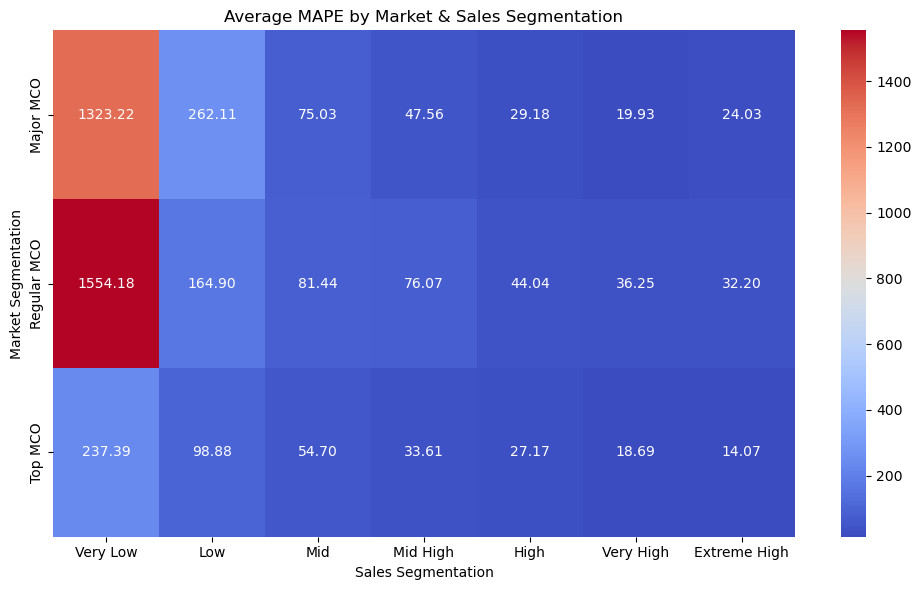

In [182]:
heatmap_df = (
    df_active.groupby(['market_segmentation','log_segment'])['mape']
    .mean()
    .unstack()
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average MAPE by Market & Sales Segmentation')
plt.xlabel('Sales Segmentation')
plt.ylabel('Market Segmentation')
plt.tight_layout()
plt.show()

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/410807241.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_active.groupby(['product_family','log_segment'])['mape']


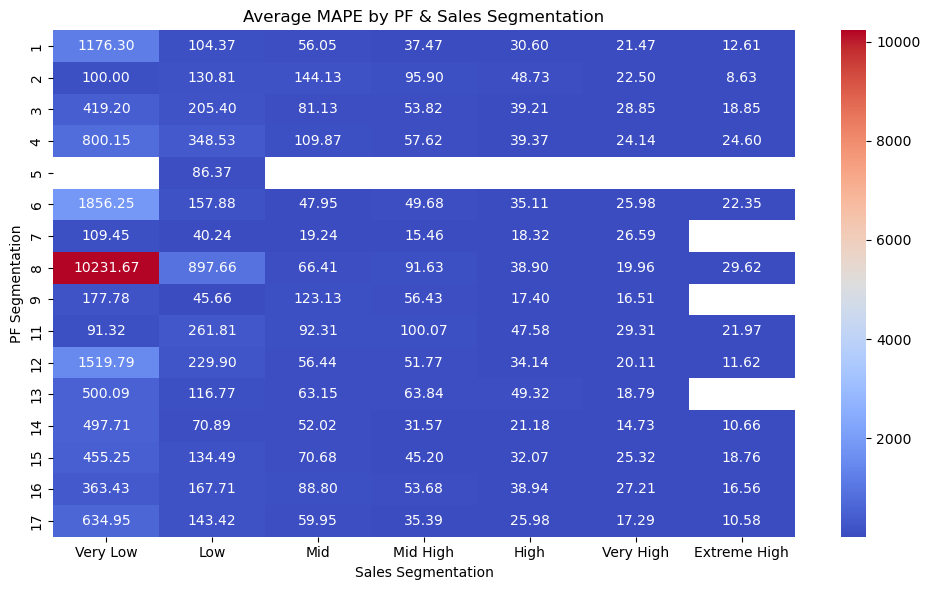

In [184]:
heatmap_df = (
    df_active.groupby(['product_family','log_segment'])['mape']
    .mean()
    .unstack()
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average MAPE by PF & Sales Segmentation')
plt.xlabel('Sales Segmentation')
plt.ylabel('PF Segmentation')
plt.tight_layout()
plt.show()

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/3197969833.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_active.groupby(['pf_segmentation', 'market_segmentation','log_segment'])['mape']


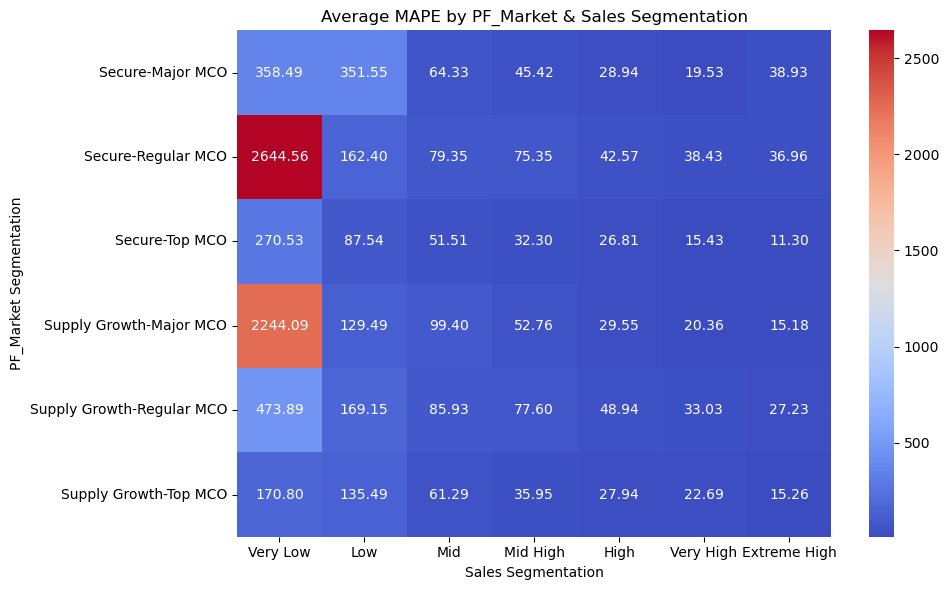

In [186]:
heatmap_df = (
    df_active.groupby(['pf_segmentation', 'market_segmentation','log_segment'])['mape']
    .mean()
    .unstack()
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average MAPE by PF_Market & Sales Segmentation')
plt.xlabel('Sales Segmentation')
plt.ylabel('PF_Market Segmentation')
plt.tight_layout()
plt.show()


In [188]:
#Combine segmentation columns into hybrid features
df_active['seg_combo'] = df_all['pf_segmentation'] + '_' + df_all['market_segmentation']


In [190]:
df_active.columns

Index(['gmid_key', 'date', 'year', 'month', 'product_family', 'gmid',
       'country', 'market', 'geography', 'sales', 'forecast', 'mape',
       'absolute_error', 'coverage_months', 'min', 'max',
       'market_segmentation', 'pf_segmentation', 'gmid_segmentation',
       'log_sales', 'log_segment', 'seg_combo'],
      dtype='object')

In [192]:
df_active.drop(columns=['coverage_months', 'min', 'max'], inplace=True)
df_active.head()

gmid_key       date  year  month  product_family    gmid country  \
0  100001_202310_AU 2023-10-01  2023     10               1  100001      AU   
1  100001_202310_NZ 2023-10-01  2023     10               1  100001      NZ   
2  100001_202311_AU 2023-11-01  2023     11               1  100001      AU   
3  100001_202311_NZ 2023-11-01  2023     11               1  100001      NZ   
4  100001_202312_AU 2023-12-01  2023     12               1  100001      AU   

        market      geography  sales  forecast    mape  absolute_error  \
0    Australia  International     93       108   16.13            15.0   
1  New Zealand  International     26        23   11.54             3.0   
2    Australia  International    158        87   44.94            71.0   
3  New Zealand  International      3        23  666.67            20.0   
4    Australia  International     69        88   27.54            19.0   

  market_segmentation pf_segmentation gmid_segmentation  log_sales  \
0         Regular MCO          Secure      Auto Piloted   4.543295   
1         Regular MCO          Secure      Auto Piloted   3.295837   
2         Regular MCO          Secure      Auto Piloted   5.068904   
3         Regular MCO          Secure      Auto Piloted   1.386294   
4         Regular MCO          Secure      Auto Piloted   4.248495   

  log_segment           seg_combo  
0    Mid High  Secure_Regular MCO  
1         Mid  Secure_Regular MCO  
2    Mid High  Secure_Regular MCO  
3    Very Low  Secure_Regular MCO  
4    Mid High  Secure_Regular MCO

In [194]:
# Create lag features
df_active = df_active.sort_values(by=['gmid', 'year', 'month'])
df_active['sales_lag_3'] = df_active.groupby('gmid')['sales'].shift(3)
df_active['forecast_lag_3'] = df_active.groupby('gmid')['forecast'].shift(3)

df_active['sales_lag_3'] = df_active['sales_lag_3'].fillna(0)
df_active['forecast_lag_3'] = df_active['forecast_lag_3'].fillna(0)


In [196]:
df_active.head()

gmid_key       date  year  month  product_family    gmid country  \
6   100001_20237_AU 2023-07-01  2023      7               1  100001      AU   
7   100001_20237_NZ 2023-07-01  2023      7               1  100001      NZ   
8   100001_20238_AU 2023-08-01  2023      8               1  100001      AU   
9   100001_20238_NZ 2023-08-01  2023      8               1  100001      NZ   
10  100001_20239_AU 2023-09-01  2023      9               1  100001      AU   

         market      geography  sales  ...    mape  absolute_error  \
6     Australia  International     75  ...   36.00            27.0   
7   New Zealand  International     29  ...   24.14             7.0   
8     Australia  International     66  ...   57.58            38.0   
9   New Zealand  International     26  ...   38.46            10.0   
10    Australia  International     48  ...  120.83            58.0   

    market_segmentation pf_segmentation gmid_segmentation log_sales  \
6           Regular MCO          Secure      Auto Piloted  4.330733   
7           Regular MCO          Secure      Auto Piloted  3.401197   
8           Regular MCO          Secure      Auto Piloted  4.204693   
9           Regular MCO          Secure      Auto Piloted  3.295837   
10          Regular MCO          Secure      Auto Piloted  3.891820   

    log_segment           seg_combo sales_lag_3  forecast_lag_3  
6      Mid High  Secure_Regular MCO         0.0             0.0  
7           Mid  Secure_Regular MCO         0.0             0.0  
8      Mid High  Secure_Regular MCO         0.0             0.0  
9           Mid  Secure_Regular MCO        75.0           102.0  
10          Mid  Secure_Regular MCO        29.0            36.0  

[5 rows x 21 columns]

# Machine Learning

### Train Test Split

In [200]:
features = ['sales_lag_3', 'forecast_lag_3', 'log_sales', 'seg_combo']
X = pd.get_dummies(df_active[features])
y = df_active['sales']


In [202]:
X.head()

sales_lag_3  forecast_lag_3  log_sales  seg_combo_Secure_Major MCO  \
6           0.0             0.0   4.330733                       False   
7           0.0             0.0   3.401197                       False   
8           0.0             0.0   4.204693                       False   
9          75.0           102.0   3.295837                       False   
10         29.0            36.0   3.891820                       False   

    seg_combo_Secure_Regular MCO  seg_combo_Secure_Top MCO  \
6                           True                     False   
7                           True                     False   
8                           True                     False   
9                           True                     False   
10                          True                     False   

    seg_combo_Supply Growth_Major MCO  seg_combo_Supply Growth_Regular MCO  \
6                               False                                False   
7                               False                                False   
8                               False                                False   
9                               False                                False   
10                              False                                False   

    seg_combo_Supply Growth_Top MCO  
6                             False  
7                             False  
8                             False  
9                             False  
10                            False

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

### Scalling

In [207]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [209]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [211]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_train_scaled.head()

sales_lag_3  forecast_lag_3  log_sales  seg_combo_Secure_Major MCO  \
0     0.088410        0.044748   1.279872                   -0.264135   
1     0.072298        0.086493  -0.349675                   -0.264135   
2    -0.114374       -0.130193  -0.946692                   -0.264135   
3    -0.098695       -0.107330   0.148003                   -0.264135   
4    -0.130399       -0.129770  -1.266493                   -0.264135   

   seg_combo_Secure_Regular MCO  seg_combo_Secure_Top MCO  \
0                     -0.527674                 -0.718452   
1                      1.895108                 -0.718452   
2                     -0.527674                 -0.718452   
3                     -0.527674                 -0.718452   
4                      1.895108                 -0.718452   

   seg_combo_Supply Growth_Major MCO  seg_combo_Supply Growth_Regular MCO  \
0                          -0.208797                            -0.353295   
1                          -0.208797                            -0.353295   
2                          -0.208797                             2.830494   
3                          -0.208797                            -0.353295   
4                          -0.208797                            -0.353295   

   seg_combo_Supply Growth_Top MCO  
0                         1.862333  
1                        -0.536961  
2                        -0.536961  
3                         1.862333  
4                        -0.536961

In [213]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_test_scaled.head()

sales_lag_3  forecast_lag_3  log_sales  seg_combo_Secure_Major MCO  \
0    -0.096356       -0.097847   0.421885                   -0.264135   
1    -0.127194       -0.126383  -0.189096                   -0.264135   
2    -0.130659       -0.130193   0.918857                   -0.264135   
3    -0.129706       -0.128923  -1.039447                   -0.264135   
4    -0.082930       -0.091496   0.358209                   -0.264135   

   seg_combo_Secure_Regular MCO  seg_combo_Secure_Top MCO  \
0                     -0.527674                 -0.718452   
1                     -0.527674                  1.391882   
2                     -0.527674                 -0.718452   
3                      1.895108                 -0.718452   
4                     -0.527674                  1.391882   

   seg_combo_Supply Growth_Major MCO  seg_combo_Supply Growth_Regular MCO  \
0                          -0.208797                            -0.353295   
1                          -0.208797                            -0.353295   
2                          -0.208797                            -0.353295   
3                          -0.208797                            -0.353295   
4                          -0.208797                            -0.353295   

   seg_combo_Supply Growth_Top MCO  
0                         1.862333  
1                        -0.536961  
2                         1.862333  
3                        -0.536961  
4                        -0.536961

#### Linear regression

In [216]:

# Initialize the model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train_scaled, y_train)

# Predict
pred_lin = lin_reg.predict(X_test_scaled)

# Evaluate performance
r2_lin = r2_score(y_test, pred_lin)
mae_lin = mean_absolute_error(y_test, pred_lin)
rmse_lin = root_mean_squared_error(y_test, pred_lin)
mape_lin = mean_absolute_percentage_error(y_test, pred_lin)


print(f"R² Score: {r2_lin:.3f}")
print(f"MAE: {mae_lin:.2f}")
print(f"RMSE: {rmse_lin:.2f}")
print(f"MAPE: {mape_lin:.2%}")

R² Score: 0.109
MAE: 3255.47
RMSE: 10471.04
MAPE: 16989.26%


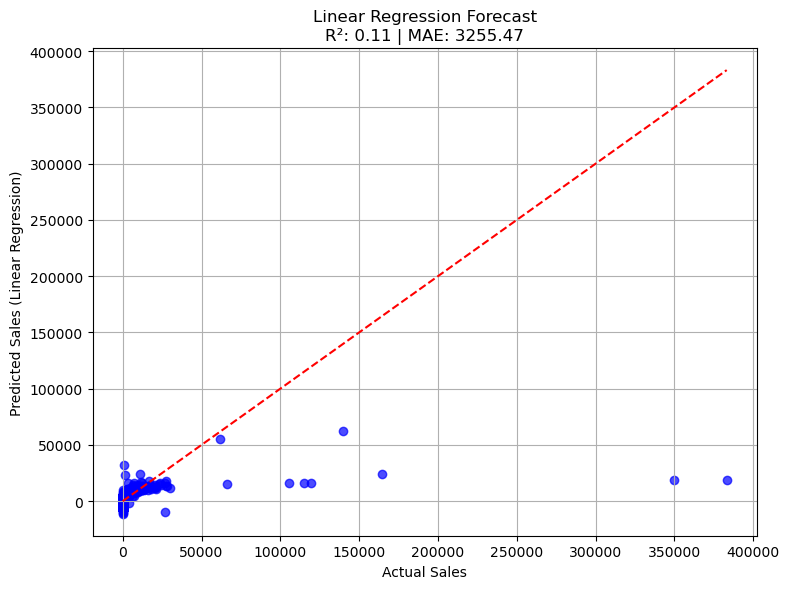

In [218]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_lin, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales (Linear Regression)')
plt.title(f'Linear Regression Forecast\nR²: {r2_lin:.2f} | MAE: {mae_lin:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

#### KNN

In [221]:
# Train KNN model
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train_scaled, y_train)

# Predict on test data
pred_knn = knn.predict(X_test_scaled)

# Evaluate
print("MAE", mean_absolute_error(pred_knn, y_test))
print("RMSE", root_mean_squared_error(pred_knn, y_test))
print("R2 score", knn.score(X_test_scaled, y_test))
print("MAPE", mean_absolute_percentage_error(pred_knn, y_test))


MAE 171.640233614536
RMSE 2754.472417544533
R2 score 0.9383405938456872
MAPE 0.01681772984114608


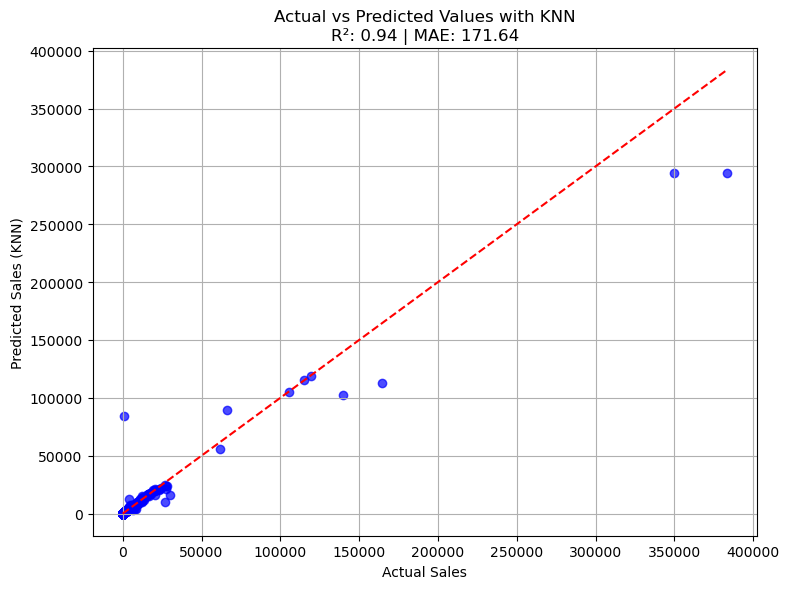

In [223]:
r2_knn = r2_score(y_test, pred_knn)
mae_knn = mean_absolute_error(y_test, pred_knn)


plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_knn, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales (KNN)')
plt.title(f'Actual vs Predicted Values with KNN\nR²: {r2_knn:.2f} | MAE: {mae_knn:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()


#### RandomForest

In [226]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=20)
rf_model.fit(X_train_scaled, y_train)
pred_rf = rf_model.predict(X_test_scaled)

print("MAE", mean_absolute_error(pred_rf, y_test))
print("RMSE", root_mean_squared_error(pred_rf, y_test))
print("R2 score", rf_model.score(X_test_scaled, y_test))
print("MAPE", mean_absolute_percentage_error(pred_rf, y_test))

MAE 28.95463984425698
RMSE 1012.0994891720302
R2 score 0.9916752942170158
MAPE 0.0003430294150062327


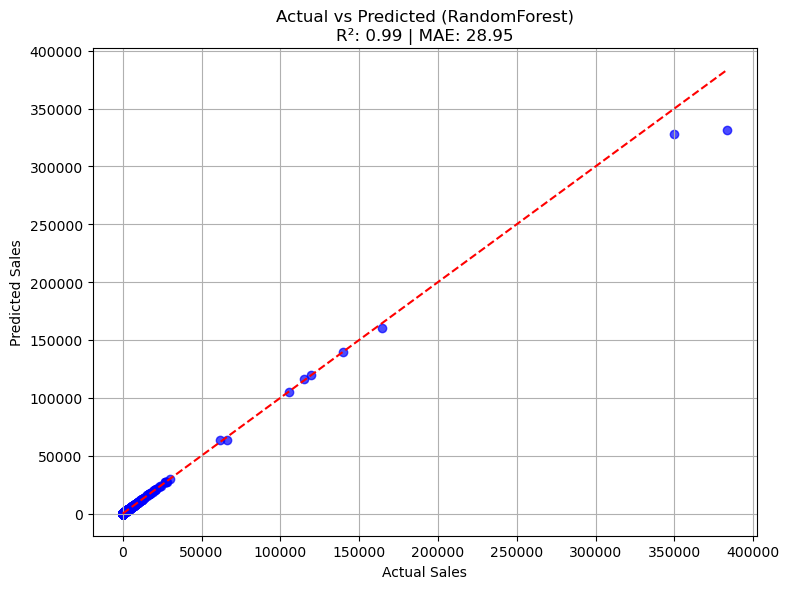

In [227]:
# Plot actual vs predicted

r2 = r2_score(y_test, pred_rf)
mae = mean_absolute_error(y_test, pred_rf)

plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_rf, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect fit line

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted (RandomForest)\nR²: {r2:.2f} | MAE: {mae:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Gradient Boosting

In [231]:
gb_reg = GradientBoostingRegressor(max_depth=6, n_estimators=100, random_state=20)
gb_reg.fit(X_train_scaled, y_train)

# Predict and evaluate
pred_gb = gb_reg.predict(X_test_scaled)
mae_pred_gb = mean_absolute_error(y_test, pred_gb)
rmse_pred_gb = root_mean_squared_error(y_test, pred_gb)
r2_pred_gb = gb_reg.score(X_test_scaled, y_test)
mape_pred_gb = mean_absolute_percentage_error(y_test, pred_gb)

print("MAE:", mae_pred_gb)
print("RMSE:", rmse_pred_gb)
print("R2 Score:", r2_pred_gb)
print("MAPE", mape_pred_gb)

MAE: 21.372029563031997
RMSE: 726.0055911269762
R2 Score: 0.9957164640842743
MAPE 0.021577476132796803


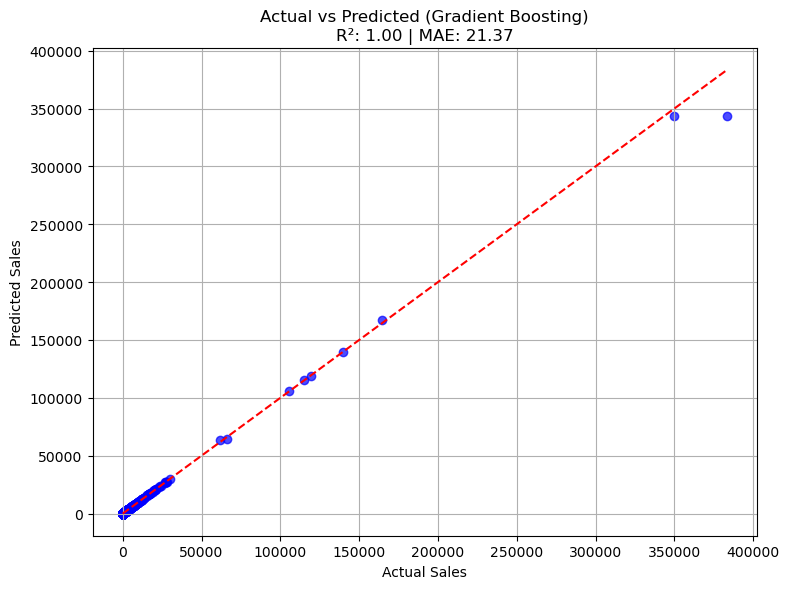

In [233]:
# Plot actual vs predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_gb, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect fit line

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted (Gradient Boosting)\nR²: {r2_pred_gb:.2f} | MAE: {mae_pred_gb:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

#### XGBoost

In [236]:
# Initialize XGBoost model
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

xgb_reg.fit(X_train, y_train)

# Evaluate
pred_xgb = xgb_reg.predict(X_test)


print("XGBoost MAE:", mean_absolute_error(y_test, pred_xgb))
print("XGBoost RMSE:", root_mean_squared_error(y_test, pred_xgb))
print("XGBoost R²:", r2_score(y_test, pred_xgb))
print("MAPE", mean_absolute_percentage_error(y_test, pred_xgb))

XGBoost MAE: 123.98009596878178
XGBoost RMSE: 2152.57939657046
XGBoost R²: 0.9623433947563171
MAPE 0.31557026446737374


#### AdaBoost Regressor

In [239]:
# Initialize AdaBoost
ada_reg = AdaBoostRegressor(n_estimators=100, learning_rate=0.5, random_state=42)

# Train
ada_reg.fit(X_train_scaled, y_train)

# Predict and Evaluate
pred_ada = ada_reg.predict(X_test_scaled)
print("AdaBoost MAE:", mean_absolute_error(y_test, pred_ada))
print("AdaBoost RMSE:", root_mean_squared_error(y_test, pred_ada))
print("AdaBoost R²:", r2_score(y_test, pred_ada))
print("MAPE", mean_absolute_percentage_error(y_test, pred_ada))

AdaBoost MAE: 1015.503945494701
AdaBoost RMSE: 1549.761660007405
AdaBoost R²: 0.9804812362672464
MAPE 33.48319348151354


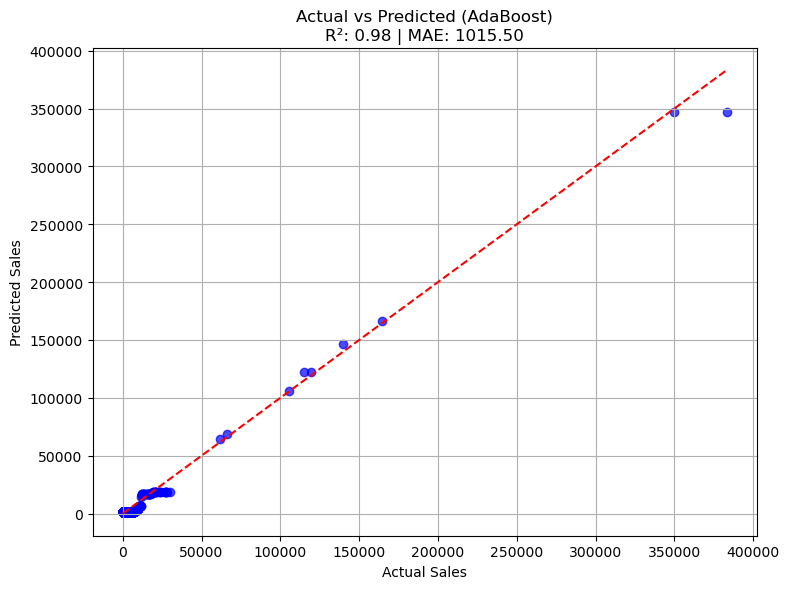

In [241]:
# Plot actual vs predicted

r2_ada = r2_score(y_test, pred_ada)
mae_ada = mean_absolute_error(y_test, pred_ada)

plt.figure(figsize=(8,6))
plt.scatter(y_test, pred_ada, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect fit line

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted (AdaBoost)\nR²: {r2_ada:.2f} | MAE: {mae_ada:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Bagging Regressor

In [244]:

# Initialize Bagging
bag_reg = BaggingRegressor(n_estimators=100, random_state=42)

# Train
bag_reg.fit(X_train_scaled, y_train)

# Predict and Evaluate
pred_bag = bag_reg.predict(X_test_scaled)
print("Bagging MAE:", mean_absolute_error(y_test, pred_bag))
print("Bagging RMSE:", mean_squared_error(y_test, pred_bag, squared=False))
print("Bagging R²:", r2_score(y_test, pred_bag))
print("MAPE", mean_absolute_percentage_error(y_test, pred_bag))

Bagging MAE: 27.97651524983779
Bagging RMSE: 967.0822367579494
Bagging R²: 0.9923993751961079
MAPE 0.0003358789608498299


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


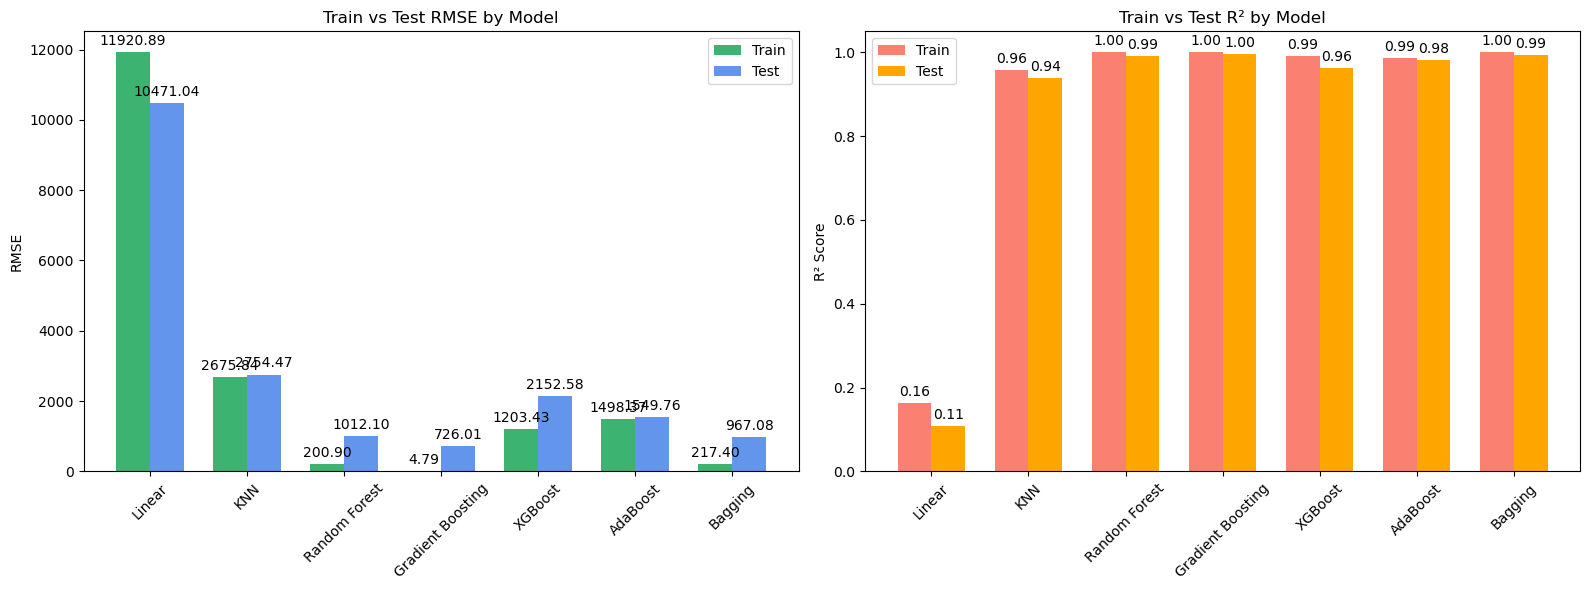

In [245]:

# Define models and predictions
model_names = ['Linear', 'KNN', 'Random Forest', 'Gradient Boosting','XGBoost', 'AdaBoost', 'Bagging']
models = [lin_reg, knn, rf_model, gb_reg, xgb_reg, ada_reg, bag_reg]

# Collect metrics dynamically
rmse_train = [
    root_mean_squared_error(y_train, model.predict(X_train if model == xgb_reg else X_train_scaled))
    for model in models
]
rmse_test = [
    root_mean_squared_error(y_test, model.predict(X_test if model == xgb_reg else X_test_scaled))
    for model in models
]
r2_train = [
    r2_score(y_train, model.predict(X_train if model == xgb_reg else X_train_scaled))
    for model in models
]

r2_test = [
    r2_score(y_test, model.predict(X_test if model == xgb_reg else X_test_scaled))
    for model in models
]



# Bar chart setup
x = np.arange(len(model_names))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison
rects1 = ax1.bar(x - width/2, rmse_train, width, label='Train', color='mediumseagreen')
rects2 = ax1.bar(x + width/2, rmse_test,  width, label='Test',  color='cornflowerblue')
ax1.set_ylabel('RMSE')
ax1.set_title('Train vs Test RMSE by Model')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)
ax1.legend()

# R² comparison
rects3 = ax2.bar(x - width/2, r2_train, width, label='Train', color='salmon')
rects4 = ax2.bar(x + width/2, r2_test,  width, label='Test',  color='orange')
ax2.set_ylabel('R² Score')
ax2.set_title('Train vs Test R² by Model')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45)
ax2.legend()

# Annotate bars with values
def annotate_bars(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(ax1, rects1)
annotate_bars(ax1, rects2)
annotate_bars(ax2, rects3)
annotate_bars(ax2, rects4)

plt.tight_layout()
plt.show()


* AdaBoost - smallest difference between training and testing metrics. It’s a strong candidate if the goal is robustness
* Gradient Boosting - lowest error
* Bagging and Random Forest - good R2

In [249]:
#cross validation
# Initialize models
gb_model = GradientBoostingRegressor(random_state=42)
ada_model = AdaBoostRegressor(random_state=42)

# Run 5-fold cross-validation
gb_scores = cross_val_score(gb_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
ada_scores = cross_val_score(ada_model, X, y, cv=5, scoring='neg_root_mean_squared_error')

# Convert to positive RMSE
print("Gradient Boosting CV RMSE:", -gb_scores.mean())
print("AdaBoost CV RMSE:", -ada_scores.mean())


Gradient Boosting CV RMSE: 1802.3915021574321
AdaBoost CV RMSE: 2902.027397517434


* Gradient Boosting is outperforming AdaBoost quite decisively in cross-validation, with a much lower RMSE.
* While AdaBoost looked promising in terms of stability between train and test, Gradient Boosting has the edge in predictive precision across folds.
* Gradient Boosting is your most efficient learner for this task, especially if your goal is minimizing forecast error.


### Hyperparameter Tuning

#### Gradient Boosting

In [255]:
#Define hyperparameter distribution (use reasonable ranges to avoid too large a search space)
Parameter_Trials = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'subsample': [0.3, 0.5]
}

# Perform RandomizedSearchCV
model = RandomizedSearchCV(gb_reg, Parameter_Trials, n_iter = 10, cv = 5, n_jobs = -1, random_state=20)

# Fit the model
model.fit(X_train_scaled,y_train)

RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingRegressor(max_depth=6,
                                                       random_state=20),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [6, 8, 10],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': [100, 150, 200],
                                        'subsample': [0.3, 0.5]},
                   random_state=20)

In [256]:
# Get the best hyperparameters
best_gb_params = model.best_params_
best_gb_params

{'subsample': 0.5,
 'n_estimators': 100,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 8,
 'learning_rate': 0.1}

In [257]:
# Get the best model
best_model = model.best_estimator_

In [258]:
# Evaluate the best model on the test set
best_pred_gb = best_model.predict(X_test_scaled)

print("MAE", mean_absolute_error(best_pred_gb, y_test))
print("RMSE", mean_squared_error(best_pred_gb, y_test, squared=False))
print("R2 score", best_model.score(X_test_scaled, y_test))
print("MAPE", mean_absolute_percentage_error(best_pred_gb, y_test))

MAE 15.87733555269546
RMSE 557.7056836785029
R2 score 0.9974722587076423
MAPE 0.01414664196701988


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


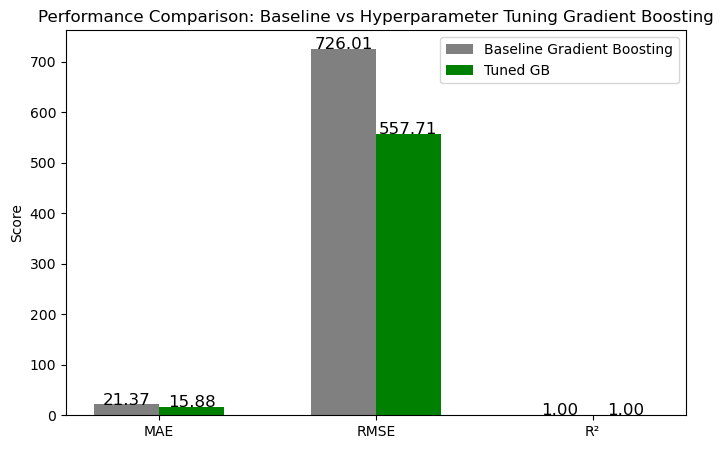

In [259]:
# Define metrics
metrics = ["MAE", "RMSE", "R²"]
baseline_values = [
    mean_absolute_error(pred_gb, y_test),
    mean_squared_error(pred_gb, y_test, squared=False),
    gb_reg.score(X_test_scaled, y_test)
]
tuned_values = [
    mean_absolute_error(y_test, best_pred_gb),
    mean_squared_error(y_test, best_pred_gb, squared=False),
    best_model.score(X_test_scaled, y_test)
]

# Set position of bars
x = np.arange(len(metrics))
width = 0.3

# Create figure
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_values, width, label="Baseline Gradient Boosting", color="grey")
plt.bar(x + width/2, tuned_values, width, label="Tuned GB", color="Green")

# Add labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison: Baseline vs Hyperparameter Tuning Gradient Boosting")
plt.legend(loc="upper right", ncol=1)  # Horizontal legend

# Show values on bars
for i in range(len(metrics)):
    plt.text(i - width/2, baseline_values[i] + 0.02, f"{baseline_values[i]:.2f}", ha='center', fontsize=12)
    plt.text(i + width/2, tuned_values[i] + 0.02, f"{tuned_values[i]:.2f}", ha='center', fontsize=12)

# Show chart
plt.show()


#### AdaBoost

In [266]:
# Define base estimator
base_tree = DecisionTreeRegressor()
# Proper AdaBoost initialization with tree estimator (for scikit-learn ≥1.2)
ada_reg = AdaBoostRegressor(estimator=base_tree, random_state=42)

# Define hyperparameter distribution
Parameter_Trials = {
    'n_estimators': [200, 250, 300],               
    'learning_rate': [0.05, 0.01, 0.02],         
    'estimator__max_depth': [10, 12, 14],           
    'estimator__min_samples_split': [3, 4, 5],   
    'estimator__min_samples_leaf': [1, 2, 3]      
}

# Perform randomized search
model_ab = RandomizedSearchCV(ada_reg, Parameter_Trials, n_iter=10, cv=5, n_jobs=-1,random_state=42)

# Fit the model
model_ab.fit(X_train_scaled, y_train)



RandomizedSearchCV(cv=5,
                   estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(),
                                               random_state=42),
                   n_jobs=-1,
                   param_distributions={'estimator__max_depth': [10, 12, 14],
                                        'estimator__min_samples_leaf': [1, 2,
                                                                        3],
                                        'estimator__min_samples_split': [3, 4,
                                                                         5],
                                        'learning_rate': [0.05, 0.01, 0.02],
                                        'n_estimators': [200, 250, 300]},
                   random_state=42)

In [267]:
# Get the best hyperparameters
best_ada_params= model_ab.best_params_
best_ada_params

{'n_estimators': 300,
 'learning_rate': 0.01,
 'estimator__min_samples_split': 3,
 'estimator__min_samples_leaf': 2,
 'estimator__max_depth': 12}

In [268]:
# After tuning AdaBoost
best_ada_model = model_ab.best_estimator_

In [269]:
# Evaluate the best model on the test set
best_pred_ada = best_ada_model.predict(X_test_scaled)

print("MAE", mean_absolute_error(best_pred_ada, y_test))
print("RMSE", mean_squared_error(best_pred_ada, y_test, squared=False))
print("R2 score", best_ada_model.score(X_test_scaled, y_test))
print("MAPE", mean_absolute_percentage_error(best_pred_ada, y_test))

MAE 23.300241306546887
RMSE 835.1484907428539
R2 score 0.9943317384292927
MAPE 0.010125082628944071


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


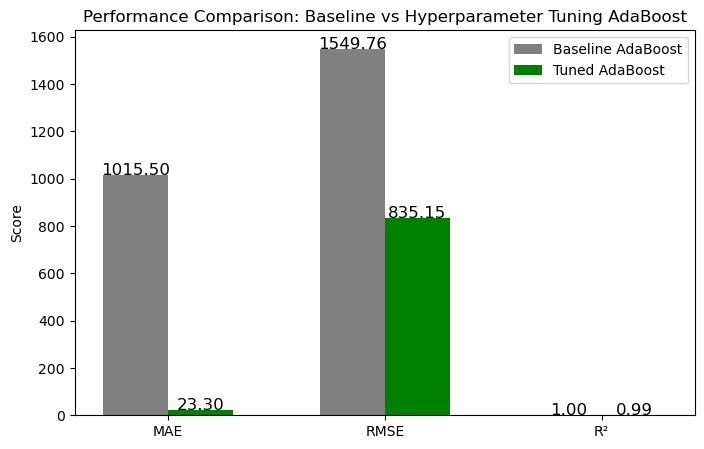

In [274]:

# Define metrics
metrics = ["MAE", "RMSE", "R²"]

baseline_values = [
    mean_absolute_error(y_test, pred_ada),
    mean_squared_error(y_test, pred_ada, squared=False),
    best_model.score(X_test_scaled, y_test)
]
tuned_values = [
    mean_absolute_error(y_test, best_pred_ada),
    mean_squared_error(y_test, best_pred_ada, squared=False),
    best_ada_model.score(X_test_scaled, y_test)
]


# Set position of bars
x = np.arange(len(metrics))
width = 0.3

# Create figure
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_values, width, label="Baseline AdaBoost", color="grey")
plt.bar(x + width/2, tuned_values, width, label="Tuned AdaBoost", color="Green")

# Add labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison: Baseline vs Hyperparameter Tuning AdaBoost")
plt.legend(loc="upper right", ncol=1)  # Horizontal legend

# Show values on bars
for i in range(len(metrics)):
    plt.text(i - width/2, baseline_values[i] + 0.02, f"{baseline_values[i]:.2f}", ha='center', fontsize=12)
    plt.text(i + width/2, tuned_values[i] + 0.02, f"{tuned_values[i]:.2f}", ha='center', fontsize=12)

# Show chart
plt.show()

#### Bagging Regressor

In [277]:




base_tree = DecisionTreeRegressor()
bag_reg = BaggingRegressor(estimator=base_tree, n_estimators=100, random_state=42)

param_grid = {
    'n_estimators': [20, 30, 40],
    'max_samples': [0.9, 1.0],
    'max_features': [0.8, 1.0],
    'estimator__max_depth': [9, 11],  # Depth of base trees
    'estimator__min_samples_split': [2, 3],  
    'estimator__min_samples_leaf': [1, 2]  
}



# Apply RandomizedSearchCV
bag_search = RandomizedSearchCV(bag_reg, param_grid, n_iter=20, cv=5, n_jobs=-1, random_state=42)

# Fit the model
bag_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5,
                   estimator=BaggingRegressor(estimator=DecisionTreeRegressor(),
                                              n_estimators=100,
                                              random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'estimator__max_depth': [9, 11],
                                        'estimator__min_samples_leaf': [1, 2],
                                        'estimator__min_samples_split': [2, 3],
                                        'max_features': [0.8, 1.0],
                                        'max_samples': [0.9, 1.0],
                                        'n_estimators': [20, 30, 40]},
                   random_state=42)

In [278]:
# Get the best hyperparameters
best_bag_params = bag_search.best_params_
best_bag_params

{'n_estimators': 20,
 'max_samples': 1.0,
 'max_features': 1.0,
 'estimator__min_samples_split': 3,
 'estimator__min_samples_leaf': 1,
 'estimator__max_depth': 11}

In [279]:
# After tuning 
best_model_bag = bag_search.best_estimator_


In [283]:
# Evaluate the best model on the test set
best_pred_bag = best_model_bag.predict(X_test_scaled)

print("MAE", mean_absolute_error(best_pred_bag, y_test))
print("RMSE", mean_squared_error(best_pred_bag, y_test, squared=False))
print("R2 score", r2_score(y_test, best_pred_bag)) 
print("MAPE", mean_absolute_percentage_error(best_pred_bag, y_test))

MAE 24.5284188675348
RMSE 828.7162649695937
R2 score 0.9944187149006736
MAPE 0.015362191150142371


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


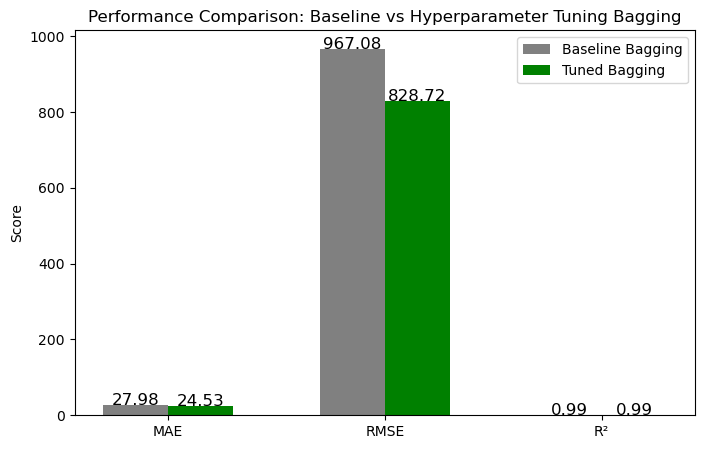

In [285]:
# Define metrics
metrics = ["MAE", "RMSE", "R²"]

baseline_values = [
    mean_absolute_error(y_test, pred_bag),
    mean_squared_error(y_test, pred_bag, squared=False),
    r2_score(y_test, pred_bag)
]

tuned_values = [
    mean_absolute_error(y_test, best_pred_bag),
    mean_squared_error(y_test, best_pred_bag, squared=False),
    r2_score(y_test, best_pred_bag)
]


# Set position of bars
x = np.arange(len(metrics))
width = 0.3

# Create figure
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_values, width, label="Baseline Bagging", color="grey")
plt.bar(x + width/2, tuned_values, width, label="Tuned Bagging", color="Green")

# Add labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison: Baseline vs Hyperparameter Tuning Bagging")
plt.legend(loc="upper right", ncol=1)  # Horizontal legend

# Show values on bars
for i in range(len(metrics)):
    plt.text(i - width/2, baseline_values[i] + 0.02, f"{baseline_values[i]:.2f}", ha='center', fontsize=12)
    plt.text(i + width/2, tuned_values[i] + 0.02, f"{tuned_values[i]:.2f}", ha='center', fontsize=12)

# Show chart
plt.show()

# Random Forest

In [288]:
# Define parameter grid

param_grid = {
    'n_estimators': [50, 70, 90],            
    'max_depth': [12, 14],                      
    'max_features': [0.8, 1.0],              
    'min_samples_split': [2, 3],             
    'min_samples_leaf': [1, 2],                  
               
}


# Randomized search setup
rf_search = RandomizedSearchCV(rf_model, param_grid, n_iter=30, cv=5, n_jobs=-1,random_state=20)

#Fit the model
rf_search.fit(X_train_scaled, y_train)


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=20),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [12, 14],
                                        'max_features': [0.8, 1.0],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': [50, 70, 90]},
                   random_state=20)

In [289]:
# Get the best hyperparameters
best_rf_params= rf_search.best_params_
best_rf_params

{'n_estimators': 90,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 1.0,
 'max_depth': 14}

In [290]:

# After tuning 
best_rf = rf_search.best_estimator_

In [291]:
# Evaluate the best model on the test set
best_pred_rf = best_rf.predict(X_test_scaled)

print("MAE", mean_absolute_error(best_pred_rf, y_test))
print("RMSE", mean_squared_error(best_pred_rf, y_test, squared=False))
print("R2 score", r2_score(y_test, best_pred_rf))  # For tuned model
print("MAPE", mean_absolute_percentage_error(best_pred_rf, y_test))

MAE 27.840944284354617
RMSE 966.6559716991625
R2 score 0.9924060740405857
MAPE 0.00034079165137663184


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


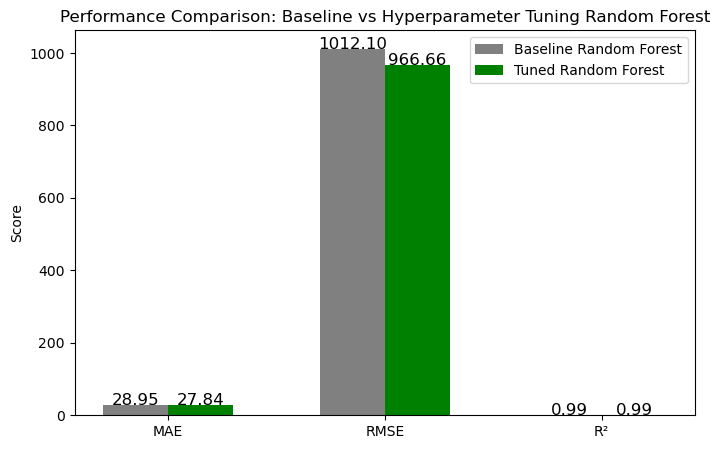

In [296]:
# Define metrics
metrics = ["MAE", "RMSE", "R²"]

baseline_values = [
    mean_absolute_error(y_test, pred_rf),
    mean_squared_error(y_test, pred_rf, squared=False),
    r2_score(y_test, pred_rf)
]

tuned_values = [
    mean_absolute_error(y_test, best_pred_rf),
    mean_squared_error(y_test, best_pred_rf, squared=False),
    r2_score(y_test, best_pred_rf)
]


# Set position of bars
x = np.arange(len(metrics))
width = 0.3

# Create figure
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, baseline_values, width, label="Baseline Random Forest", color="grey")
plt.bar(x + width/2, tuned_values, width, label="Tuned Random Forest", color="Green")

# Add labels
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Performance Comparison: Baseline vs Hyperparameter Tuning Random Forest")
plt.legend(loc="upper right", ncol=1)  # Horizontal legend

# Show values on bars
for i in range(len(metrics)):
    plt.text(i - width/2, baseline_values[i] + 0.02, f"{baseline_values[i]:.2f}", ha='center', fontsize=12)
    plt.text(i + width/2, tuned_values[i] + 0.02, f"{tuned_values[i]:.2f}", ha='center', fontsize=12)

# Show chart
plt.show()

### Segment-Specific Modeling 

In [300]:
df_new_pred = df_active.drop(columns=['forecast', 'mape', 'absolute_error'], errors='ignore')


In [302]:
# Rebuild feature matrix using same feature set and encoding
features = ['sales_lag_3', 'forecast_lag_3', 'log_sales', 'seg_combo']
X_new = pd.get_dummies(df_new_pred[features])

# Align columns with training data (optional safety step)
X_new = X_new.reindex(columns=X.columns, fill_value=0)

# Scale using the existing scaler
X_new_scaled = scaler.transform(X_new)
X_new_scaled = pd.DataFrame(scaler.transform(X_new), columns=X_new.columns)


In [304]:
df_new_pred['gb_forecast'] = best_model.predict(X_new_scaled)
df_new_pred['ada_forecast'] = best_ada_model.predict(X_new_scaled)
df_new_pred['bag_forecast'] = best_model_bag.predict(X_new_scaled)
df_new_pred['rf_forecast'] = best_rf.predict(X_new_scaled)


In [306]:
df_new_pred['model_segment'] = df_new_pred['seg_combo'].astype(str) + '_' + df_new_pred['log_segment'].astype(str)

In [308]:

segment_col = 'model_segment'  # or use 'market_segmentation'
models = ['gb_forecast', 'ada_forecast', 'bag_forecast', 'rf_forecast']

results = {}

for seg in df_new_pred[segment_col].unique():
    results[seg] = {}
    df_seg = df_new_pred[df_new_pred[segment_col] == seg]
    for model in models:
        mae = mean_absolute_error(df_seg['sales'], df_seg[model])
        results[seg][model] = round(mae, 2)

# Display as DataFrame
segment_results_df = pd.DataFrame(results).T
segment_results_df


gb_forecast  ada_forecast  \
Secure_Regular MCO_Mid High                    0.47          0.37   
Secure_Regular MCO_Mid                         0.40          0.16   
Secure_Regular MCO_Very Low                    0.52          0.29   
Secure_Regular MCO_Low                         0.31          0.22   
Secure_Regular MCO_High                        0.69          0.54   
Secure_Top MCO_Very High                       1.22          0.92   
Secure_Top MCO_High                            0.74          0.57   
Secure_Top MCO_Extreme High                    5.79          5.71   
Secure_Top MCO_Mid                             0.44          0.20   
Secure_Major MCO_Low                           0.34          0.26   
Secure_Major MCO_Mid High                      0.45          0.34   
Secure_Major MCO_Mid                           0.44          0.17   
Secure_Major MCO_High                          0.66          0.55   
Secure_Major MCO_Very Low                      0.46          0.21   
Secure_Top MCO_Low                             0.35          0.26   
Secure_Top MCO_Very Low                        0.48          0.25   
Secure_Top MCO_Mid High                        0.49          0.37   
Secure_Major MCO_Extreme High                  2.07          2.11   
Secure_Major MCO_Very High                     0.97          0.95   
Secure_Regular MCO_Very High                   0.96          0.90   
Secure_Regular MCO_Extreme High                3.04          4.13   
Supply Growth_Regular MCO_Mid                  0.46          0.19   
Supply Growth_Regular MCO_Low                  0.35          0.25   
Supply Growth_Top MCO_Extreme High            67.07         78.85   
Supply Growth_Regular MCO_Mid High             0.54          0.38   
Supply Growth_Regular MCO_High                 0.69          0.52   
Supply Growth_Major MCO_Very High              1.30          1.07   
Supply Growth_Major MCO_Mid High               0.59          0.37   
Supply Growth_Major MCO_High                   0.73          0.52   
Supply Growth_Major MCO_Very Low               0.56          0.40   
Supply Growth_Regular MCO_Very High            1.15          0.93   
Supply Growth_Top MCO_Mid                      0.48          0.22   
Supply Growth_Top MCO_Mid High                 0.54          0.37   
Supply Growth_Top MCO_High                     0.73          0.55   
Supply Growth_Top MCO_Low                      0.38          0.24   
Supply Growth_Top MCO_Very Low                 0.53          0.30   
Supply Growth_Top MCO_Very High                1.20          1.05   
Supply Growth_Regular MCO_Extreme High         3.91          3.56   
Supply Growth_Major MCO_Low                    0.35          0.27   
Supply Growth_Major MCO_Mid                    0.44          0.18   
Supply Growth_Regular MCO_Very Low             0.51          0.33   
Supply Growth_Major MCO_Extreme High           3.23          2.88   

                                        bag_forecast  rf_forecast  
Secure_Regular MCO_Mid High                     0.27         0.00  
Secure_Regular MCO_Mid                          0.21         0.00  
Secure_Regular MCO_Very Low                     0.67         0.00  
Secure_Regular MCO_Low                          0.25         0.00  
Secure_Regular MCO_High                         0.57         0.03  
Secure_Top MCO_Very High                        0.94         0.21  
Secure_Top MCO_High                             0.57         0.04  
Secure_Top MCO_Extreme High                     9.89         7.32  
Secure_Top MCO_Mid                              0.26         0.00  
Secure_Major MCO_Low                            0.24         0.00  
Secure_Major MCO_Mid High                       0.27         0.00  
Secure_Major MCO_Mid                            0.20         0.00  
Secure_Major MCO_High                           0.54         0.03  
Secure_Major MCO_Very Low                       0.74         0.00  
Secure_Top MCO_Low                              0.27

In [310]:
segment_results_df['Best_Model'] = segment_results_df.idxmin(axis=1)


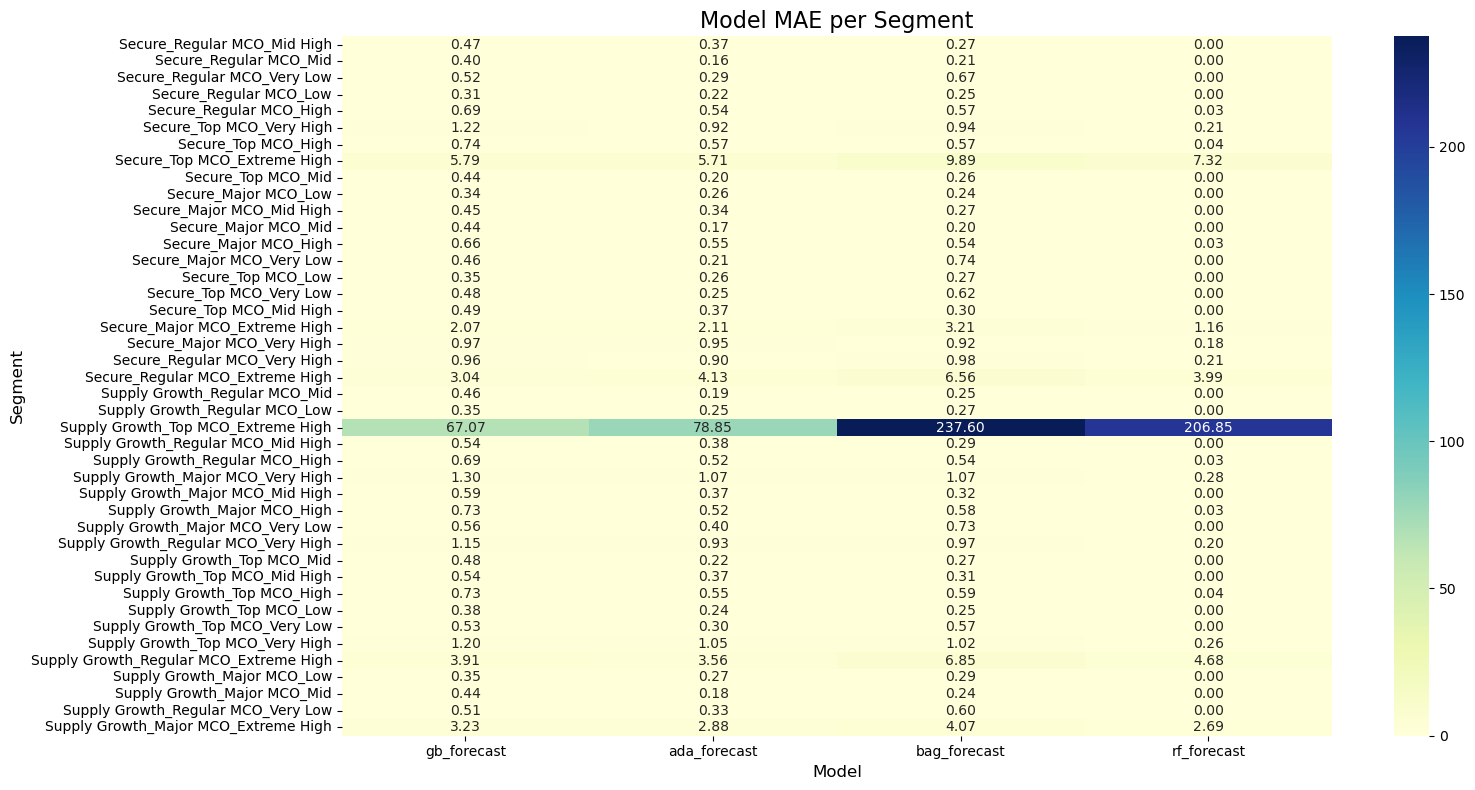

In [312]:
# Set larger figure size
plt.figure(figsize=(16, 8))  # Adjust width & height as needed

# Create heatmap
sns.heatmap(segment_results_df[['gb_forecast', 'ada_forecast', 'bag_forecast', 'rf_forecast']],
            annot=True, fmt=".2f", cmap='YlGnBu')

# Titles & labels
plt.title('Model MAE per Segment', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Segment', fontsize=12)

# Improve layout
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [314]:
# Absolute Error
df_new_pred['gb_absolute_error'] = abs(df_new_pred['sales'] - df_new_pred['gb_forecast'])
df_new_pred['ada_absolute_error'] = abs(df_new_pred['sales'] - df_new_pred['ada_forecast'])
df_new_pred['bag_absolute_error'] = abs(df_new_pred['sales'] - df_new_pred['bag_forecast'])
df_new_pred['rf_absolute_error'] = abs(df_new_pred['sales'] - df_new_pred['rf_forecast'])

# Row-level MAPE (with zero-handling)
df_new_pred['gb_mape'] = (df_new_pred['gb_absolute_error'] / df_new_pred['sales']).replace([np.inf, -np.inf], np.nan).fillna(0)
df_new_pred['ada_mape'] = (df_new_pred['ada_absolute_error'] / df_new_pred['sales']).replace([np.inf, -np.inf], np.nan).fillna(0)
df_new_pred['bag_mape'] = (df_new_pred['bag_absolute_error'] / df_new_pred['sales']).replace([np.inf, -np.inf], np.nan).fillna(0)
df_new_pred['rf_mape'] = (df_new_pred['rf_absolute_error'] / df_new_pred['sales']).replace([np.inf, -np.inf], np.nan).fillna(0)


df_new_pred['gb_mape'] = df_new_pred['gb_mape'] * 100
df_new_pred['ada_mape'] = df_new_pred['ada_mape'] * 100
df_new_pred['bag_mape'] = df_new_pred['bag_mape'] * 100
df_new_pred['rf_mape'] = df_new_pred['rf_mape'] * 100

df_new_pred[['gb_mape', 'ada_mape','bag_mape','rf_mape']] = df_new_pred[['gb_mape', 'ada_mape','bag_mape','rf_mape']].round(2)
df_new_pred[['gb_absolute_error', 'ada_absolute_error','bag_absolute_error','rf_absolute_error']] = df_new_pred[['gb_absolute_error', 'ada_absolute_error','bag_absolute_error','rf_absolute_error']].round(2)


In [316]:
#Check statistical summary
num_cols = ['sales','gb_forecast', 'ada_forecast', 'bag_forecast', 'rf_forecast','gb_mape', 'ada_mape','bag_mape','rf_mape','gb_absolute_error', 'ada_absolute_error','bag_absolute_error','rf_absolute_error']

df_new_pred[num_cols].describe()

sales    gb_forecast   ada_forecast   bag_forecast  \
count   15410.000000   15410.000000   15410.000000   15410.000000   
mean     1780.956067    1779.343273    1777.166908    1777.896140   
std     12667.098456   12617.063217   12562.425995   12569.764400   
min         1.000000       1.819532       1.565714       2.076419   
25%        47.000000      46.966111      46.927419      47.298180   
50%       184.000000     185.721593     183.898305     183.214802   
75%       750.000000     751.425331     751.250000     749.739641   
max    383242.000000  355919.151969  357190.000000  342530.985833   

         rf_forecast       gb_mape      ada_mape      bag_mape       rf_mape  \
count   15410.000000  15410.000000  15410.000000  15410.000000  15410.000000   
mean     1774.609381      1.670836      1.066533      1.696126      0.017839   
std     12503.400848      7.114624      5.095281      9.238985      0.155180   
min         1.000000      0.000000      0.000000      0.000000      0.000000   
25%        47.000000      0.070000      0.050000      0.070000      0.000000   
50%       184.000000      0.250000      0.140000      0.180000      0.000000   
75%       750.005185      0.840000      0.380000      0.460000      0.010000   
max    339365.133333     81.950000     56.570000    107.640000     12.890000   

       gb_absolute_error  ada_absolute_error  bag_absolute_error  \
count       15410.000000        15410.000000        15410.000000   
mean            4.763780            5.311300           14.839432   
std           250.518267          373.478192          446.447153   
min             0.000000            0.000000            0.000000   
25%             0.240000            0.120000            0.150000   
50%             0.450000            0.400000            0.390000   
75%             1.050000            0.740000            0.870000   
max         30529.690000        44781.000000        43051.510000   

       rf_absolute_error  
count       15410.000000  
mean           12.503014  
std           469.214169  
min             0.000000  
25%             0.000000  
50%             0.000000  
75%             0.060000  
max         49387.240000

In [318]:
def generate_final_forecast_with_metrics(df, segment_col='model_segment', models=None):
    if models is None:
        models = ['gb_forecast', 'ada_forecast', 'bag_forecast', 'rf_forecast']
    
    best_models = {}
    
    # Step 1: Identify best model per segment
    for seg in df[segment_col].unique():
        df_seg = df[df[segment_col] == seg]
        model_mae = {
            model: mean_absolute_error(df_seg['sales'], df_seg[model])
            for model in models
        }
        best_model = min(model_mae, key=model_mae.get)
        best_models[seg] = best_model
    
    # Step 2: Apply best model forecast to each row
    df['final_forecast'] = df.apply(
        lambda row: row[best_models[row[segment_col]]],
        axis=1
    )

    # Step 3: Add error columns per row
    df['final_absolute_error'] = (df['sales'] - df['final_forecast']).abs()
    df['final_mape'] = ((df['final_absolute_error'] / df['sales']) * 100).round(2)

    # Step 4: Calculate overall error metrics
    overall_mae = df['final_absolute_error'].mean()
    overall_mape = df['final_mape'].mean()

    metrics = {
        'MAE': round(overall_mae, 2),
        'MAPE (%)': round(overall_mape, 2)
    }

    return df, best_models, metrics


In [320]:
df_new, best_models, metrics = generate_final_forecast_with_metrics(df_new_pred)
df_new['final_best_model'] = df_new_pred['model_segment'].map(best_models)
df_new.to_csv('final_forecast_results.csv', index=False)


In [322]:
df_new.head()

gmid_key       date  year  month  product_family    gmid country  \
6   100001_20237_AU 2023-07-01  2023      7               1  100001      AU   
7   100001_20237_NZ 2023-07-01  2023      7               1  100001      NZ   
8   100001_20238_AU 2023-08-01  2023      8               1  100001      AU   
9   100001_20238_NZ 2023-08-01  2023      8               1  100001      NZ   
10  100001_20239_AU 2023-09-01  2023      9               1  100001      AU   

         market      geography  sales  ... bag_absolute_error  \
6     Australia  International     75  ...               0.34   
7   New Zealand  International     29  ...               0.06   
8     Australia  International     66  ...               0.43   
9   New Zealand  International     26  ...               0.19   
10    Australia  International     48  ...               0.05   

   rf_absolute_error gb_mape  ada_mape bag_mape rf_mape  final_forecast  \
6                0.0    0.81      0.63     0.45     0.0            75.0   
7                0.0    2.08      0.03     0.22     0.0            29.0   
8                0.0    0.82      0.06     0.65     0.0            66.0   
9                0.0    5.10      0.10     0.73     0.0            26.0   
10               0.0    0.06      0.02     0.10     0.0            48.0   

    final_absolute_error  final_mape  final_best_model  
6                    0.0         0.0       rf_forecast  
7                    0.0         0.0       rf_forecast  
8                    0.0         0.0       rf_forecast  
9                    0.0         0.0       rf_forecast  
10                   0.0         0.0       rf_forecast  

[5 rows x 35 columns]

In [324]:
best_model_df = pd.DataFrame.from_dict(best_models, orient='index', columns=['Best_Model'])
best_model_df

Best_Model
Secure_Regular MCO_Mid High              rf_forecast
Secure_Regular MCO_Mid                   rf_forecast
Secure_Regular MCO_Very Low              rf_forecast
Secure_Regular MCO_Low                   rf_forecast
Secure_Regular MCO_High                  rf_forecast
Secure_Top MCO_Very High                 rf_forecast
Secure_Top MCO_High                      rf_forecast
Secure_Top MCO_Extreme High             ada_forecast
Secure_Top MCO_Mid                       rf_forecast
Secure_Major MCO_Low                     rf_forecast
Secure_Major MCO_Mid High                rf_forecast
Secure_Major MCO_Mid                     rf_forecast
Secure_Major MCO_High                    rf_forecast
Secure_Major MCO_Very Low                rf_forecast
Secure_Top MCO_Low                       rf_forecast
Secure_Top MCO_Very Low                  rf_forecast
Secure_Top MCO_Mid High                  rf_forecast
Secure_Major MCO_Extreme High            rf_forecast
Secure_Major MCO_Very High               rf_forecast
Secure_Regular MCO_Very High             rf_forecast
Secure_Regular MCO_Extreme High          gb_forecast
Supply Growth_Regular MCO_Mid            rf_forecast
Supply Growth_Regular MCO_Low            rf_forecast
Supply Growth_Top MCO_Extreme High       gb_forecast
Supply Growth_Regular MCO_Mid High       rf_forecast
Supply Growth_Regular MCO_High           rf_forecast
Supply Growth_Major MCO_Very High        rf_forecast
Supply Growth_Major MCO_Mid High         rf_forecast
Supply Growth_Major MCO_High             rf_forecast
Supply Growth_Major MCO_Very Low         rf_forecast
Supply Growth_Regular MCO_Very High      rf_forecast
Supply Growth_Top MCO_Mid                rf_forecast
Supply Growth_Top MCO_Mid High           rf_forecast
Supply Growth_Top MCO_High               rf_forecast
Supply Growth_Top MCO_Low                rf_forecast
Supply Growth_Top MCO_Very Low           rf_forecast
Supply Growth_Top MCO_Very High          rf_forecast
Supply Growth_Regular MCO_Extreme High  ada_forecast
Supply Growth_Major MCO_Low              rf_forecast
Supply Growth_Major MCO_Mid              rf_forecast
Supply Growth_Regular MCO_Very Low       rf_forecast
Supply Growth_Major MCO_Extreme High     rf_forecast

### Forecast Predictive Model Results

In [327]:
df_new.groupby('market_segmentation')[['gb_mape', 'ada_mape', 'bag_mape', 'rf_mape', 'final_mape','final_absolute_error']].mean().round(2)


gb_mape  ada_mape  bag_mape  rf_mape  final_mape  \
market_segmentation                                                     
Major MCO               1.45      0.94      1.46     0.01        0.01   
Regular MCO             1.88      1.21      1.93     0.01        0.01   
Top MCO                 1.59      1.00      1.61     0.03        0.02   

                     final_absolute_error  
market_segmentation                        
Major MCO                            0.17  
Regular MCO                          0.33  
Top MCO                              7.29

In [329]:
df_new.groupby('log_segment')[['gb_mape', 'ada_mape', 'bag_mape', 'rf_mape', 'final_mape','final_absolute_error']].mean().round(2)

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/3244235280.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_new.groupby('log_segment')[['gb_mape', 'ada_mape', 'bag_mape', 'rf_mape', 'final_mape','final_absolute_error']].mean().round(2)


gb_mape  ada_mape  bag_mape  rf_mape  final_mape  \
log_segment                                                      
Very Low        26.09     17.31     30.95     0.00        0.00   
Low              2.91      1.81      2.61     0.00        0.00   
Mid              1.16      0.47      0.61     0.00        0.00   
Mid High         0.46      0.34      0.26     0.00        0.00   
High             0.22      0.16      0.17     0.01        0.01   
Very High        0.11      0.09      0.09     0.02        0.02   
Extreme High     0.09      0.08      0.16     0.11        0.09   

              final_absolute_error  
log_segment                         
Very Low                      0.00  
Low                           0.00  
Mid                           0.00  
Mid High                      0.00  
High                          0.03  
Very High                     0.22  
Extreme High                 34.86

In [331]:
#Check statistical summary
num_cols = ['sales','final_forecast','final_mape','gb_mape', 'ada_mape','bag_mape', 'rf_mape']

df_new[num_cols].describe()


sales  final_forecast    final_mape       gb_mape  \
count   15410.000000    15410.000000  15410.000000  15410.000000   
mean     1780.956067     1779.219853      0.015027      1.670836   
std     12667.098456    12617.089749      0.087706      7.114624   
min         1.000000        1.000000      0.000000      0.000000   
25%        47.000000       47.000000      0.000000      0.070000   
50%       184.000000      184.000000      0.000000      0.250000   
75%       750.000000      750.005185      0.010000      0.840000   
max    383242.000000   355919.151969      7.970000     81.950000   

           ada_mape      bag_mape       rf_mape  
count  15410.000000  15410.000000  15410.000000  
mean       1.066533      1.696126      0.017839  
std        5.095281      9.238985      0.155180  
min        0.000000      0.000000      0.000000  
25%        0.050000      0.070000      0.000000  
50%        0.140000      0.180000      0.000000  
75%        0.380000      0.460000      0.010000  
max       56.570000    107.640000     12.890000

In [333]:
#Check statistical summary
num_cols = ['sales','final_forecast','final_absolute_error', 'gb_absolute_error', 'ada_absolute_error','bag_absolute_error','rf_absolute_error']

df_new[num_cols].describe()


sales  final_forecast  final_absolute_error  gb_absolute_error  \
count   15410.000000    15410.000000          15410.000000       15410.000000   
mean     1780.956067     1779.219853              4.231819           4.763780   
std     12667.098456    12617.089749            250.532164         250.518267   
min         1.000000        1.000000              0.000000           0.000000   
25%        47.000000       47.000000              0.000000           0.240000   
50%       184.000000      184.000000              0.000000           0.450000   
75%       750.000000      750.005185              0.053738           1.050000   
max    383242.000000   355919.151969          30529.690024       30529.690000   

       ada_absolute_error  bag_absolute_error  rf_absolute_error  
count        15410.000000        15410.000000       15410.000000  
mean             5.311300           14.839432          12.503014  
std            373.478192          446.447153         469.214169  
min              0.000000            0.000000           0.000000  
25%              0.120000            0.150000           0.000000  
50%              0.400000            0.390000           0.000000  
75%              0.740000            0.870000           0.060000  
max          44781.000000        43051.510000       49387.240000

In [335]:
#Check statistical summary
num_cols = ['sales', 'forecast', 'mape','absolute_error']

df_all[num_cols].describe()


sales       forecast           mape  absolute_error
count   16918.000000   16918.000000   16918.000000    16918.000000
mean     1622.209067    1653.010758      73.010418      314.032451
std     12099.989664   12191.690454    1453.125076     1947.380221
min         0.000000       0.000000       0.000000        0.000000
25%        28.000000      30.000000       6.332500       11.000000
50%       144.000000     146.000000      20.000000       39.000000
75%       650.000000     657.000000      51.665000      140.000000
max    383242.000000  370680.000000  178150.000000    57901.000000

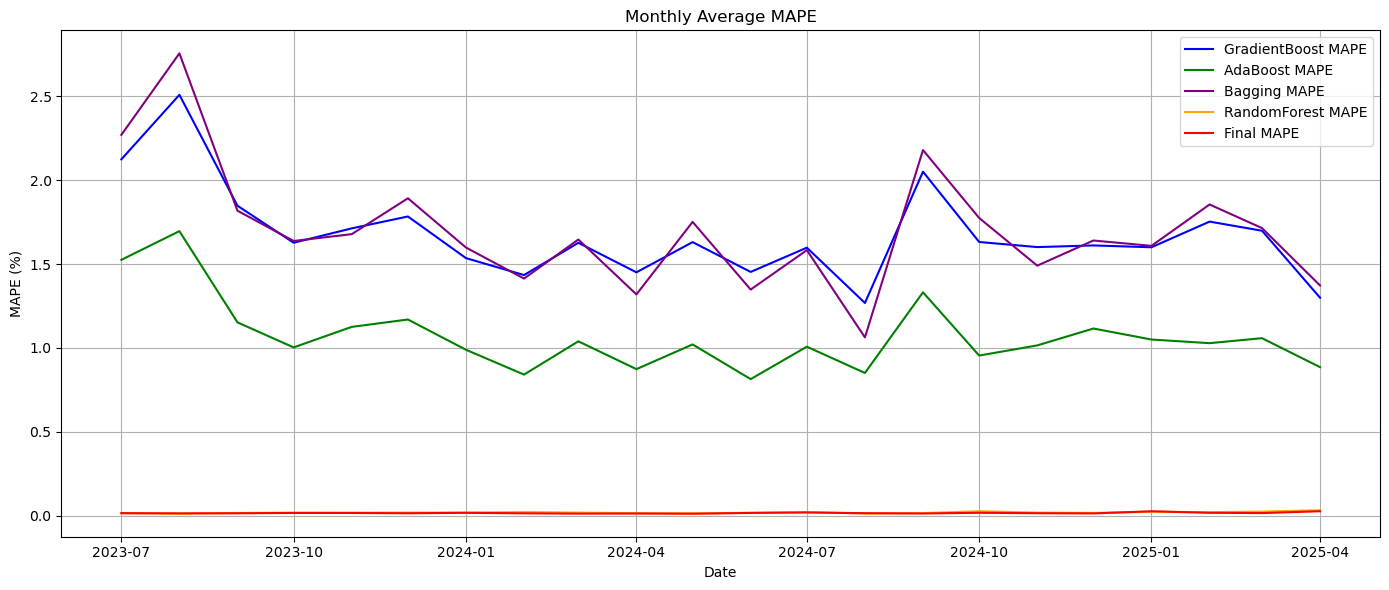

In [337]:
df_monthly = df_new.groupby('date')[['gb_mape', 'ada_mape','bag_mape', 'rf_mape','final_mape']].mean().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(df_monthly['date'], df_monthly['gb_mape'], label='GradientBoost MAPE', color='blue')
plt.plot(df_monthly['date'], df_monthly['ada_mape'], label='AdaBoost MAPE', color='green')
plt.plot(df_monthly['date'], df_monthly['bag_mape'], label='Bagging MAPE', color='purple')
plt.plot(df_monthly['date'], df_monthly['rf_mape'], label='RandomForest MAPE', color='orange')
plt.plot(df_monthly['date'], df_monthly['final_mape'], label='Final MAPE', color='red')
plt.title('Monthly Average MAPE')
plt.xlabel('Date')
plt.ylabel('MAPE (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

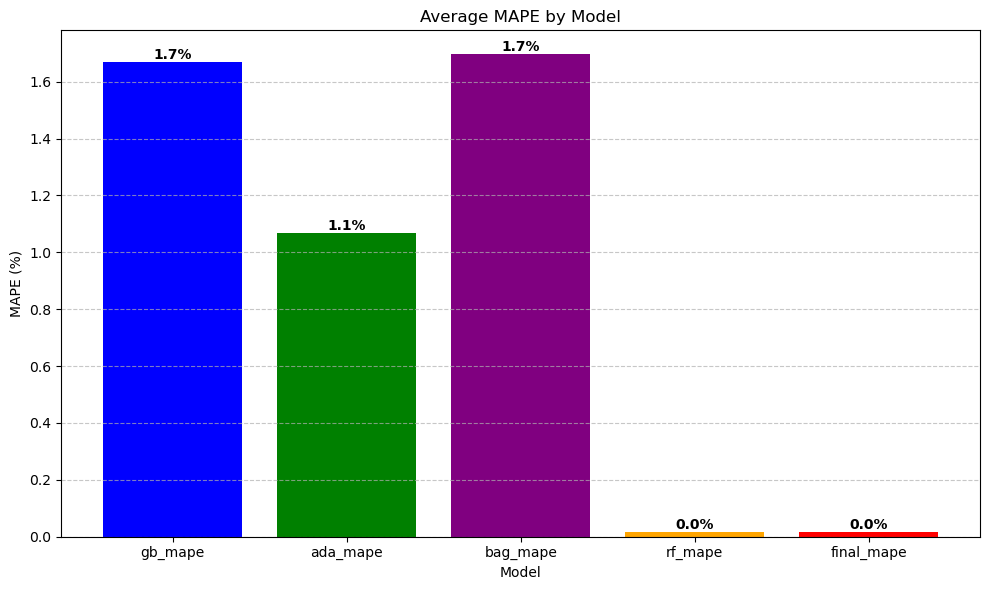

In [487]:
import matplotlib.pyplot as plt

# Aggregate average MAPE per model
model_mape = df_new[['gb_mape', 'ada_mape', 'bag_mape', 'rf_mape', 'final_mape']].mean()
model_mape_percent = model_mape.round(1)  # Round for cleaner labels

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(model_mape.index, model_mape.values, color=['blue', 'green', 'purple', 'orange', 'red'])

# Add percentage labels
for bar, value in zip(bars, model_mape_percent):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0, f'{value:.1f}%', ha='center', va='bottom', fontsize=10, weight='bold')

# Customize
ax.set_title('Average MAPE by Model')
ax.set_xlabel('Model')
ax.set_ylabel('MAPE (%)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/1794715091.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_segment = df_new.groupby('log_segment')['final_mape'].mean().reindex(segment_order)
/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/1794715091.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_new, x='log_segment', order=segment_order, palette='plasma')


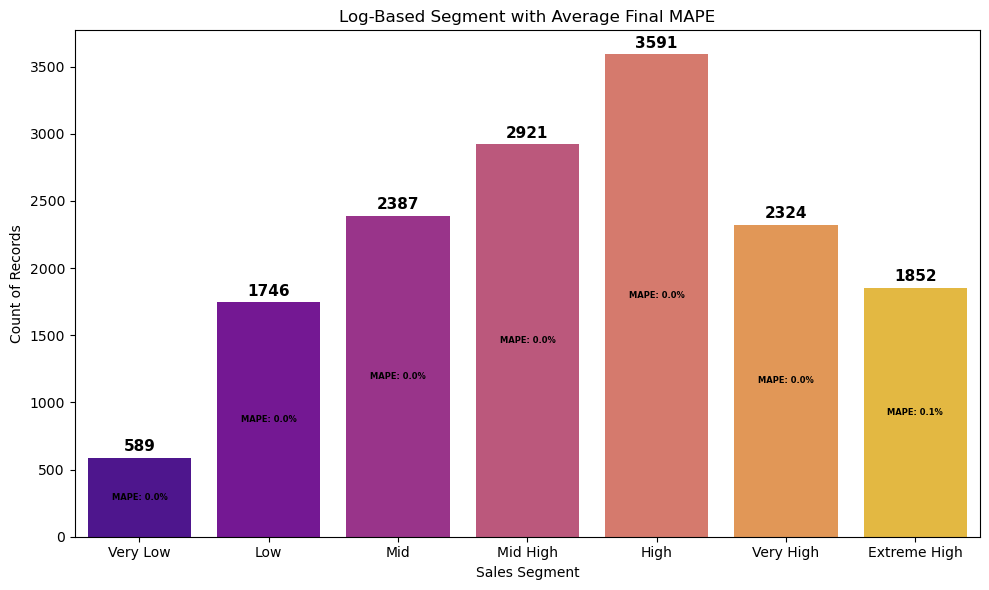

In [567]:
# Ensure 'log_segment' exists and is correctly ordered
segment_order = ['Very Low',  'Low', 'Mid', 'Mid High', 'High', 'Very High', 'Extreme High']

# Calculate average MAPE by log segment (using df_active)
mape_by_segment = df_new.groupby('log_segment')['final_mape'].mean().reindex(segment_order)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_new, x='log_segment', order=segment_order, palette='plasma')

# Annotate each bar with count and MAPE
for p, segment_name in zip(ax.patches, segment_order):
    height = p.get_height()
    xpos = p.get_x() + p.get_width() / 2.

    # Add count label above the bar
    ax.text(xpos, height + 50, f'{int(height)}', ha='center', fontsize=11, fontweight='bold')

    # Add MAPE label inside the bar
    mape_val = mape_by_segment.get(segment_name, np.nan)
    ax.text(xpos, height / 2, f'MAPE: {mape_val:.1f}%', ha='center', va='center',
            fontsize=6, color='black', fontweight='bold')

# Formatting
plt.title("Log-Based Segment with Average Final MAPE")
plt.xlabel("Sales Segment")
plt.ylabel("Count of Records")
plt.tight_layout()
plt.show()

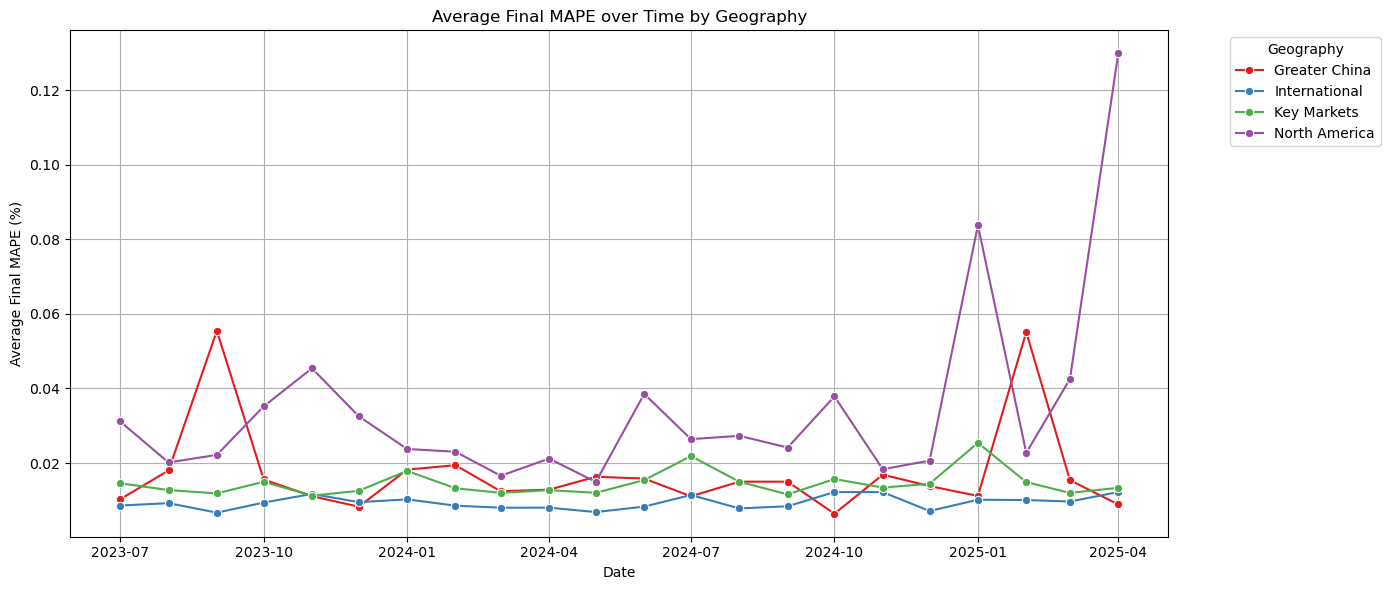

In [343]:
geo_final_mape = df_new.groupby(['geography', 'year', 'month'])['final_mape'].mean().reset_index()

# Create a datetime column for proper x-axis formatting
geo_final_mape['date'] = pd.to_datetime(geo_final_mape[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 6))
sns.lineplot(data=geo_final_mape, x='date', y='final_mape', hue='geography', marker='o', palette='Set1')

plt.title('Average Final MAPE over Time by Geography')
plt.xlabel('Date')
plt.ylabel('Average Final MAPE (%)')
plt.legend(title='Geography', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


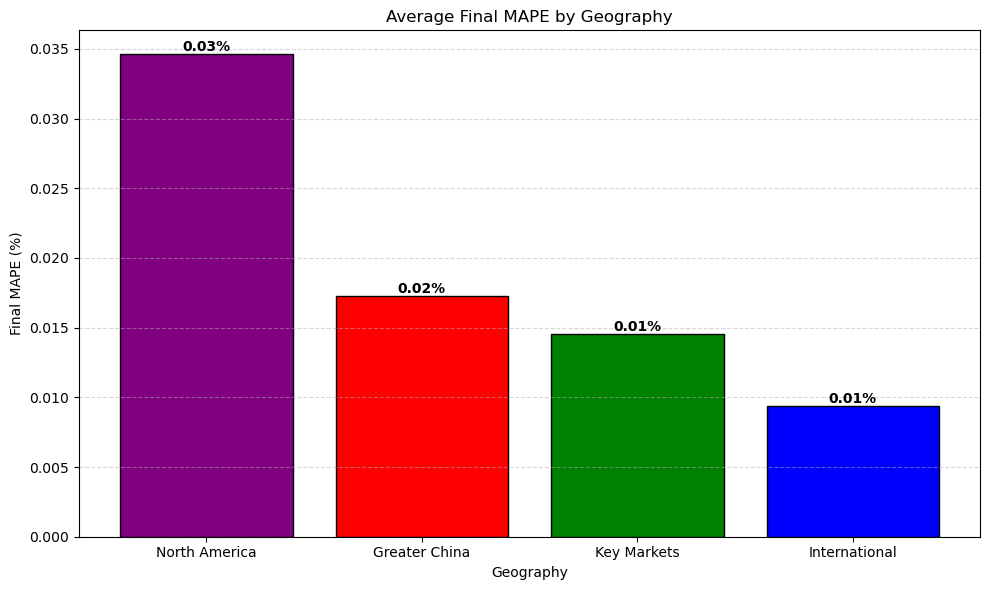

In [547]:

# Group by geography and calculate average final MAPE
avg_mape_geo = df_new.groupby('geography')['final_mape'].mean().sort_values(ascending=False)

# Define custom colors for key regions
geo_colors = {
    'Greater China': 'red',
    'International': 'blue',
    'Key Markets': 'green',
    'North America': 'purple'
}
bar_colors = [geo_colors.get(geo, 'gray') for geo in avg_mape_geo.index]

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(avg_mape_geo.index, avg_mape_geo.values, color=bar_colors, edgecolor='black')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0,
        f'{height:.2f}%',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Final touches
plt.title('Average Final MAPE by Geography')
plt.xlabel('Geography')
plt.ylabel('Final MAPE (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()







### Explore occurrences with Mape >10% and Absolute Error >100 units

In [346]:
#Filtering Rows With High Error
filtered_df_mape_error = df_new[(df_new['final_mape'] > 10) & (df_new['final_absolute_error'] > 100)]
filtered_df_mape_error


Empty DataFrame
Columns: [gmid_key, date, year, month, product_family, gmid, country, market, geography, sales, market_segmentation, pf_segmentation, gmid_segmentation, log_sales, log_segment, seg_combo, sales_lag_3, forecast_lag_3, gb_forecast, ada_forecast, bag_forecast, rf_forecast, model_segment, gb_absolute_error, ada_absolute_error, bag_absolute_error, rf_absolute_error, gb_mape, ada_mape, bag_mape, rf_mape, final_forecast, final_absolute_error, final_mape, final_best_model]
Index: []

[0 rows x 35 columns]

In [348]:
high_mape = df_new[(df_new['final_mape'] > 10)]
high_mape

Empty DataFrame
Columns: [gmid_key, date, year, month, product_family, gmid, country, market, geography, sales, market_segmentation, pf_segmentation, gmid_segmentation, log_sales, log_segment, seg_combo, sales_lag_3, forecast_lag_3, gb_forecast, ada_forecast, bag_forecast, rf_forecast, model_segment, gb_absolute_error, ada_absolute_error, bag_absolute_error, rf_absolute_error, gb_mape, ada_mape, bag_mape, rf_mape, final_forecast, final_absolute_error, final_mape, final_best_model]
Index: []

[0 rows x 35 columns]

In [350]:
high_error = df_new[(df_new['final_absolute_error'] > 100)]
high_error.head()

gmid_key       date  year  month  product_family    gmid  \
887   110003_202311_US 2023-11-01  2023     11              11  110003   
4865   150001_20237_US 2023-07-01  2023      7              15  150001   
4861  150001_202311_US 2023-11-01  2023     11              15  150001   
4877   150001_20241_US 2024-01-01  2024      1              15  150001   
4879   150001_20242_US 2024-02-01  2024      2              15  150001   

     country         market      geography   sales  ... bag_absolute_error  \
887       US  United States  North America   26550  ...             402.50   
4865      US  United States  North America  110554  ...               4.10   
4861      US  United States  North America  115033  ...            1313.71   
4877      US  United States  North America  111397  ...             308.37   
4879      US  United States  North America   87097  ...             669.07   

     rf_absolute_error gb_mape  ada_mape bag_mape rf_mape  final_forecast  \
887             468.60    0.93      1.25     1.52    1.76    26882.000000   
4865             77.79    0.10      0.00     0.00    0.07   110663.257962   
4861           1543.98    0.74      1.02     1.14    1.34   115883.747438   
4877            101.99    0.16      0.00     0.28    0.09   111220.156031   
4879            696.14    0.19      0.00     0.77    0.80    87262.239405   

      final_absolute_error  final_mape  final_best_model  
887             332.000000        1.25      ada_forecast  
4865            109.257962        0.10       gb_forecast  
4861            850.747438        0.74       gb_forecast  
4877            176.843969        0.16       gb_forecast  
4879            165.239405        0.19       gb_forecast  

[5 rows x 35 columns]

In [352]:
#count the number of occurrences where final_mape > 10 or final_abs_error > 100
error_count = df_new[
    (df_new['final_mape'] > 10) | (df_new['final_absolute_error'] > 100)
].shape[0]

print(f"Number of rows with MAPE > 10 or Abs Error > 100: {error_count}")

Number of rows with MAPE > 10 or Abs Error > 100: 51


In [354]:
filtered_df = df_new[
    (df_new['final_mape'] > 10) | (df_new['final_absolute_error'] > 100)
]

pf_counts = filtered_df['product_family'].value_counts()
print(pf_counts)


product_family
15    50
11     1
Name: count, dtype: int64


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/2666322234.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['seg_combo', 'log_segment'])['final_mape']


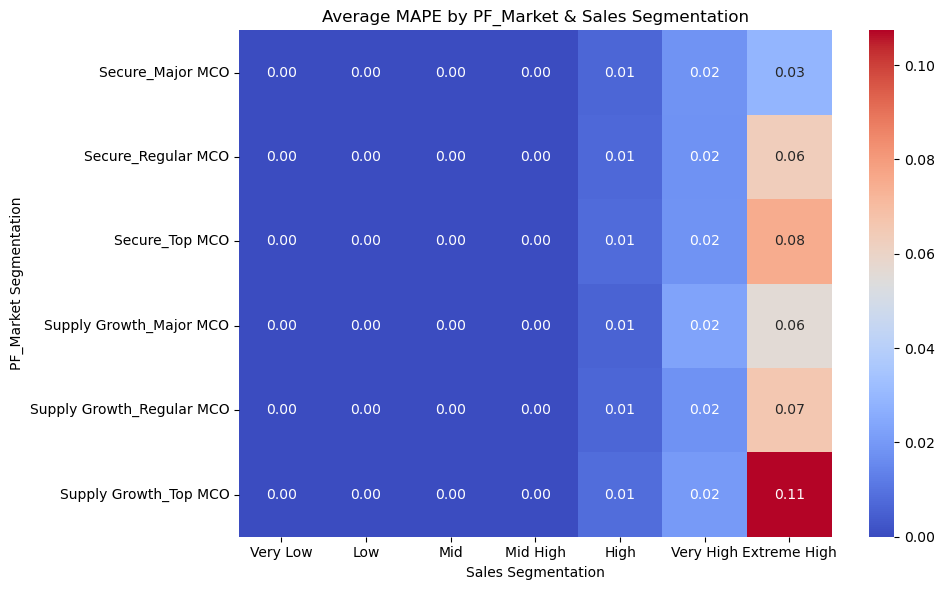

In [356]:
# Step 1: Calculate average MAPE per group
heatmap_df_new = (
    df_new
    .groupby(['seg_combo', 'log_segment'])['final_mape']
    .mean()
    .unstack()
)

# Step 2: Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df_new, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average MAPE by PF_Market & Sales Segmentation')
plt.xlabel('Sales Segmentation')
plt.ylabel('PF_Market Segmentation')
plt.tight_layout()
plt.show()



/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/1744786499.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['seg_combo', 'log_segment'])['final_absolute_error']


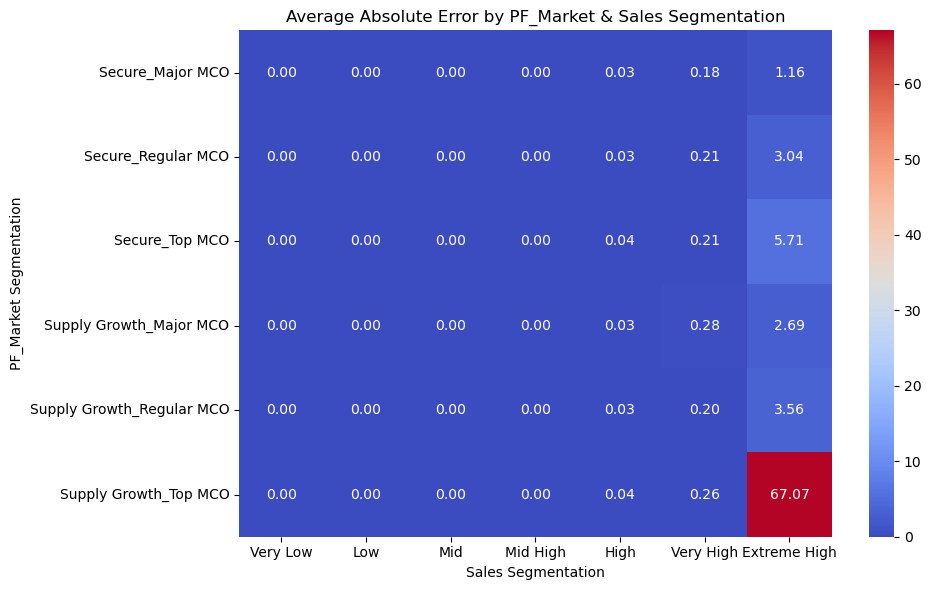

In [358]:
# Calculate average ABS error per group
heatmap_df_new = (
    df_new
    .groupby(['seg_combo', 'log_segment'])['final_absolute_error']
    .mean()
    .unstack()
)

# Step 2: Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df_new, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Average Absolute Error by PF_Market & Sales Segmentation')
plt.xlabel('Sales Segmentation')
plt.ylabel('PF_Market Segmentation')
plt.tight_layout()
plt.show()


### Predict Forecast for the next 12 months without sales information

In [362]:
df_no_sales = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/To_Predict_Forecast.csv")
df_no_sales.head()


year  month  PRODUCT_FAMILY    GMID    LOC Country
0  2025      7               6  600001  KR001      KR
1  2025      7               6  600002  HK001      HK
2  2025      7               6  600003  CA001      CA
3  2025      7               6  600005  AU001      AU
4  2025      7               6  600006  MX001      MX

In [364]:
# Merge df_no_sales with country metadata to add Country_Desc and Geography columns
df3_enriched = df_no_sales.merge(
    df_geo[['Country_Key', 'Country_Desc', 'Geography']],
    left_on='Country',
    right_on='Country_Key',
    how='left'  # Preserves all rows from df1
)
df3_enriched.drop(columns='Country_Key', inplace=True)
df3_enriched.head()

year  month  PRODUCT_FAMILY    GMID    LOC Country Country_Desc  \
0  2025      7               6  600001  KR001      KR        Korea   
1  2025      7               6  600002  HK001      HK    Hong Kong   
2  2025      7               6  600003  CA001      CA       Canada   
3  2025      7               6  600005  AU001      AU    Australia   
4  2025      7               6  600006  MX001      MX       Mexico   

       Geography  
0  International  
1  Greater China  
2  North America  
3  International  
4  International

In [366]:
# check duplication of rows after merge
print("Before merge:", len(df_no_sales))
print("After merge:", len(df3_enriched))

Before merge: 8808
After merge: 8808


In [368]:
df3_enriched['Date'] = df3_enriched['year'].astype(str) + '-' + df3_enriched['month'].astype(str).str.zfill(2)
df3_enriched['Date'] = pd.to_datetime(df3_enriched['Date'], format='%Y-%m')

df3_enriched.head()

year  month  PRODUCT_FAMILY    GMID    LOC Country Country_Desc  \
0  2025      7               6  600001  KR001      KR        Korea   
1  2025      7               6  600002  HK001      HK    Hong Kong   
2  2025      7               6  600003  CA001      CA       Canada   
3  2025      7               6  600005  AU001      AU    Australia   
4  2025      7               6  600006  MX001      MX       Mexico   

       Geography       Date  
0  International 2025-07-01  
1  Greater China 2025-07-01  
2  North America 2025-07-01  
3  International 2025-07-01  
4  International 2025-07-01

In [370]:
df3_enriched.dtypes


year                       int64
month                      int64
PRODUCT_FAMILY             int64
GMID                       int64
LOC                       object
Country                   object
Country_Desc              object
Geography                 object
Date              datetime64[ns]
dtype: object

In [372]:
#### Merge df3_enriched  with df_md (market and product segmentation information)
df_smart2 = df_md[['PRODUCT_FAMILY', 'SMART_SEGMENTATION']].drop_duplicates()

df1_smart2 = df3_enriched.merge(
    df_smart2,
    on='PRODUCT_FAMILY',
    how='left'
)
df1_smart2.head()

year  month  PRODUCT_FAMILY    GMID    LOC Country Country_Desc  \
0  2025      7               6  600001  KR001      KR        Korea   
1  2025      7               6  600002  HK001      HK    Hong Kong   
2  2025      7               6  600003  CA001      CA       Canada   
3  2025      7               6  600005  AU001      AU    Australia   
4  2025      7               6  600006  MX001      MX       Mexico   

       Geography       Date SMART_SEGMENTATION  
0  International 2025-07-01             Secure  
1  Greater China 2025-07-01             Secure  
2  North America 2025-07-01             Secure  
3  International 2025-07-01             Secure  
4  International 2025-07-01             Secure

In [374]:
#check duplication of rows after merge
print("Before merge:", len(df3_enriched))
print("After merge:", len(df1_smart2))

Before merge: 8808
After merge: 8808


In [376]:
df_mco2 = df_md[['Market', 'MCO_SEGMENTATION']].drop_duplicates()

df1_mco2 = df1_smart2.merge(
    df_mco2,
    left_on='Country',
    right_on='Market',
    how='left'
).drop(columns=['Market'])  # Optional: remove Market after merge
df1_mco2.head()

year  month  PRODUCT_FAMILY    GMID    LOC Country Country_Desc  \
0  2025      7               6  600001  KR001      KR        Korea   
1  2025      7               6  600002  HK001      HK    Hong Kong   
2  2025      7               6  600003  CA001      CA       Canada   
3  2025      7               6  600005  AU001      AU    Australia   
4  2025      7               6  600006  MX001      MX       Mexico   

       Geography       Date SMART_SEGMENTATION MCO_SEGMENTATION  
0  International 2025-07-01             Secure        Major MCO  
1  Greater China 2025-07-01             Secure      Regular MCO  
2  North America 2025-07-01             Secure          Top MCO  
3  International 2025-07-01             Secure      Regular MCO  
4  International 2025-07-01             Secure      Regular MCO

In [378]:
#check duplication of rows after merge
print("Before merge:", len(df3_enriched))
print("After merge:", len(df1_mco2))

Before merge: 8808
After merge: 8808


In [380]:
df_strategy2 = df_md[['GMID', 'Market', 'STRATEGY_SEGMENTATION']].drop_duplicates()

df_final2 = df1_mco2.merge(
    df_strategy2,
    left_on=['GMID', 'Country'],
    right_on=['GMID', 'Market'],
    how='left'
).drop(columns=['Market'])  # Again, drop Market if it’s redundant
df_final2.head()

year  month  PRODUCT_FAMILY    GMID    LOC Country Country_Desc  \
0  2025      7               6  600001  KR001      KR        Korea   
1  2025      7               6  600002  HK001      HK    Hong Kong   
2  2025      7               6  600003  CA001      CA       Canada   
3  2025      7               6  600005  AU001      AU    Australia   
4  2025      7               6  600006  MX001      MX       Mexico   

       Geography       Date SMART_SEGMENTATION MCO_SEGMENTATION  \
0  International 2025-07-01             Secure        Major MCO   
1  Greater China 2025-07-01             Secure      Regular MCO   
2  North America 2025-07-01             Secure          Top MCO   
3  International 2025-07-01             Secure      Regular MCO   
4  International 2025-07-01             Secure      Regular MCO   

  STRATEGY_SEGMENTATION  
0              Platinum  
1              Platinum  
2              Platinum  
3              Platinum  
4          Auto Piloted

In [382]:
#check duplication of rows after merge
print("Before merge:", len(df3_enriched))
print("After merge:", len(df_final2))


Before merge: 8808
After merge: 8808


In [384]:
# rename columns name

df_final2.rename(columns={'Country_Desc': 'Market'}, inplace=True)
df_final2.rename(columns={'SMART_SEGMENTATION': 'pf_segmentation'}, inplace=True)
df_final2.rename(columns={'MCO_SEGMENTATION': 'market_segmentation'}, inplace=True)
df_final2.rename(columns={'STRATEGY_SEGMENTATION': 'gmid_segmentation'}, inplace=True)
df_final2.rename(columns={'Coverage': 'coverage_months'}, inplace=True)
                         
df_final2.head()

year  month  PRODUCT_FAMILY    GMID    LOC Country     Market  \
0  2025      7               6  600001  KR001      KR      Korea   
1  2025      7               6  600002  HK001      HK  Hong Kong   
2  2025      7               6  600003  CA001      CA     Canada   
3  2025      7               6  600005  AU001      AU  Australia   
4  2025      7               6  600006  MX001      MX     Mexico   

       Geography       Date pf_segmentation market_segmentation  \
0  International 2025-07-01          Secure           Major MCO   
1  Greater China 2025-07-01          Secure         Regular MCO   
2  North America 2025-07-01          Secure             Top MCO   
3  International 2025-07-01          Secure         Regular MCO   
4  International 2025-07-01          Secure         Regular MCO   

  gmid_segmentation  
0          Platinum  
1          Platinum  
2          Platinum  
3          Platinum  
4      Auto Piloted

In [386]:
#format the headers
df_final2.columns = df_final2.columns.str.lower().str.strip().str.replace(' ', '_')

In [388]:
df_final2.shape

(8808, 12)

In [390]:
#Count of missing values per column
df_final2.isna().sum()

year                   0
month                  0
product_family         0
gmid                   0
loc                    0
country                0
market                 0
geography              0
date                   0
pf_segmentation        0
market_segmentation    0
gmid_segmentation      0
dtype: int64

In [392]:
#check gmid_key duplicates

df_final2.loc[:, 'gmid_key'] = (
    df_final2['gmid'].astype(str) + '_' +
    df_final2['year'].astype(str) + df_final2['month'].astype(str).str.zfill(2) + '_' +
    df_final2['country'].astype(str)
)
duplicate_rows_last = df_final2['gmid_key'].duplicated().sum()
print(duplicate_rows_last)


132


In [394]:
df_final2 = df_final2.drop_duplicates(subset='gmid_key', keep='first').reset_index(drop=True)
df_final2['gmid_key'].duplicated().sum()

0

In [396]:
df_final2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8676 entries, 0 to 8675
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   year                 8676 non-null   int64         
 1   month                8676 non-null   int64         
 2   product_family       8676 non-null   int64         
 3   gmid                 8676 non-null   int64         
 4   loc                  8676 non-null   object        
 5   country              8676 non-null   object        
 6   market               8676 non-null   object        
 7   geography            8676 non-null   object        
 8   date                 8676 non-null   datetime64[ns]
 9   pf_segmentation      8676 non-null   object        
 10  market_segmentation  8676 non-null   object        
 11  gmid_segmentation    8676 non-null   object        
 12  gmid_key             8676 non-null   object        
dtypes: datetime64[ns](1), int64(4), o

In [398]:
df_final2.head()

year  month  product_family    gmid    loc country     market  \
0  2025      7               6  600001  KR001      KR      Korea   
1  2025      7               6  600002  HK001      HK  Hong Kong   
2  2025      7               6  600003  CA001      CA     Canada   
3  2025      7               6  600005  AU001      AU  Australia   
4  2025      7               6  600006  MX001      MX     Mexico   

       geography       date pf_segmentation market_segmentation  \
0  International 2025-07-01          Secure           Major MCO   
1  Greater China 2025-07-01          Secure         Regular MCO   
2  North America 2025-07-01          Secure             Top MCO   
3  International 2025-07-01          Secure         Regular MCO   
4  International 2025-07-01          Secure         Regular MCO   

  gmid_segmentation          gmid_key  
0          Platinum  600001_202507_KR  
1          Platinum  600002_202507_HK  
2          Platinum  600003_202507_CA  
3          Platinum  600005_202507_AU  
4      Auto Piloted  600006_202507_MX

In [400]:
# Define the new order of columns
new_order = ['gmid_key','date','year', 'month','product_family', 'gmid', 'loc', 'country','market', 'geography', 'market_segmentation', 'pf_segmentation', 'gmid_segmentation']

# Apply the new order
df_all = df_final2[new_order]

In [402]:
#Combine segmentation columns into hybrid features
df_all = df_all.copy()  # Creates a standalone version
df_all['seg_combo'] = df_all['pf_segmentation'] + '_' + df_all['market_segmentation']

In [404]:
# STEP 1: Sort historical data
df_active_sorted = df_active.sort_values(by=['gmid', 'year', 'month'])

# STEP 2: Create 'seg_combo' in df_active
df_active_sorted['seg_combo'] = (
    df_active_sorted['pf_segmentation'].astype(str) + '_' +
    df_active_sorted['market_segmentation'].astype(str)
)

# STEP 3: Define lag features
lag_features = ['sales_lag_3', 'forecast_lag_3', 'log_sales', 'log_segment']

# STEP 4: Extract latest historical record per gmid-country
df_lag_lookup = (
    df_active_sorted.groupby(['gmid', 'country'])
    .last()[lag_features + ['seg_combo']]
    .reset_index()
)

# STEP 5: Create model_segment for segment-level grouping
df_lag_lookup['log_segment'] = df_lag_lookup['log_segment'].astype(str)
df_lag_lookup['model_segment'] = df_lag_lookup['seg_combo'] + '_' + df_lag_lookup['log_segment']

# STEP 6: Merge lag features into df_all
df_all = df_all.merge(df_lag_lookup, on=['gmid', 'country'], how='left', suffixes=('', '_lag'))

# STEP 7: Create model_segment in df_all
df_all['log_segment'] = df_all['log_segment'].astype(str)
df_all['model_segment'] = df_all['seg_combo'] + '_' + df_all['log_segment']

# STEP 8: Ensure lag columns are numeric
for col in ['sales_lag_3', 'forecast_lag_3', 'log_sales']:
    df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

# STEP 9: Compute segment-level averages from lag lookup
segment_averages = df_lag_lookup.groupby('model_segment')[['sales_lag_3', 'forecast_lag_3', 'log_sales']].mean()

# STEP 10: Merge segment-level averages onto df_all
df_all = df_all.merge(segment_averages, on='model_segment', how='left', suffixes=('', '_seg_mean'))

# STEP 11: Fill missing lag features using segment averages
for col in ['sales_lag_3', 'forecast_lag_3', 'log_sales']:
    seg_col = col + '_seg_mean'
    df_all[col] = df_all[col].fillna(df_all[seg_col])

# STEP 12: Fill missing log_segment using per-segment mode (with fallback to 'Medium')
df_all['log_segment'] = df_all.groupby('model_segment')['log_segment'].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Medium')
)

# STEP 13: Drop temporary _seg_mean columns
df_all.drop(columns=[col + '_seg_mean' for col in ['sales_lag_3', 'forecast_lag_3', 'log_sales']], inplace=True)


In [406]:

df_all.head()

gmid_key       date  year  month  product_family    gmid    loc  \
0  600001_202507_KR 2025-07-01  2025      7               6  600001  KR001   
1  600002_202507_HK 2025-07-01  2025      7               6  600002  HK001   
2  600003_202507_CA 2025-07-01  2025      7               6  600003  CA001   
3  600005_202507_AU 2025-07-01  2025      7               6  600005  AU001   
4  600006_202507_MX 2025-07-01  2025      7               6  600006  MX001   

  country     market      geography market_segmentation pf_segmentation  \
0      KR      Korea  International           Major MCO          Secure   
1      HK  Hong Kong  Greater China         Regular MCO          Secure   
2      CA     Canada  North America             Top MCO          Secure   
3      AU  Australia  International         Regular MCO          Secure   
4      MX     Mexico  International         Regular MCO          Secure   

  gmid_segmentation           seg_combo  sales_lag_3  forecast_lag_3  \
0          Platinum    Secure_Major MCO        935.0           840.0   
1          Platinum  Secure_Regular MCO         28.0            67.0   
2          Platinum      Secure_Top MCO        786.0           835.0   
3          Platinum  Secure_Regular MCO        335.0           407.0   
4      Auto Piloted  Secure_Regular MCO       1206.0           536.0   

   log_sales log_segment       seg_combo_lag                 model_segment  
0   6.814543   Very High    Secure_Major MCO    Secure_Major MCO_Very High  
1   4.330733    Mid High  Secure_Regular MCO   Secure_Regular MCO_Mid High  
2   6.641182   Very High      Secure_Top MCO      Secure_Top MCO_Very High  
3   6.030685        High  Secure_Regular MCO       Secure_Regular MCO_High  
4   7.388946   Very High  Secure_Regular MCO  Secure_Regular MCO_Very High

In [408]:
missing_keys = df_all[df_all['sales_lag_3'].isna()][['gmid', 'country']].drop_duplicates()
print(f"Missing lag info for {len(missing_keys)} gmid-country combos")


Missing lag info for 0 gmid-country combos


In [410]:
df_all.isna().sum()

gmid_key               0
date                   0
year                   0
month                  0
product_family         0
gmid                   0
loc                    0
country                0
market                 0
geography              0
market_segmentation    0
pf_segmentation        0
gmid_segmentation      0
seg_combo              0
sales_lag_3            0
forecast_lag_3         0
log_sales              0
log_segment            0
seg_combo_lag          0
model_segment          0
dtype: int64

In [412]:
#Predict sales using trained models
features = ['sales_lag_3', 'forecast_lag_3', 'log_sales', 'seg_combo']
X_all = pd.get_dummies(df_all[features])
X_all = X_all.reindex(columns=X.columns, fill_value=0)  # Align with training features
X_all_scaled = pd.DataFrame(scaler.transform(X_all), columns=X_all.columns)

# Predict using all models
df_all['gb_forecast'] = best_model.predict(X_all_scaled)
df_all['ada_forecast'] = best_ada_model.predict(X_all_scaled)
df_all['bag_forecast'] = best_model_bag.predict(X_all_scaled)
df_all['rf_forecast'] = best_rf.predict(X_all_scaled)


In [414]:
#apply best model
df_all['final_forecast'] = df_all.apply(
    lambda row: row[best_models.get(row['model_segment'], 'gb_forecast')],
    axis=1
)
df_all['final_best_model'] = df_all['model_segment'].map(best_models)


In [416]:
#export results to csv
df_all.to_csv('forecast_prediction_future.csv', index=False)

In [418]:
df_all.head()

gmid_key       date  year  month  product_family    gmid    loc  \
0  600001_202507_KR 2025-07-01  2025      7               6  600001  KR001   
1  600002_202507_HK 2025-07-01  2025      7               6  600002  HK001   
2  600003_202507_CA 2025-07-01  2025      7               6  600003  CA001   
3  600005_202507_AU 2025-07-01  2025      7               6  600005  AU001   
4  600006_202507_MX 2025-07-01  2025      7               6  600006  MX001   

  country     market      geography  ... log_sales log_segment  \
0      KR      Korea  International  ...  6.814543   Very High   
1      HK  Hong Kong  Greater China  ...  4.330733    Mid High   
2      CA     Canada  North America  ...  6.641182   Very High   
3      AU  Australia  International  ...  6.030685        High   
4      MX     Mexico  International  ...  7.388946   Very High   

        seg_combo_lag                 model_segment  gb_forecast  \
0    Secure_Major MCO    Secure_Major MCO_Very High   910.757692   
1  Secure_Regular MCO   Secure_Regular MCO_Mid High    74.390096   
2      Secure_Top MCO      Secure_Top MCO_Very High   763.947139   
3  Secure_Regular MCO       Secure_Regular MCO_High   414.445246   
4  Secure_Regular MCO  Secure_Regular MCO_Very High  1615.952346   

   ada_forecast  bag_forecast  rf_forecast final_forecast final_best_model  
0    910.000000    909.040466   909.879630     909.879630      rf_forecast  
1     75.470588     75.340097    75.000000      75.000000      rf_forecast  
2    763.346154    763.471768   765.006674     765.006674      rf_forecast  
3    414.636364    414.860275   415.000000     415.000000      rf_forecast  
4   1616.600000   1617.521231  1617.430384    1617.430384      rf_forecast  

[5 rows x 26 columns]

### Compare Month 05.2025

In [421]:
df_may_sales = pd.read_csv("/Users/verapinto/Desktop/Final_Project/Data_Science_E2E_Project/sales_2025_05.csv")
df_may_sales.head()

month  year  PRODUCT_FAMILY    GMID    LOC Country Sales    Forecast  \
0      5    25               6  600001  KR001      KR   829  797.000000   
1      5    25               6  600002  HK001      HK    14  104.031289   
2      5    25               6  600003  CA001      CA   824  920.761631   
3      5    25               6  600004  MY001      MY    24    0.000000   
4      5    25               6  600005  AU001      AU   301  274.000000   

      MAPE MAPE_Impact MAPE_Contribution  Absolute Error  Non Absolute Error  
0    3.90%       0.00%             0.00%       32.000000          -32.000000  
1  643.10%       0.01%             0.00%       90.031289           90.031289  
2   11.70%       0.01%             0.00%       96.761630           96.761630  
3  100.00%       0.00%             0.00%       24.000000          -24.000000  
4    9.00%       0.00%             0.00%       27.000000          -27.000000

In [423]:
# Drop multiple columns
df_may_sales = df_may_sales.drop(columns=['Forecast', 'MAPE', 'MAPE_Impact', 'MAPE_Contribution', 'Absolute Error', 'Non Absolute Error'])

In [425]:
#format the headers
df_may_sales.columns = df_may_sales.columns.str.lower().str.strip().str.replace(' ', '_')

In [427]:
df_may_sales.head()

month  year  product_family    gmid    loc country sales
0      5    25               6  600001  KR001      KR   829
1      5    25               6  600002  HK001      HK    14
2      5    25               6  600003  CA001      CA   824
3      5    25               6  600004  MY001      MY    24
4      5    25               6  600005  AU001      AU   301

In [429]:
#check gmid_key duplicates
df_may_sales['year'] = df_may_sales['year'].apply(lambda x: 2000 + x if x < 100 else x)

df_may_sales.loc[:, 'gmid_key'] = (
    df_may_sales['gmid'].astype(str) + '_' +
    df_may_sales['year'].astype(str) + df_may_sales['month'].astype(str).str.zfill(2) + '_' +
    df_may_sales['country'].astype(str)
)
duplicate_rows_last2 = df_may_sales['gmid_key'].duplicated().sum()
print(duplicate_rows_last2)

20


In [431]:
df_may_sales = df_may_sales.drop_duplicates(subset='gmid_key', keep='first').reset_index(drop=True)
df_may_sales['gmid_key'].duplicated().sum()
df_may_sales.head()

month  year  product_family    gmid    loc country sales          gmid_key
0      5  2025               6  600001  KR001      KR   829  600001_202505_KR
1      5  2025               6  600002  HK001      HK    14  600002_202505_HK
2      5  2025               6  600003  CA001      CA   824  600003_202505_CA
3      5  2025               6  600004  MY001      MY    24  600004_202505_MY
4      5  2025               6  600005  AU001      AU   301  600005_202505_AU

In [433]:
df_may_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   month           797 non-null    int64 
 1   year            797 non-null    int64 
 2   product_family  797 non-null    int64 
 3   gmid            797 non-null    int64 
 4   loc             797 non-null    object
 5   country         797 non-null    object
 6   sales           797 non-null    object
 7   gmid_key        797 non-null    object
dtypes: int64(4), object(4)
memory usage: 49.9+ KB


In [435]:
df_may_sales['sales'] = df_may_sales['sales'].astype(str).str.replace(',', '', regex=False)
df_may_sales['sales'] = pd.to_numeric(df_may_sales['sales'], errors='coerce').fillna(0)


In [437]:
df_may_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   month           797 non-null    int64 
 1   year            797 non-null    int64 
 2   product_family  797 non-null    int64 
 3   gmid            797 non-null    int64 
 4   loc             797 non-null    object
 5   country         797 non-null    object
 6   sales           797 non-null    int64 
 7   gmid_key        797 non-null    object
dtypes: int64(5), object(3)
memory usage: 49.9+ KB


In [439]:
df_may_sales.head()

month  year  product_family    gmid    loc country  sales          gmid_key
0      5  2025               6  600001  KR001      KR    829  600001_202505_KR
1      5  2025               6  600002  HK001      HK     14  600002_202505_HK
2      5  2025               6  600003  CA001      CA    824  600003_202505_CA
3      5  2025               6  600004  MY001      MY     24  600004_202505_MY
4      5  2025               6  600005  AU001      AU    301  600005_202505_AU

In [441]:
#export results to csv
df_may_sales.to_csv('check_sales_may25.csv', index=False)

In [445]:
merged_keys = pd.merge(
    df_all[['gmid_key']].drop_duplicates(),
    df_may_sales[['gmid_key']].drop_duplicates(),
    on=['gmid_key']
)
print(f"Matching key combos: {len(merged_keys)}")


Matching key combos: 636


In [453]:
# 1. Clean and align gmid_key in both DataFrames
df_all['gmid_key'] = df_all['gmid_key'].astype(str).str.strip().str.replace(' ', '', regex=False)
df_may_sales['gmid_key'] = df_may_sales['gmid_key'].astype(str).str.strip().str.replace(' ', '', regex=False)

# 2. Drop any existing 'sales' column to avoid conflicts
df_all= df_all.drop(columns=[col for col in df_all.columns if col.startswith('sales')], errors='ignore')

# 3. Merge using gmid_key only
df_all= df_all.merge(
    df_may_sales[['gmid_key', 'sales']],
    on='gmid_key',
    how='left'
)

# 4. Convert sales to numeric and fill missing values
df_all['sales'] = pd.to_numeric(df_all['sales'], errors='coerce').fillna(0)



In [455]:
sales_positive_count = (df_all['sales'] > 0).sum()
print(f"Rows with sales > 0: {sales_positive_count}")



Rows with sales > 0: 636


In [457]:
# 5. Calculate Absolute Error and MAPE only where sales > 0
df_all['sales'] = pd.to_numeric(df_all['sales'], errors='coerce').fillna(0)

df_all['absolute_error'] = df_all.apply(
    lambda row: abs(row['sales'] - row['final_forecast']) if row['sales'] != 0 else 0,
    axis=1
)

df_all['mape'] = df_all.apply(
    lambda row: row['absolute_error'] / row['sales'] * 100 if row['sales'] != 0 else None,
    axis=1
)

df_all.head()

gmid_key       date  year  month  product_family    gmid    loc  \
0  600001_202507_KR 2025-07-01  2025      7               6  600001  KR001   
1  600002_202507_HK 2025-07-01  2025      7               6  600002  HK001   
2  600003_202507_CA 2025-07-01  2025      7               6  600003  CA001   
3  600005_202507_AU 2025-07-01  2025      7               6  600005  AU001   
4  600006_202507_MX 2025-07-01  2025      7               6  600006  MX001   

  country     market      geography  ...                 model_segment  \
0      KR      Korea  International  ...    Secure_Major MCO_Very High   
1      HK  Hong Kong  Greater China  ...   Secure_Regular MCO_Mid High   
2      CA     Canada  North America  ...      Secure_Top MCO_Very High   
3      AU  Australia  International  ...       Secure_Regular MCO_High   
4      MX     Mexico  International  ...  Secure_Regular MCO_Very High   

   gb_forecast ada_forecast bag_forecast  rf_forecast  final_forecast  \
0   910.757692   910.000000   909.040466   909.879630      909.879630   
1    74.390096    75.470588    75.340097    75.000000       75.000000   
2   763.947139   763.346154   763.471768   765.006674      765.006674   
3   414.445246   414.636364   414.860275   415.000000      415.000000   
4  1615.952346  1616.600000  1617.521231  1617.430384     1617.430384   

  final_best_model sales absolute_error  mape  
0      rf_forecast   0.0            0.0   NaN  
1      rf_forecast   0.0            0.0   NaN  
2      rf_forecast   0.0            0.0   NaN  
3      rf_forecast   0.0            0.0   NaN  
4      rf_forecast   0.0            0.0   NaN  

[5 rows x 28 columns]

In [463]:
df_all_final = df_all.copy()



In [465]:
#export results to csv
df_all_final.to_csv('forecast_sales_may25.csv', index=False)

In [467]:
#Check summary
num_cols = ['sales', 'final_forecast', 'mape','absolute_error']

df_all_final[num_cols].describe()


sales  final_forecast         mape  absolute_error
count    8676.000000     8676.000000   636.000000     8676.000000
mean      172.915053     2167.728339    60.404614       26.150794
std      4827.674696    16311.478682   236.729813      511.844447
min         0.000000        1.000000     0.000000        0.000000
25%         0.000000       52.000000     8.305815        0.000000
50%         0.000000      209.998765    19.467325        0.000000
75%         0.000000      870.845370    44.928912        0.000000
max    375879.000000   352712.309976  4466.665344    28901.527136

In [469]:
# Number of records with sales > 0
sales_may_25 = (df_all_final['sales'] > 0).sum()

# Number of records with MAPE < 18
ok_mape = (df_all_final['mape'] < 18).sum()

# Ratio
mape_ratio = ok_mape / sales_may_25
print(f"Ratio of on target MAPE (< 18%) among sales > 0: {mape_ratio:.2%}")


Ratio of on target MAPE (< 18%) among sales > 0: 47.33%


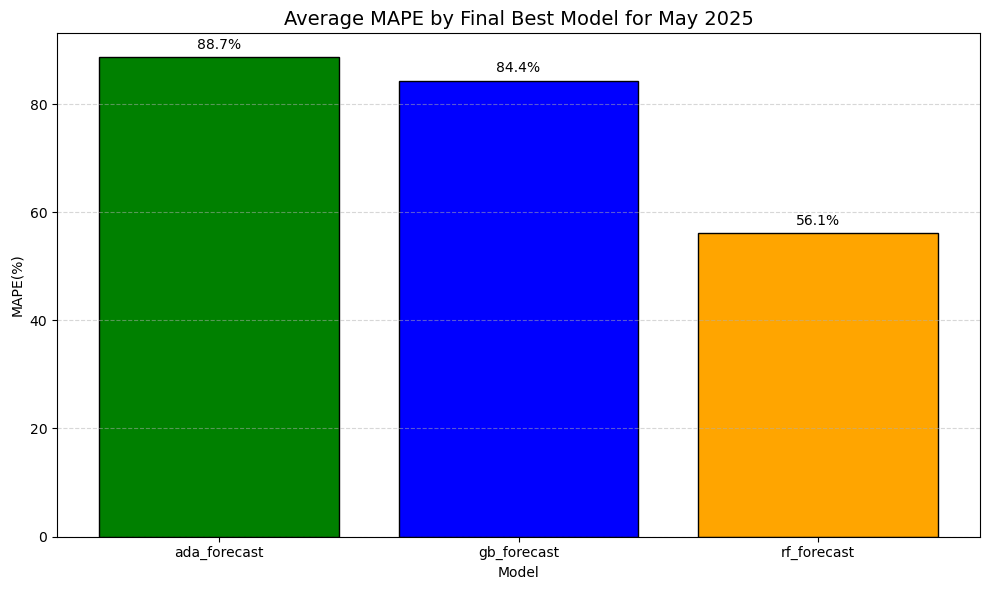

In [491]:
# Step 1: Calculate average MAPE per model (only where sales > 0)
model_avg_mape = (
    df_all_final[df_all_final['sales'] > 0]
    .groupby('final_best_model')['mape']
    .mean()
    .sort_values(ascending=False)
)

# Step 2: Define custom colors by model
color_map = {
    'gb': 'blue',
    'ada': 'green',
    'bag': 'purple',
    'rf': 'orange',
    'final': 'red'
}

# Match colors to model names in the index
bar_colors = [color_map.get(model.split('_')[0], 'gray') for model in model_avg_mape.index]

# Step 3: Plot vertical bars
plt.figure(figsize=(10, 6))
bars = plt.bar(model_avg_mape.index, model_avg_mape.values, color=bar_colors, edgecolor='black')

# Step 4: Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

# Final touches
plt.title('Average MAPE by Final Best Model for May 2025', fontsize=14)
plt.ylabel('MAPE(%)')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_1299/2772609639.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_may, x='log_segment', order=segment_order, palette='turbo')


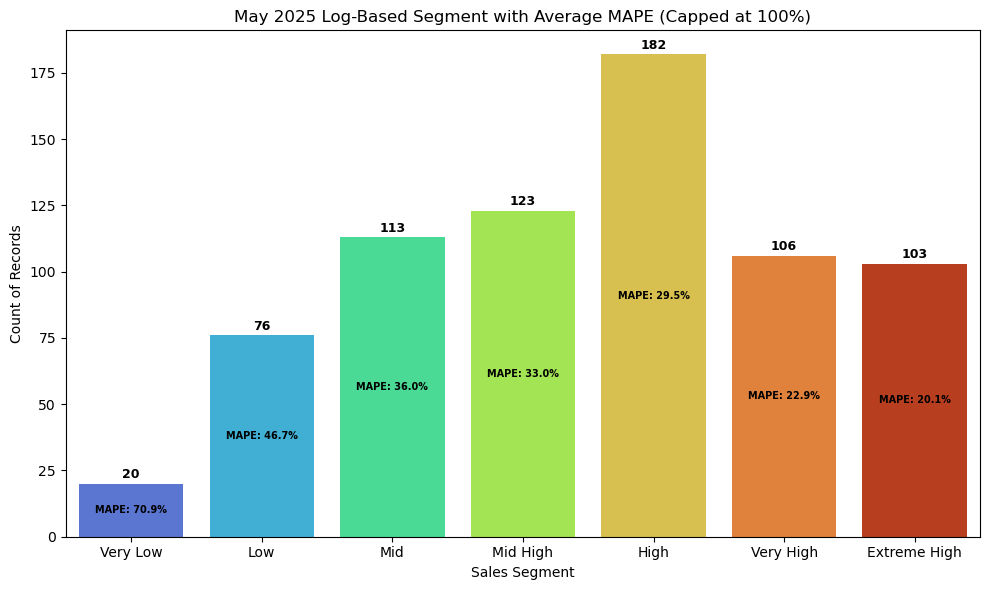

In [565]:
# Step 0: Filter to May records
df_may = df_all_final[df_all_final['month'] == 5].copy()

# Step 1: Cap extreme MAPE values for display
df_may['mape_capped'] = df_may['mape'].clip(upper=100)

# Step 2: Define segment order
segment_order = ['Very Low', 'Low', 'Mid', 'Mid High', 'High', 'Very High', 'Extreme High']

# Step 3: Calculate average capped MAPE per segment
mape_by_segment = df_may.groupby('log_segment')['mape_capped'].mean().reindex(segment_order)

# Step 4: Create the countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_may, x='log_segment', order=segment_order, palette='turbo')

# Step 5: Annotate each bar with count and MAPE
for p, segment_name in zip(ax.patches, segment_order):
    height = p.get_height()
    xpos = p.get_x() + p.get_width() / 2.

    # Count label on top
    ax.text(xpos, height + 1, f'{int(height)}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # MAPE label inside bar
    mape_val = mape_by_segment.get(segment_name, np.nan)
    if not np.isnan(mape_val):
        ax.text(xpos, height / 2, f'MAPE: {mape_val:.1f}%', ha='center', va='center',
                fontsize=7, color='black', fontweight='bold')

# Final formatting
plt.title("May 2025 Log-Based Segment with Average MAPE (Capped at 100%)")
plt.xlabel("Sales Segment")
plt.ylabel("Count of Records")
plt.tight_layout()
plt.show()


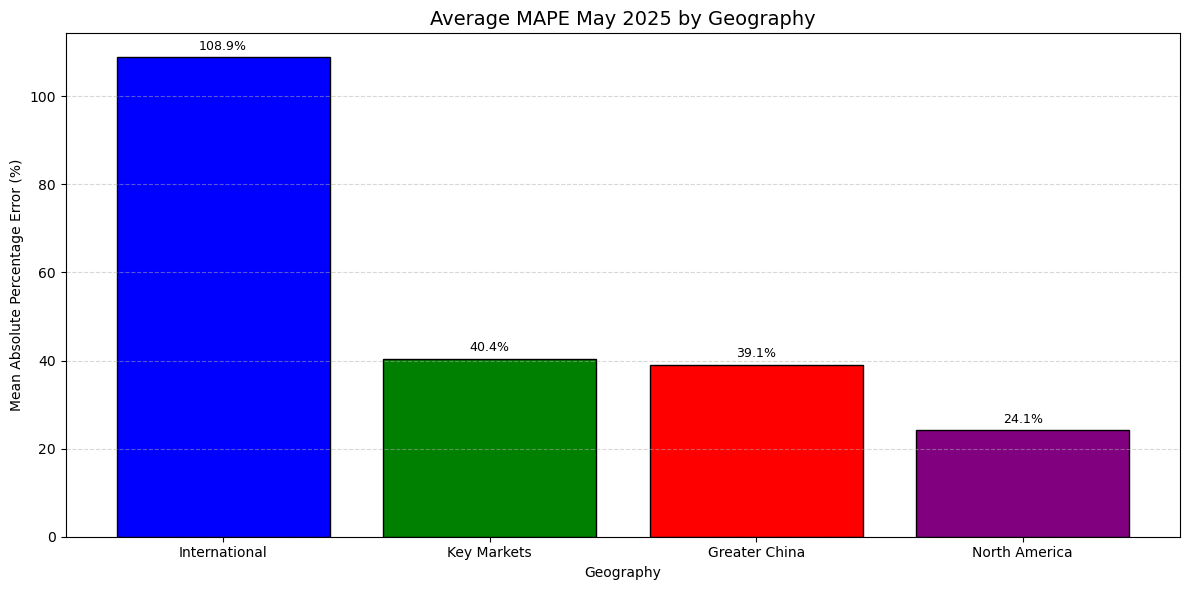

In [509]:
# Define custom colors for each geography
geo_colors = {
    'Greater China': 'red',
    'International': 'blue',
    'Key Markets': 'green',
    'North America': 'purple'
}


# Step 1: Filter valid sales records
df_geo = df_all_final[df_all_final['sales'] > 0].copy()

# Step 2: Calculate average MAPE per geography
mape_by_geo = (
    df_geo.groupby('geography')['mape']
    .mean()
    .sort_values(ascending=False)
)

# Step 3: Assign colors based on geography
bar_colors = [geo_colors.get(geo, 'gray') for geo in mape_by_geo.index]

# Step 4: Plot bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(mape_by_geo.index, mape_by_geo.values, color=bar_colors, edgecolor='black')

# Step 5: Add percentage labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Final touches
plt.title('Average MAPE May 2025 by Geography', fontsize=14)
plt.xlabel('Geography')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



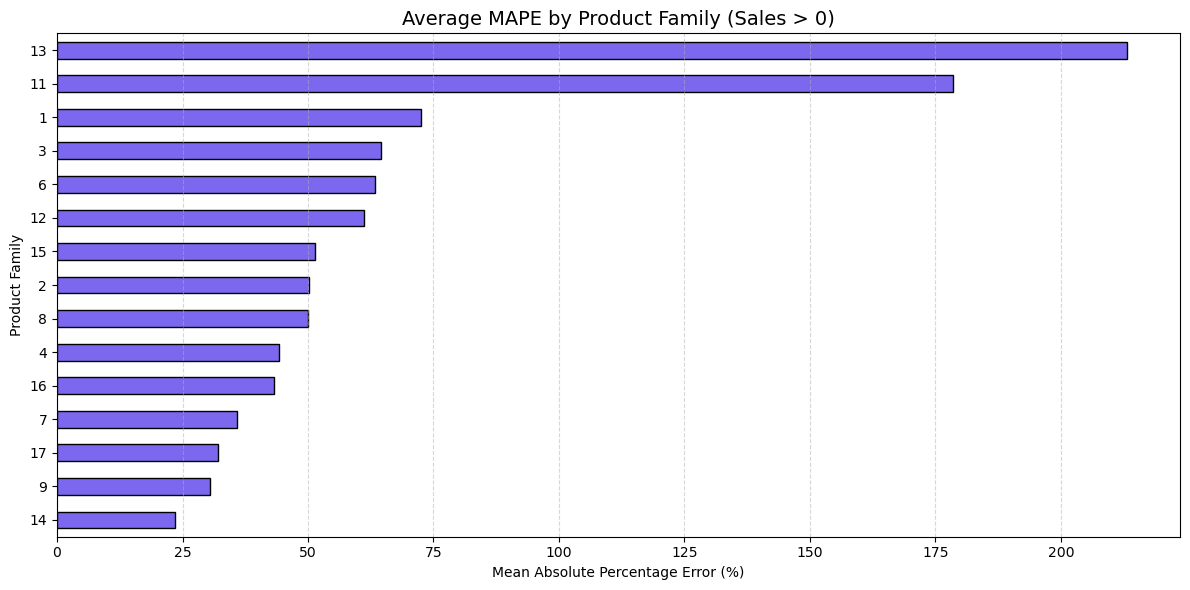

In [475]:


# Group and sort by mean MAPE (sales > 0 only)
mape_by_family = df_all_final[df_all_final['sales'] > 0].groupby('product_family')['mape'].mean().sort_values()

# Plot
plt.figure(figsize=(12, 6))
mape_by_family.plot(kind='barh', color='mediumslateblue', edgecolor='black')

plt.title('Average MAPE by Product Family (Sales > 0)', fontsize=14)
plt.xlabel('Mean Absolute Percentage Error (%)')
plt.ylabel('Product Family')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




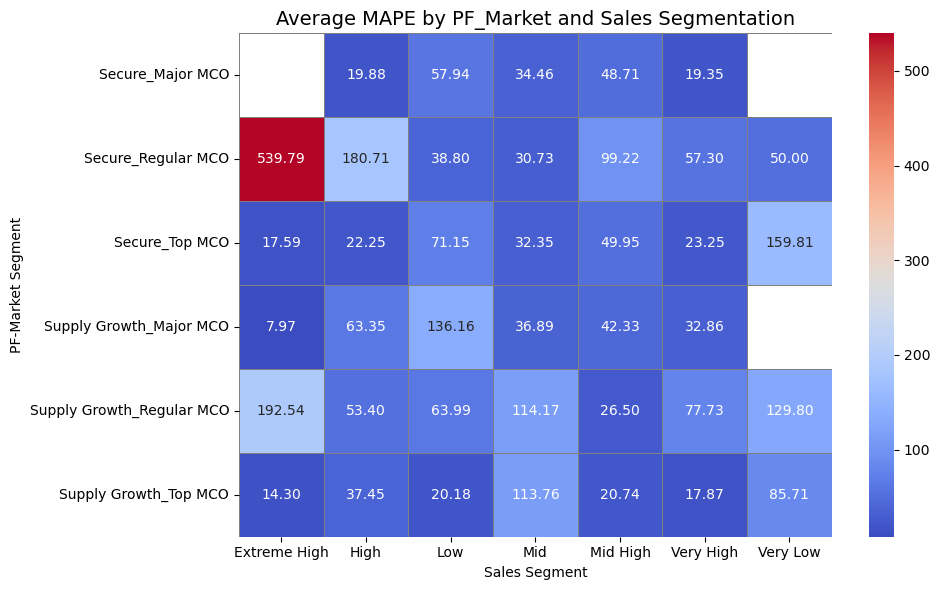

In [1520]:

# Step 1: Filter to relevant rows (optional but recommended)
df_filtered = df_all_final[df_all_final['sales'] > 0].copy()  # Only rows with sales

# Step 2: Calculate average MAPE per group
heatmap_df = (
    df_filtered
    .groupby(['seg_combo', 'log_segment'])['mape']
    .mean()
    .unstack()  # Makes columns from 'log_segment'
)

# Step 3: Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, linecolor='gray')

plt.title('Average MAPE by PF_Market and Sales Segmentation', fontsize=14)
plt.xlabel('Sales Segment')
plt.ylabel('PF-Market Segment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


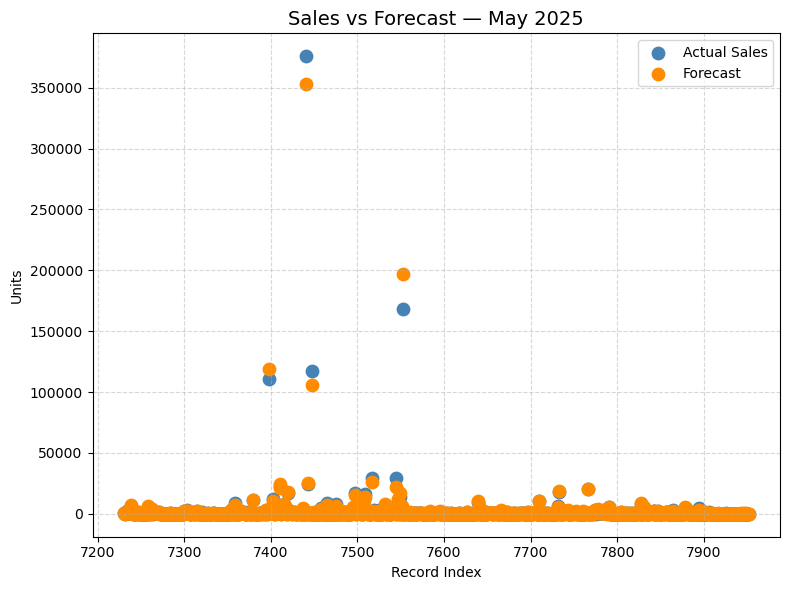

In [1610]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Filter to May 2025
df_may25 = df_all_final[(df_all_final['year'] == 2025) & (df_all_final['month'] == 5)].copy()

# Step 2: Create the plot
plt.figure(figsize=(8, 6))

# Plot actual sales
plt.scatter(df_may25.index, df_may25['sales'], color='steelblue', label='Actual Sales', s=80)

# Plot forecast
plt.scatter(df_may25.index, df_may25['final_forecast'], color='darkorange', label='Forecast', s=80)

# Formatting
plt.title('Sales vs Forecast — May 2025', fontsize=14)
plt.xlabel('Record Index')
plt.ylabel('Units')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [1576]:
df_all_final.columns


Index(['gmid_key', 'date', 'year', 'month', 'product_family', 'gmid', 'loc',
       'country', 'market', 'geography', 'market_segmentation',
       'pf_segmentation', 'gmid_segmentation', 'seg_combo', 'forecast_lag_3',
       'log_sales', 'log_segment', 'seg_combo_lag', 'model_segment',
       'gb_forecast', 'ada_forecast', 'bag_forecast', 'rf_forecast',
       'final_forecast', 'final_best_model', 'absolute_error', 'mape',
       'sales'],
      dtype='object')

In [1586]:
# Filter rows with extreme MAPE
# Define the columns you want to display
columns_to_show = ['year', 'month', 'gmid', 'country', 'forecast_lag_3', 'model_segment',
       'gb_forecast', 'ada_forecast', 'bag_forecast', 'rf_forecast',
       'final_forecast', 'final_best_model', 'absolute_error', 'mape',
       'sales']

# Filter and sort
df_extreme_mape = (
    df_all_final[df_all_final['mape'] > 1000]
    .sort_values('mape', ascending=False)
    [columns_to_show]
)

# Display the result
df_extreme_mape.head(10)


year  month    gmid country  forecast_lag_3  \
7809  2025      5  130011      BR           312.0   
7761  2025      5  110040      MX             0.0   
7743  2025      5  110019      BR          1478.0   
7437  2025      5  150043      BR          2076.0   

                               model_segment  gb_forecast  ada_forecast  \
7809                 Secure_Regular MCO_High   547.164354    549.160000   
7761         Secure_Regular MCO_Extreme High  2415.492394   2420.400000   
7743         Secure_Regular MCO_Extreme High  3082.599515   3085.166667   
7437  Supply Growth_Regular MCO_Extreme High  5078.690971   5092.000000   

      bag_forecast  rf_forecast  final_forecast final_best_model  \
7809    549.105030   547.999841      547.999841      rf_forecast   
7761   2419.379508  2419.100000     2415.492394      gb_forecast   
7743   3082.932897  3084.700000     3082.599515      gb_forecast   
7437   5087.461667  5088.677778     5092.000000     ada_forecast   

      absolute_error         mape  sales  
7809      535.999841  4466.665344   12.0  
7761     2322.492394  2497.303650   93.0  
7743     2914.599515  1734.880664  168.0  
7437     4692.000000  1173.000000  400.0

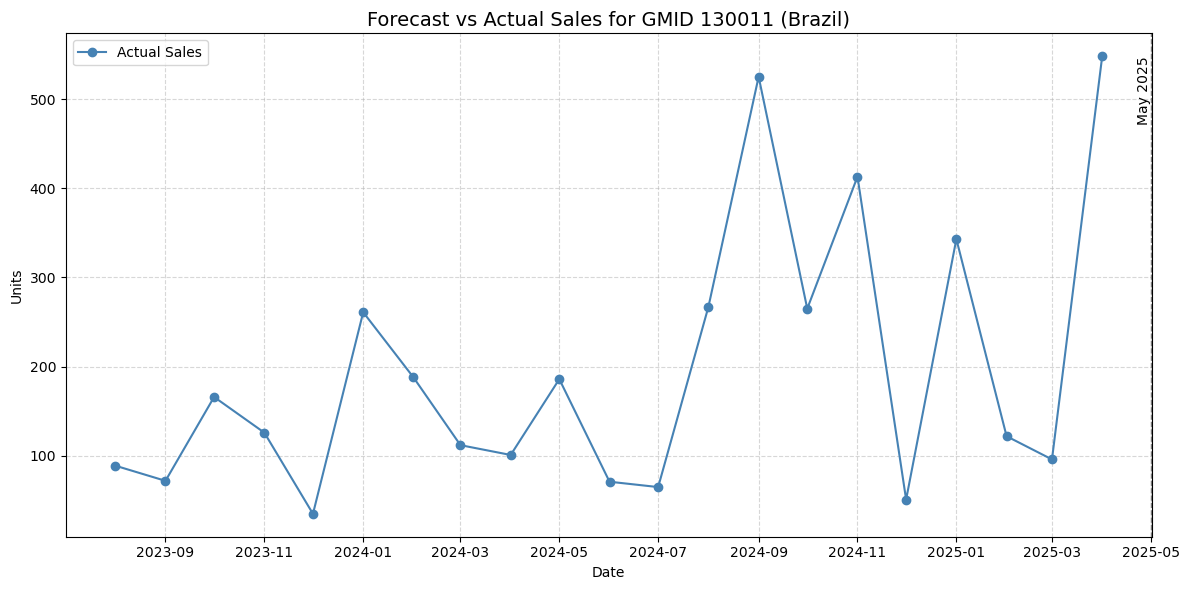

In [1566]:


# Step 1: Filter the data
df_plot = df_new[(df_new['gmid'] == 130011) & (df_new['country'] == 'BR')].copy()

# Step 2: Create a proper datetime column
df_plot['date'] = pd.to_datetime(df_plot[['year', 'month']].assign(day=1))

# Step 3: Sort by date
df_plot = df_plot.sort_values('date')

# Step 4: Plot forecast vs actual sales
plt.figure(figsize=(12, 6))
plt.plot(df_plot['date'], df_plot['sales'], label='Actual Sales', marker='o', color='steelblue')


# Optional: Highlight May 2025
plt.axvline(pd.Timestamp('2025-05-01'), color='gray', linestyle='--', linewidth=1)
plt.text(pd.Timestamp('2025-05-01'), max(df_plot['sales']), 'May 2025', rotation=90, va='top', ha='right', fontsize=10)

# Formatting
plt.title('Forecast vs Actual Sales for GMID 130011 (Brazil)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


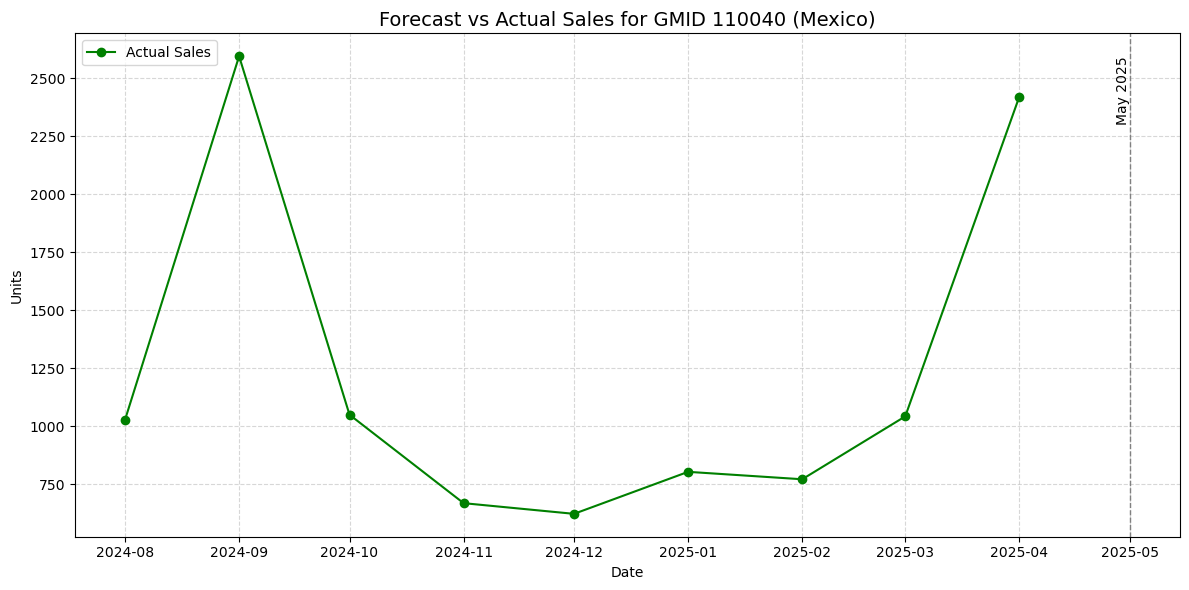

In [1590]:

# Step 1: Filter the data
df_plot = df_new[(df_new['gmid'] == 110040) & (df_new['country'] == 'MX')].copy()

# Step 2: Create a proper datetime column
df_plot['date'] = pd.to_datetime(df_plot[['year', 'month']].assign(day=1))

# Step 3: Sort by date
df_plot = df_plot.sort_values('date')

# Step 4: Plot forecast vs actual sales
plt.figure(figsize=(12, 6))
plt.plot(df_plot['date'], df_plot['sales'], label='Actual Sales', marker='o', color='green')


# Optional: Highlight May 2025
plt.axvline(pd.Timestamp('2025-05-01'), color='gray', linestyle='--', linewidth=1)
plt.text(pd.Timestamp('2025-05-01'), max(df_plot['sales']), 'May 2025', rotation=90, va='top', ha='right', fontsize=10)

# Formatting
plt.title('Forecast vs Actual Sales for GMID 110040 (Mexico)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

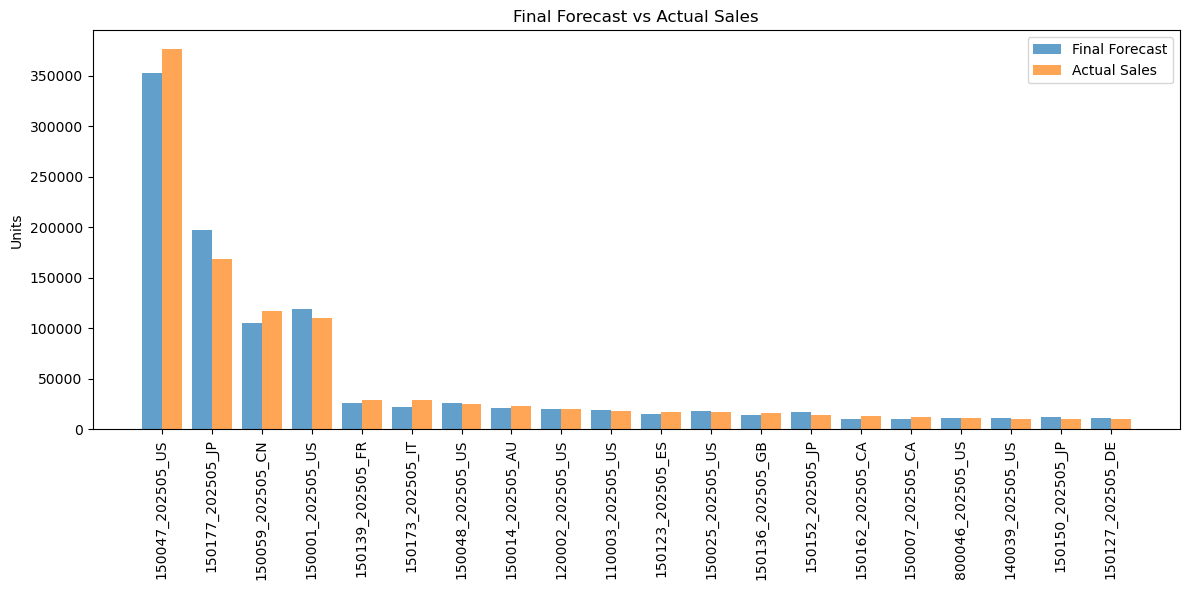

In [1472]:
sample = df_all_final[['gmid_key', 'final_forecast', 'sales']].copy()
sample = sample.sort_values('sales', ascending=False).head(20)  # Adjust N if needed

# Plot
plt.figure(figsize=(12, 6))
x = range(len(sample))

plt.bar(x, sample['final_forecast'], width=0.4, label='Final Forecast', align='center', alpha=0.7)
plt.bar([i + 0.4 for i in x], sample['sales'], width=0.4, label='Actual Sales', align='center', alpha=0.7)

plt.xticks([i + 0.2 for i in x], sample['gmid_key'], rotation=90)
plt.ylabel('Units')
plt.title('Final Forecast vs Actual Sales')
plt.legend()
plt.tight_layout()
plt.show()


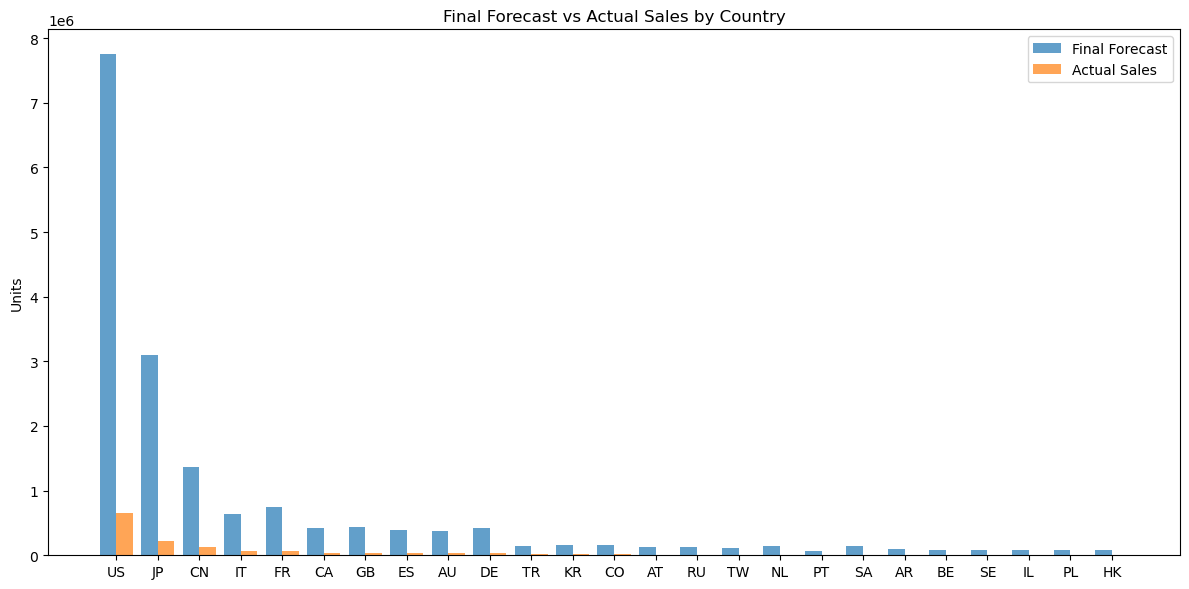

In [1494]:


# Step 1: Aggregate totals per country
country_totals = df_all_final.groupby('country')[['final_forecast', 'sales']].sum().sort_values('sales', ascending=False).head(25)

# Optional: reset index to make 'country' a column
country_totals = country_totals.reset_index()

# Step 2: Plot
plt.figure(figsize=(12, 6))
x = range(len(country_totals))

plt.bar(x, country_totals['final_forecast'], width=0.4, label='Final Forecast', align='center', alpha=0.7)
plt.bar([i + 0.4 for i in x], country_totals['sales'], width=0.4, label='Actual Sales', align='center', alpha=0.7)

plt.xticks([i + 0.2 for i in x], country_totals['country'], rotation=45)
plt.ylabel('Units')
plt.xticks(rotation=0)
plt.title('Final Forecast vs Actual Sales by Country')
plt.legend()
plt.tight_layout()
plt.show()


In [1618]:
# Step 1: Aggregate totals per country
country_totals = (
    df_all_final.groupby('country')[['final_forecast', 'sales']]
    .sum()
    .sort_values('sales', ascending=False)
    .head(25)
    .reset_index()
)

# Step 2: Add helpful columns (optional)
country_totals['forecast_bias'] = country_totals['final_forecast'] - country_totals['sales']
country_totals['forecast_accuracy'] = (1 - abs(country_totals['forecast_bias']) / country_totals['sales']) * 100

# Step 3: Format and display as styled table
country_totals.style.format({
    'final_forecast': '{:,.0f}',
    'sales': '{:,.0f}',
    'forecast_bias': '{:+,.0f}',
    'forecast_accuracy': '{:.1f}%'
}).background_gradient(subset=['forecast_accuracy'], cmap='RdYlGn')


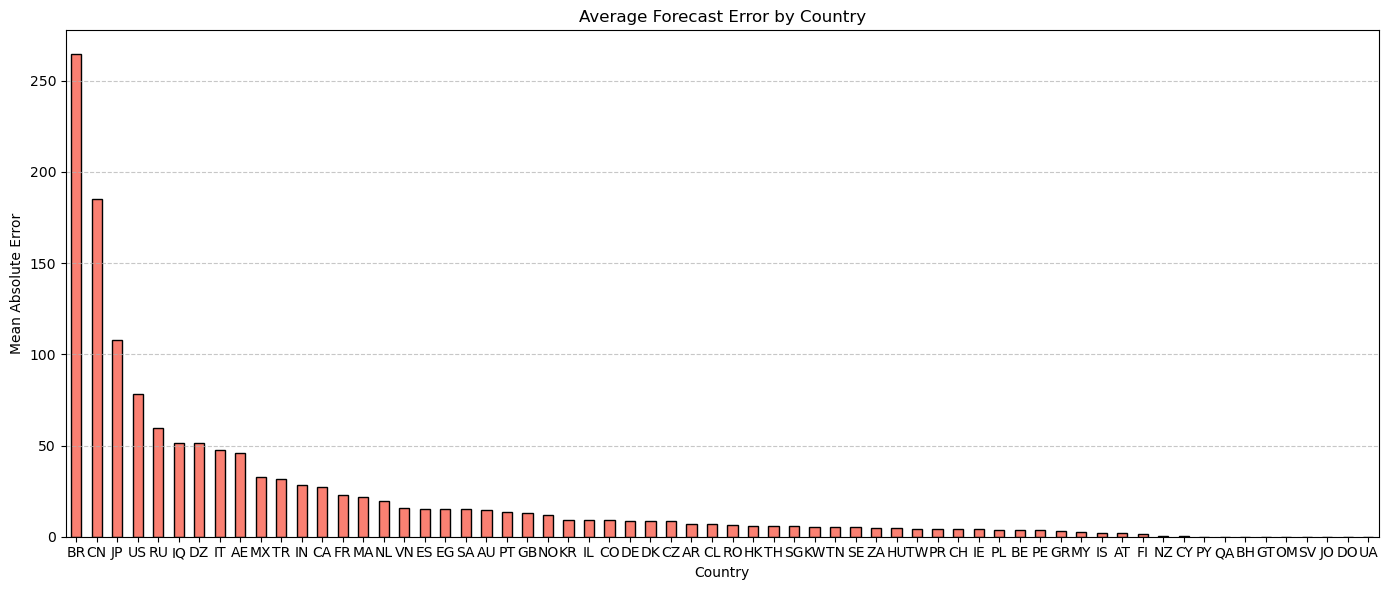

In [1484]:
# Group by country and compute mean absolute error
country_errors = df_all_final.groupby('country')['absolute_error'].mean().sort_values(ascending=False)

# Plot the top countries with highest forecast deviation
plt.figure(figsize=(14, 6))
country_errors.plot(kind='bar', color='salmon', edgecolor='black')

plt.title('Average Forecast Error by Country')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Country')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


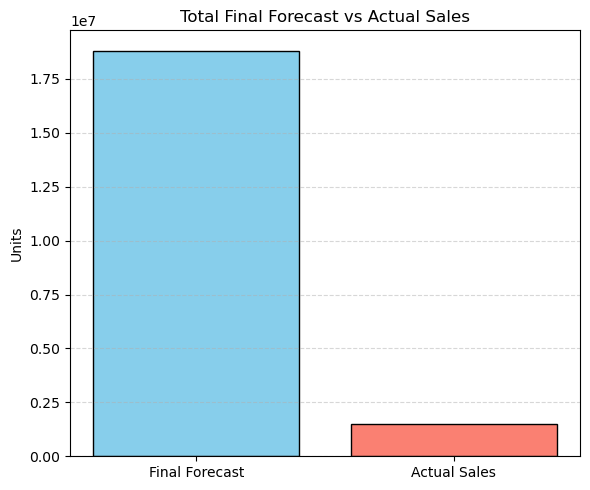

In [1486]:
import matplotlib.pyplot as plt

# Calculate total sales and forecast
total_sales = df_all_final['sales'].sum()
total_forecast = df_all_final['final_forecast'].sum()

# Create a simple comparison chart
plt.figure(figsize=(6, 5))
plt.bar(['Final Forecast', 'Actual Sales'], [total_forecast, total_sales], color=['skyblue', 'salmon'], edgecolor='black')

plt.title('Total Final Forecast vs Actual Sales')
plt.ylabel('Units')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


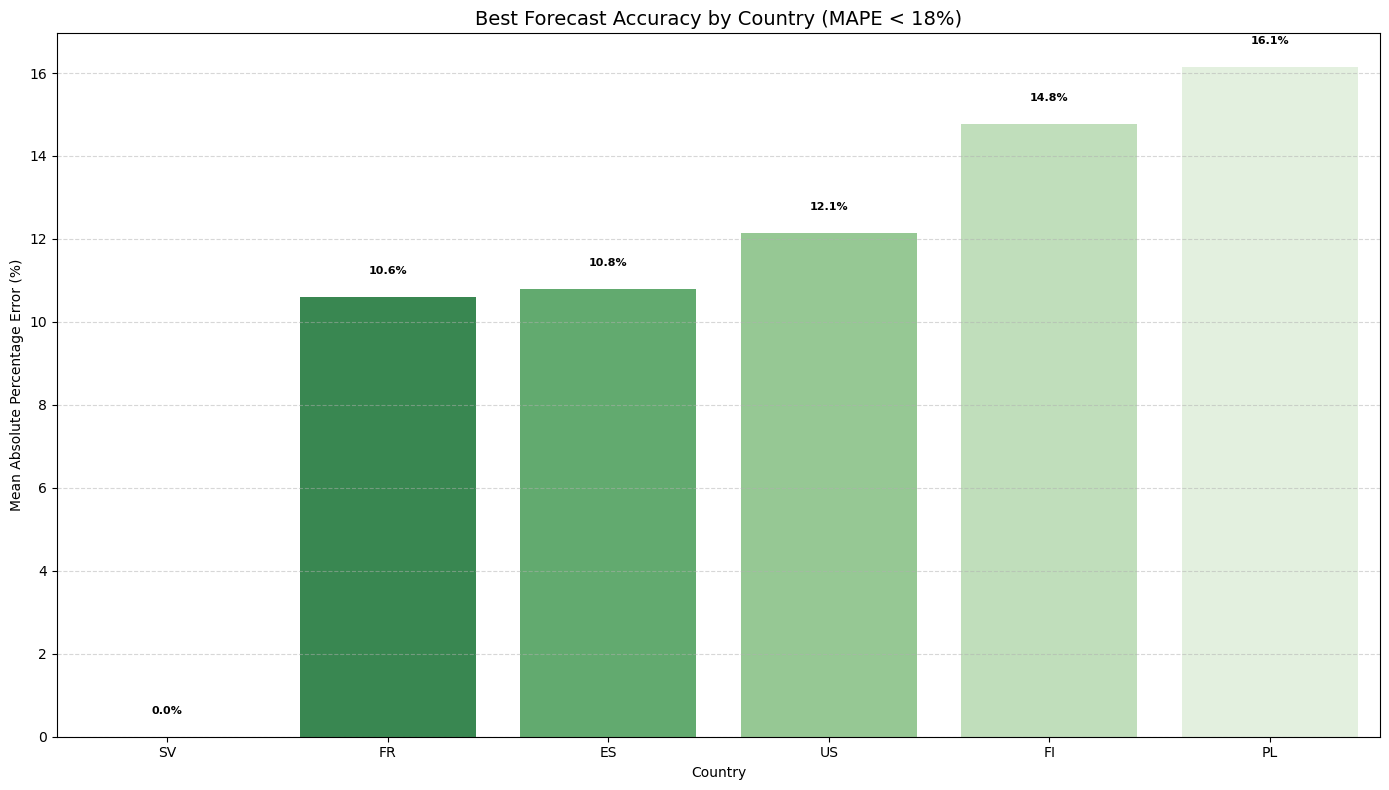

In [1646]:


# Step 1: Aggregate average MAPE per country (excluding zero sales)
country_mape = (
    df_all_final[df_all_final['sales'] > 0]
    .groupby('country')['mape']
    .mean()
    .reset_index()
)

# Step 2: Filter to countries with MAPE < 18%
best_mape_countries = country_mape[country_mape['mape'] < 18].sort_values('mape')

# Step 3: Plot vertical bar chart with dummy hue to satisfy Seaborn
plt.figure(figsize=(14, 8))
bars = sns.barplot(
    data=best_mape_countries.assign(hue=best_mape_countries['country']),
    x='country',
    y='mape',
    hue='hue',
    palette='Greens_r',
    legend=False
)

# Step 4: Add MAPE values above each bar
for bar, mape in zip(bars.patches, best_mape_countries['mape']):
    height = bar.get_height()
    xpos = bar.get_x() + bar.get_width() / 2
    bars.text(
        xpos,
        height + 0.5,  # position above the bar
        f'{mape:.1f}%',
        ha='center',
        va='bottom',
        color='black',
        fontsize=8,
        fontweight='bold'
    )

# Formatting
plt.title('Best Forecast Accuracy by Country (MAPE < 18%)', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()







In [1700]:
# Number of records with sales > 0
sales_may_25 = (df_all_final['sales'] > 0).sum()
sales_may_25




636

In [1704]:
# Number of records with MAPE < 18
ok_mape = (df_all_final['mape'] < 18).sum()
ok_mape

301

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4681/2172091856.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=country_counts, x='country', y='record_count', palette='Purples')


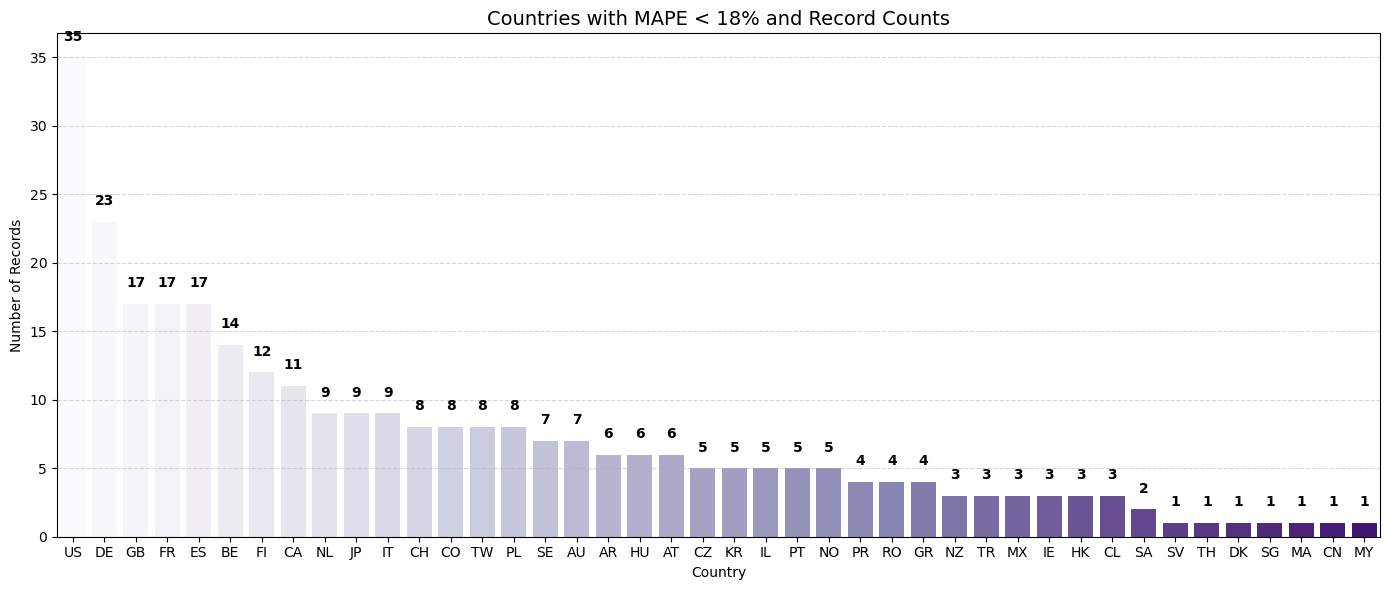

In [1656]:


# Step 1: Filter rows with MAPE < 18% and sales > 0
df_low_mape = df_all_final[(df_all_final['sales'] > 0) & (df_all_final['mape'] < 18)]

# Step 2: Count records per country
country_counts = (
    df_low_mape.groupby('country')
    .size()
    .reset_index(name='record_count')
    .sort_values('record_count', ascending=False)
)

# Step 3: Plot vertical bar chart
plt.figure(figsize=(14, 6))
bars = sns.barplot(data=country_counts, x='country', y='record_count', palette='Purples')

# Step 4: Annotate each bar with count
for bar, count in zip(bars.patches, country_counts['record_count']):
    height = bar.get_height()
    xpos = bar.get_x() + bar.get_width() / 2
    bars.text(
        xpos,
        height + 1,
        f'{count}',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Formatting
plt.title('Countries with MAPE < 18% and Record Counts', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Number of Records')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4681/3080988203.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=country_ratio_sorted, y='country', x='mape_ratio', palette='Greens')


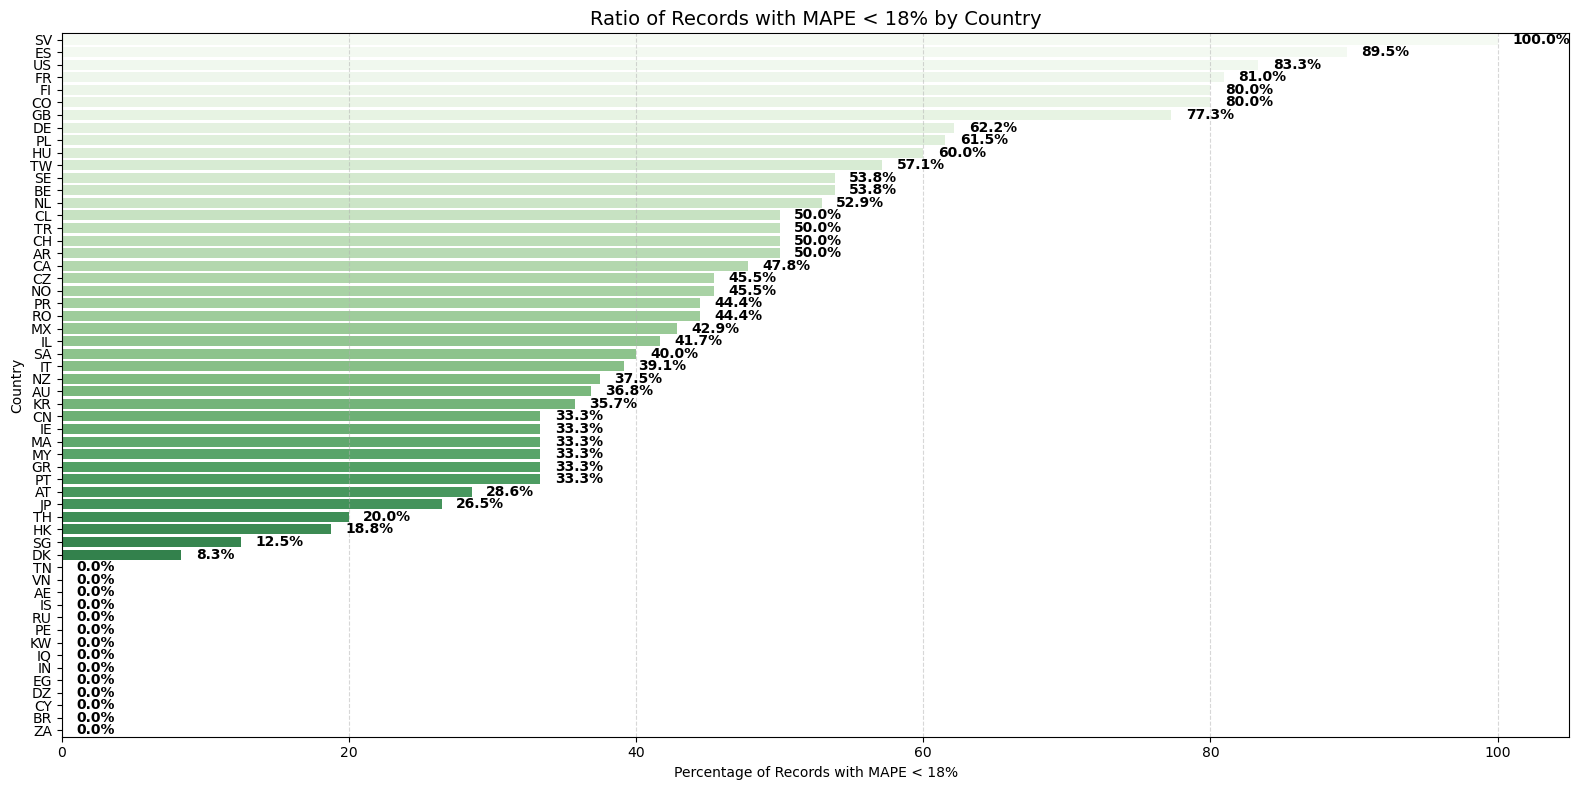

In [1718]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Filter valid rows (exclude zero sales to avoid inflated MAPE)
df_valid = df_all_final[df_all_final['sales'] > 0]

# Step 2: Calculate total and low-MAPE counts per country
country_total = df_valid.groupby('country').size().reset_index(name='total_count')
country_low_mape = df_valid[df_valid['mape'] < 18].groupby('country').size().reset_index(name='low_mape_count')

# Step 3: Merge and calculate ratio
country_ratio = pd.merge(country_total, country_low_mape, on='country', how='left')
country_ratio['low_mape_count'] = country_ratio['low_mape_count'].fillna(0)
country_ratio['mape_ratio'] = (country_ratio['low_mape_count'] / country_ratio['total_count']) * 100

# Step 4: Sort and plot horizontal bar chart
country_ratio_sorted = country_ratio.sort_values('mape_ratio', ascending=False)

plt.figure(figsize=(16, 8))
bars = sns.barplot(data=country_ratio_sorted, y='country', x='mape_ratio', palette='Greens')

# Annotate each bar with ratio
for bar, ratio in zip(bars.patches, country_ratio_sorted['mape_ratio']):
    xpos = bar.get_width()
    ypos = bar.get_y() + bar.get_height() / 2
    bars.text(
        xpos + 1,
        ypos,
        f'{ratio:.1f}%',
        va='center',
        ha='left',
        fontsize=10,
        fontweight='bold'
    )

# Formatting
plt.title('Ratio of Records with MAPE < 18% by Country', fontsize=14)
plt.xlabel('Percentage of Records with MAPE < 18%')
plt.ylabel('Country')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4681/3947953105.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=country_ratio_sorted, x='country', y='mape_ratio', palette='Greens')


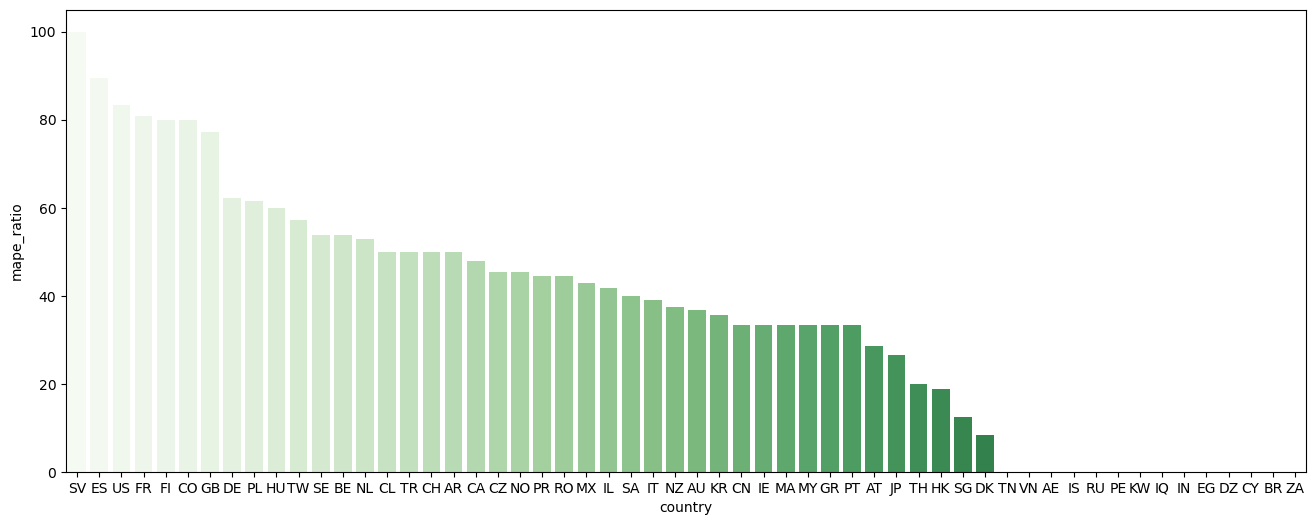

In [1710]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Filter valid rows (exclude zero sales)
df_valid = df_all_final[df_all_final['sales'] > 0]

# Step 2: Calculate total and low-MAPE counts per country
country_total = df_valid.groupby('country').size().reset_index(name='total_count')
country_low_mape = df_valid[df_valid['mape'] < 18].groupby('country').size().reset_index(name='low_mape_count')

# Step 3: Merge and calculate ratio
country_ratio = pd.merge(country_total, country_low_mape, on='country', how='left')
country_ratio['low_mape_count'] = country_ratio['low_mape_count'].fillna(0)
country_ratio['mape_ratio'] = (country_ratio['low_mape_count'] / country_ratio['total_count']) * 100

# Step 4: Sort and plot vertical bar chart
country_ratio_sorted = country_ratio.sort_values('mape_ratio', ascending=False)

plt.figure(figsize=(16, 6))
bars = sns.barplot(data=country_ratio_sorted, x='country', y='mape_ratio', palette='Greens')

# Annotate each bar with ratio
for i, row in country_ratio_sorted.iterrows():
    plt.text

/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4681/767589844.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=product_counts, x='product_family', y='record_count', palette='Purples')


<Figure size 1000x800 with 0 Axes>

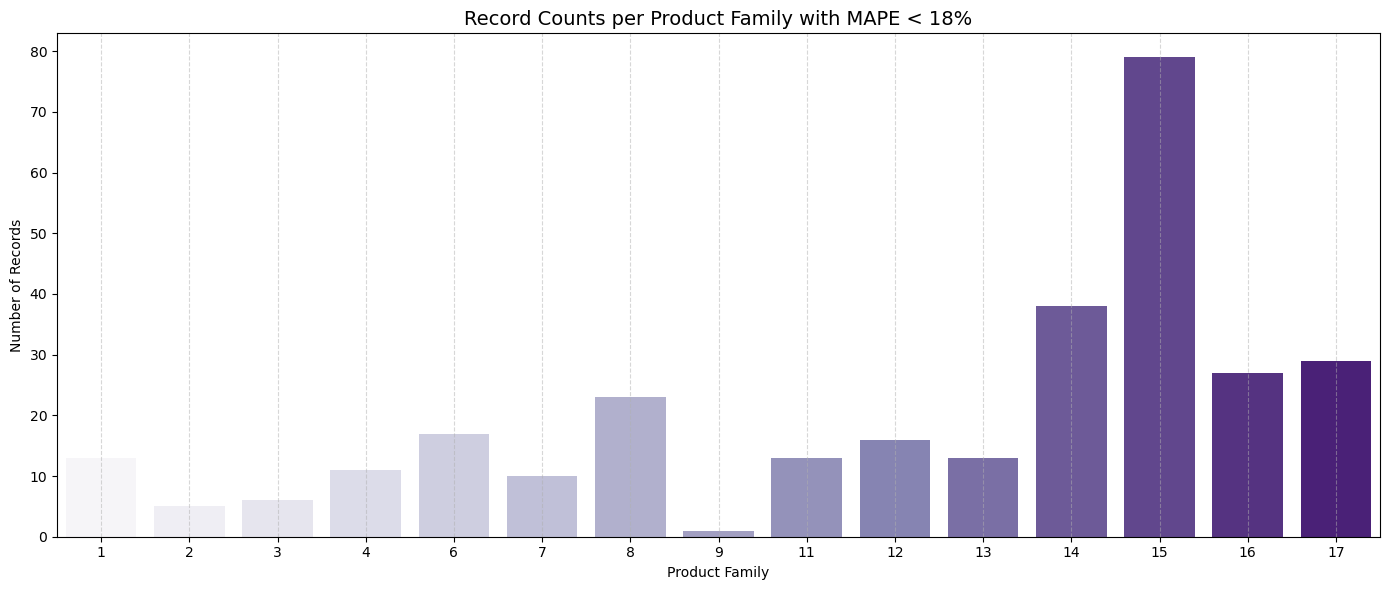

In [1722]:
# Step 1: Filter rows with MAPE < 18% and sales > 0
df_low_mape = df_all_final[(df_all_final['sales'] > 0) & (df_all_final['mape'] < 18)]

# Step 2: Count records per product family
product_counts = (
    df_low_mape.groupby('product_family')
    .size()
    .reset_index(name='record_count')
    .sort_values('record_count', ascending=True)
)

# Step 3: Plot horizontal bar chart
plt.figure(figsize=(10, 8))
plt.figure(figsize=(14, 6))
bars = sns.barplot(data=product_counts, x='product_family', y='record_count', palette='Purples')

# Formatting
plt.title('Record Counts per Product Family with MAPE < 18%', fontsize=14)
plt.xlabel('Product Family')
plt.ylabel('Number of Records')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



/var/folders/4g/4yj9rs3x2mxd3r_wz6p0pv080000gn/T/ipykernel_4681/29810399.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=segment_counts, y='model_segment', x='record_count', palette='Oranges')


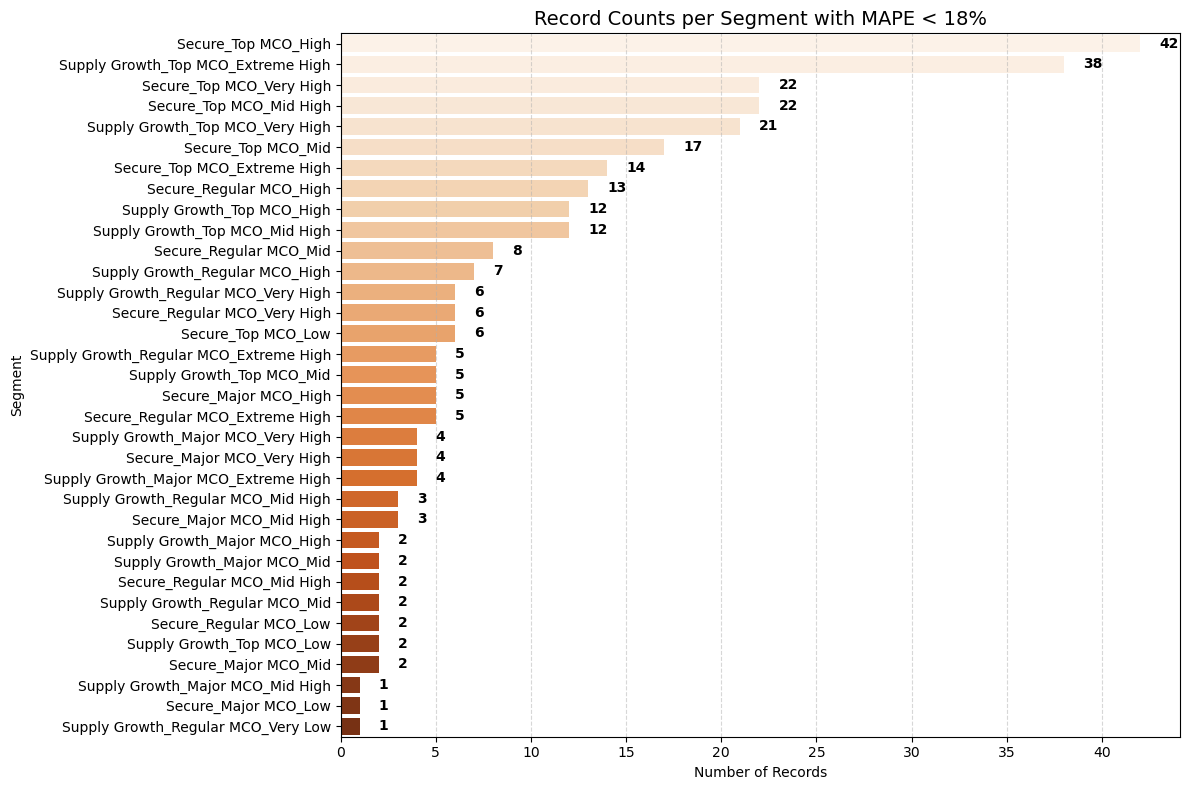

In [1698]:
# Step 1: Filter rows with MAPE < 18% and sales > 0
df_low_mape = df_all_final[(df_all_final['sales'] > 0) & (df_all_final['mape'] < 18)]

# Step 2: Count records per segment
segment_counts = (
    df_low_mape.groupby('model_segment')
    .size()
    .reset_index(name='record_count')
    .sort_values('record_count', ascending=False)  # ascending for horizontal layout
)

# Step 3: Plot horizontal bar chart
plt.figure(figsize=(12, 8))
bars = sns.barplot(data=segment_counts, y='model_segment', x='record_count', palette='Oranges')

# Step 4: Annotate each bar with count
for bar, count in zip(bars.patches, segment_counts['record_count']):
    xpos = bar.get_width()
    ypos = bar.get_y() + bar.get_height() / 2
    bars.text(
        xpos + 1,
        ypos,
        f'{count}',
        va='center',
        ha='left',
        fontsize=10,
        fontweight='bold'
    )

# Formatting
plt.title('Record Counts per Segment with MAPE < 18%', fontsize=14)
plt.xlabel('Number of Records')
plt.ylabel('Segment')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [1740]:
# Filter rows with best MAPE
# Define the columns you want to display
columns_to_show = ['year', 'month', 'gmid', 'country',  'forecast_lag_3', 'model_segment',
       'gb_forecast', 'ada_forecast', 'bag_forecast', 'rf_forecast',
       'final_forecast', 'final_best_model', 'absolute_error', 'mape',
       'sales']

# Filter and sort
df_extreme_mape = (
    df_all_final[df_all_final['mape'] < 18]
    .sort_values('mape', ascending=True)
    [columns_to_show]
)

# Display the result
df_extreme_mape.head(10)

year  month    gmid country  forecast_lag_3  \
7463  2025      5  150091      TH             2.0   
7387  2025      5  800051      SG            12.0   
7273  2025      5  100021      KR            99.0   
7746  2025      5  110024      AU            51.0   
7663  2025      5  170072      SV           100.0   
7722  2025      5  140050      DE            83.0   
7490  2025      5  150120      GB            15.0   
7803  2025      5  130007      CA          1180.0   
7277  2025      5  100036      TW            39.0   
7781  2025      5  120029      CZ          1329.0   

                           model_segment  gb_forecast  ada_forecast  \
7463  Supply Growth_Regular MCO_Very Low     3.441969      3.471503   
7387              Secure_Regular MCO_Low    12.268013     12.000000   
7273           Secure_Major MCO_Mid High    72.455377     72.162162   
7746              Secure_Regular MCO_Mid    28.133079     27.923913   
7663              Secure_Regular MCO_Low     8.374292      7.611511   
7722                  Secure_Top MCO_Mid    53.174304     54.185185   
7490           Supply Growth_Top MCO_Low     7.457674      7.003546   
7803                  Secure_Top MCO_Mid    36.293952     35.930769   
7277              Secure_Regular MCO_Mid    40.214183     39.962162   
7781      Supply Growth_Regular MCO_High   500.612066    499.857143   

      bag_forecast  rf_forecast  final_forecast final_best_model  \
7463      2.076419     3.000000        3.000000      rf_forecast   
7387     11.761746    12.000000       12.000000      rf_forecast   
7273     71.795708    72.000000       72.000000      rf_forecast   
7746     27.919234    28.000000       28.000000      rf_forecast   
7663      8.050692     8.000000        8.000000      rf_forecast   
7722     53.993944    54.000000       54.000000      rf_forecast   
7490      7.302926     7.000000        7.000000      rf_forecast   
7803     36.151644    36.000000       36.000000      rf_forecast   
7277     39.928511    40.000000       40.000000      rf_forecast   
7781    500.626593   499.999943      499.999943      rf_forecast   

      absolute_error      mape  sales  
7463        0.000000  0.000000    3.0  
7387        0.000000  0.000000   12.0  
7273        0.000000  0.000000   72.0  
7746        0.000000  0.000000   28.0  
7663        0.000000  0.000000    8.0  
7722        0.000000  0.000000   54.0  
7490        0.000000  0.000000    7.0  
7803        0.000000  0.000000   36.0  
7277        0.000000  0.000000   40.0  
7781        0.000057  0.000011  500.0

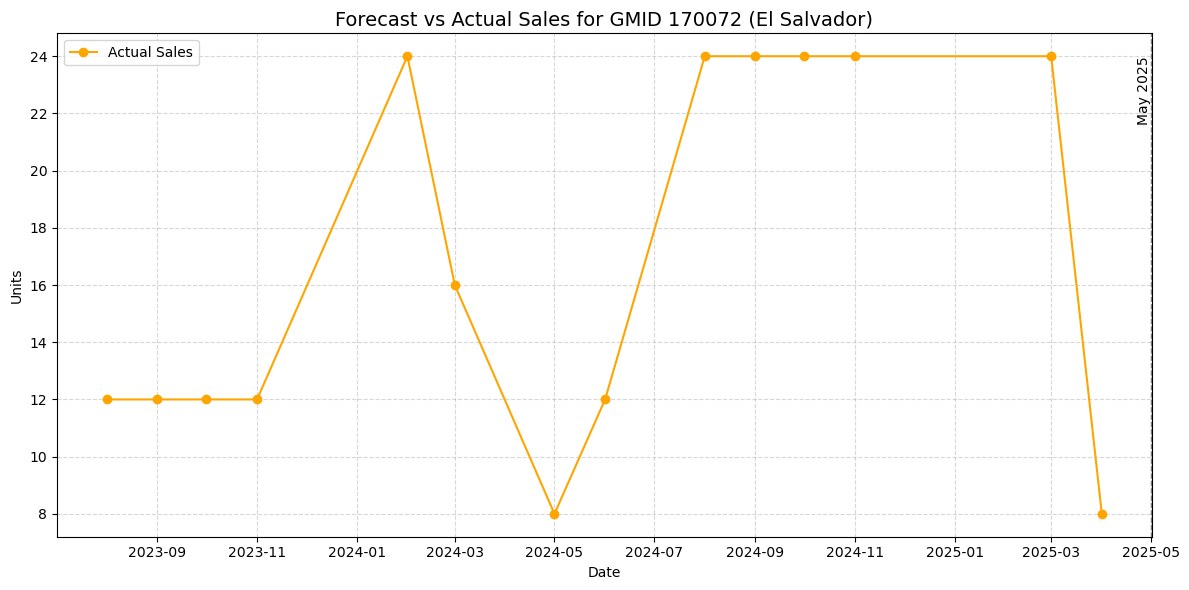

In [1754]:
# Step 1: Filter the data
df_plot = df_new[(df_new['gmid'] == 170072) & (df_new['country'] == 'SV')].copy()

# Step 2: Create a proper datetime column
df_plot['date'] = pd.to_datetime(df_plot[['year', 'month']].assign(day=1))

# Step 3: Sort by date
df_plot = df_plot.sort_values('date')

# Step 4: Plot forecast vs actual sales
plt.figure(figsize=(12, 6))
plt.plot(df_plot['date'], df_plot['sales'], label='Actual Sales', marker='o', color='orange')


# Optional: Highlight May 2025
plt.axvline(pd.Timestamp('2025-05-01'), color='gray', linestyle='--', linewidth=1)
plt.text(pd.Timestamp('2025-05-01'), max(df_plot['sales']), 'May 2025', rotation=90, va='top', ha='right', fontsize=10)

# Formatting
plt.title('Forecast vs Actual Sales for GMID 170072 (El Salvador)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [1744]:
# Define the columns you want to display
columns_to_show = [
    'year', 'month', 'gmid', 'country', 'forecast_lag_3', 'model_segment',
    'gb_forecast', 'ada_forecast', 'bag_forecast', 'rf_forecast',
    'final_forecast', 'final_best_model', 'absolute_error', 'mape', 'sales'
]

# Filter and sort
df_extreme_mape = (
    df_all_final[
        (df_all_final['mape'] < 18) &
        (df_all_final['country'].isin(['US', 'FR', 'ES']))
    ]
    .sort_values('mape', ascending=True)
    [columns_to_show]
)

# Display the result
df_extreme_mape.head(10)


year  month    gmid country  forecast_lag_3  \
7704  2025      5  140033      FR           408.0   
7815  2025      5  130016      ES           406.0   
7334  2025      5  700030      US           690.0   
7710  2025      5  140039      US           115.0   
7846  2025      5  160019      FR          1409.0   
7338  2025      5  700032      FR           126.0   
7766  2025      5  120002      US         17942.0   
7765  2025      5  110048      FR           747.0   
7379  2025      5  800046      US         14075.0   
7415  2025      5  150018      FR          7089.0   

                           model_segment   gb_forecast  ada_forecast  \
7704                 Secure_Top MCO_High    378.299015    379.954545   
7815                 Secure_Top MCO_High    442.064065    441.538462   
7334            Secure_Top MCO_Very High    711.960491    712.578947   
7710         Secure_Top MCO_Extreme High  10878.164001  10870.500000   
7846     Supply Growth_Top MCO_Very High   1669.640363   1667.388889   
7338             Secure_Top MCO_Mid High    127.955813    127.921348   
7766  Supply Growth_Top MCO_Extreme High  20180.315110  20148.333333   
7765                 Secure_Top MCO_High    509.299793    506.416667   
7379         Secure_Top MCO_Extreme High  11646.571343  11635.500000   
7415  Supply Growth_Top MCO_Extreme High   8303.043066   8322.000000   

      bag_forecast   rf_forecast  final_forecast final_best_model  \
7704    379.851411    378.995960      378.995960      rf_forecast   
7815    440.568968    441.997785      441.997785      rf_forecast   
7334    712.755343    712.002786      712.002786      rf_forecast   
7710  10857.863889  10872.022222    10870.500000     ada_forecast   
7846   1665.505905   1664.855556     1664.855556      rf_forecast   
7338    127.663200    128.000000      128.000000      rf_forecast   
7766  20121.016667  20144.655556    20180.315110      gb_forecast   
7765    506.015838    507.020556      507.020556      rf_forecast   
7379  11655.313333  11639.122222    11635.500000     ada_forecast   
7415   8309.136667   8313.633333     8303.043066      gb_forecast   

      absolute_error      mape    sales  
7704        0.004040  0.001066    379.0  
7815        2.997785  0.682867    439.0  
7334        6.997214  0.973187    719.0  
7710      121.500000  1.130338  10749.0  
7846       24.855556  1.515583   1640.0  
7338        2.000000  1.538462    130.0  
7766      348.684890  1.698499  20529.0  
7765        9.020556  1.811357    498.0  
7379      231.500000  2.029989  11404.0  
7415      196.043066  2.418195   8107.0

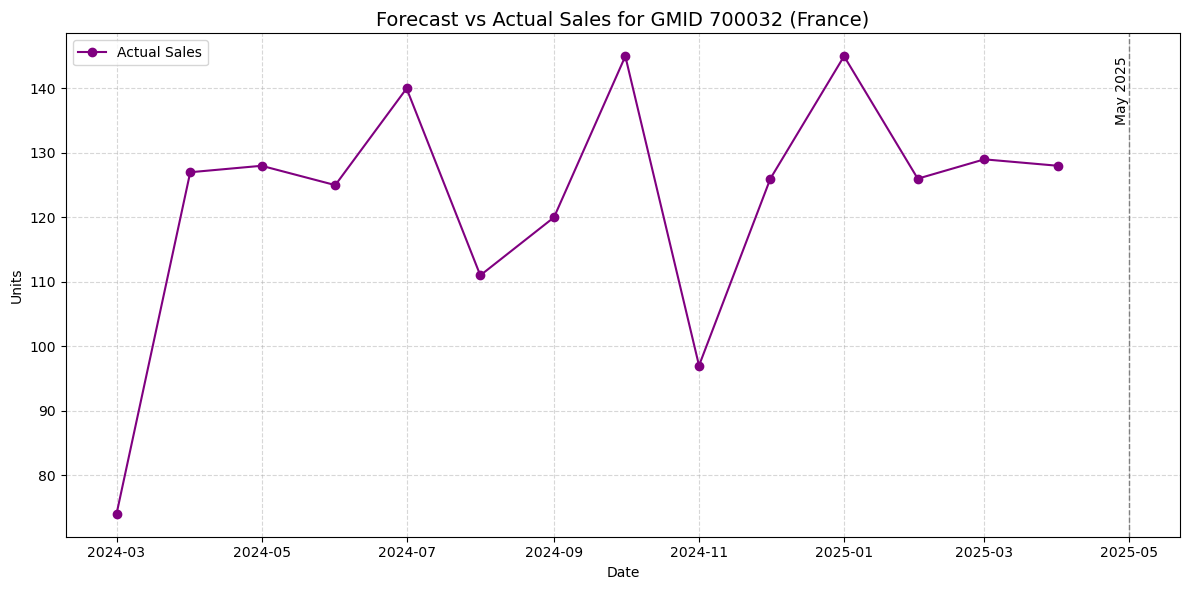

In [1756]:
# Step 1: Filter the data
df_plot = df_new[(df_new['gmid'] == 700032) & (df_new['country'] == 'FR')].copy()

# Step 2: Create a proper datetime column
df_plot['date'] = pd.to_datetime(df_plot[['year', 'month']].assign(day=1))

# Step 3: Sort by date
df_plot = df_plot.sort_values('date')

# Step 4: Plot forecast vs actual sales
plt.figure(figsize=(12, 6))
plt.plot(df_plot['date'], df_plot['sales'], label='Actual Sales', marker='o', color='purple')


# Optional: Highlight May 2025
plt.axvline(pd.Timestamp('2025-05-01'), color='gray', linestyle='--', linewidth=1)
plt.text(pd.Timestamp('2025-05-01'), max(df_plot['sales']), 'May 2025', rotation=90, va='top', ha='right', fontsize=10)

# Formatting
plt.title('Forecast vs Actual Sales for GMID 700032 (France)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

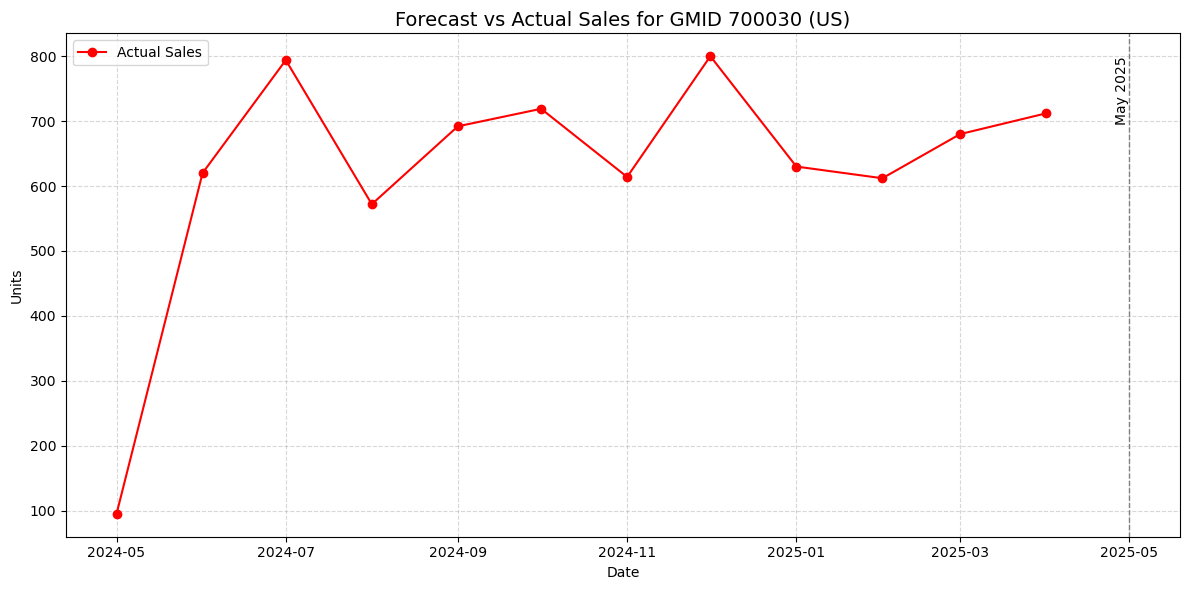

In [563]:
# Step 1: Filter the data
df_plot = df_new[(df_new['gmid'] == 700030) & (df_new['country'] == 'US')].copy()

# Step 2: Create a proper datetime column
df_plot['date'] = pd.to_datetime(df_plot[['year', 'month']].assign(day=1))

# Step 3: Sort by date
df_plot = df_plot.sort_values('date')

# Step 4: Plot forecast vs actual sales
plt.figure(figsize=(12, 6))
plt.plot(df_plot['date'], df_plot['sales'], label='Actual Sales', marker='o', color='red')


# Optional: Highlight May 2025
plt.axvline(pd.Timestamp('2025-05-01'), color='gray', linestyle='--', linewidth=1)
plt.text(pd.Timestamp('2025-05-01'), max(df_plot['sales']), 'May 2025', rotation=90, va='top', ha='right', fontsize=10)

# Formatting
plt.title('Forecast vs Actual Sales for GMID 700030 (US)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

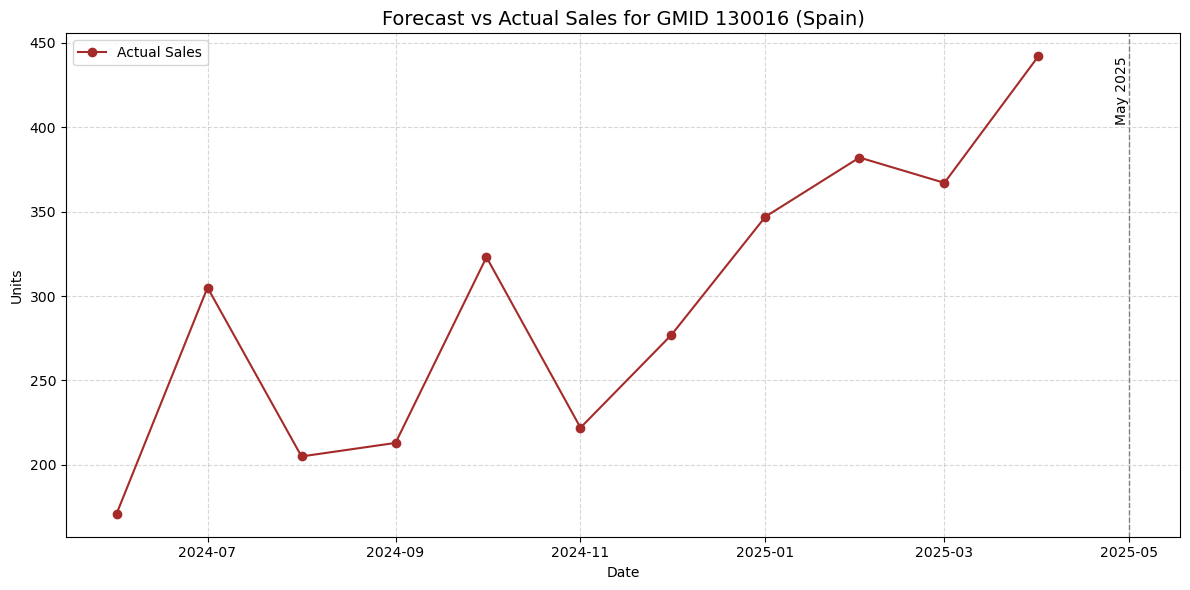

In [1774]:
# Step 1: Filter the data
df_plot = df_new[(df_new['gmid'] == 130016) & (df_new['country'] == 'ES')].copy()

# Step 2: Create a proper datetime column
df_plot['date'] = pd.to_datetime(df_plot[['year', 'month']].assign(day=1))

# Step 3: Sort by date
df_plot = df_plot.sort_values('date')

# Step 4: Plot forecast vs actual sales
plt.figure(figsize=(12, 6))
plt.plot(df_plot['date'], df_plot['sales'], label='Actual Sales', marker='o', color='brown')


# Optional: Highlight May 2025
plt.axvline(pd.Timestamp('2025-05-01'), color='gray', linestyle='--', linewidth=1)
plt.text(pd.Timestamp('2025-05-01'), max(df_plot['sales']), 'May 2025', rotation=90, va='top', ha='right', fontsize=10)

# Formatting
plt.title('Forecast vs Actual Sales for GMID 130016 (Spain)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()